In [1]:
import gempyor
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime
import glob, os, sys, re, shutil
from pathlib import Path

# import seaborn as sns
import matplotlib._color_data as mcd
import pyarrow.parquet as pq
import click
import subprocess
import dask.dataframe as dd
import matplotlib.dates as mdates
import matplotlib.cbook as cbook
from matplotlib.backends.backend_pdf import PdfPages

import os
import multiprocessing as mp
import pandas as pd
import pyarrow.parquet as pq
from gempyor import config, model_info, outcomes, seir

import os

# disable  operations using the MKL linear algebra.
os.environ["OMP_NUM_THREADS"] = "1"


data_dir = "RSV_USA/"
import os
os.chdir(data_dir)
data_dir = "."  # necessary for now for time serie parameters !!! fixme 

In [2]:
config_path = f"config_rsv_simplified_inference_v3_MD.yml"
run_id = "config_rsv_simplified_inference_v3_MD.yml"

config.clear()
config.read(user=False)
config.set_file(config_path)
print(config_path)


seir_modifiers_scenario="none"
outcome_modifiers_scenario="IHRadj"

in_run_id = run_id
out_run_id = in_run_id
in_prefix = "emcee"

out_prefix = in_prefix

write_csv = False
write_parquet = True
modinf = model_info.ModelInfo(
    config=config,
    nslots=1,
    seir_modifiers_scenario=seir_modifiers_scenario,
    outcome_modifiers_scenario=outcome_modifiers_scenario,
    write_csv=write_csv,
    write_parquet=write_parquet,
    first_sim_index=1,
    in_run_id=in_run_id,
    in_prefix=in_prefix,
    inference_filename_prefix="no",
    inference_filepath_suffix="no",
    out_run_id=out_run_id,
    out_prefix=out_prefix,
    stoch_traj_flag=False,
)

CRITICAL:root:No mobility matrix specified -- assuming no one moves


config_rsv_simplified_inference_v3_MD.yml


In [3]:
# find what to perturb
fitted_params = {
    "ptype":[],
    "pname":[],
    "pdist":[],
    "ub":[],
    "lb":[],
}
ndim=0

print("SEIR MODIFIERS")
for npi in gempyor.config["seir_modifiers"]["modifiers"].get():
    if gempyor.config["seir_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["seir_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("snpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)
        
print("OUTCOMES MODIFIERS")   
for npi in gempyor.config["outcome_modifiers"]["modifiers"].get():
    if gempyor.config["outcome_modifiers"]["modifiers"][npi]["perturbation"].exists():
        c = config["outcome_modifiers"]["modifiers"][npi]
        fitted_params["ptype"].append("hnpi")
        fitted_params["pname"].append(npi)
        fitted_params["pdist"].append(c["value"].as_random_distribution())
        fitted_params["lb"].append(c["value"]["a"].get())
        fitted_params["ub"].append(c["value"]["b"].get())
        print(f" >> {npi} has perturbation, recording")
        ndim+=len(modinf.subpop_struct.subpop_names)

SEIR MODIFIERS
 >> Ro_mod has perturbation, recording
 >> covid_mod has perturbation, recording
 >> omicron_mod has perturbation, recording
 >> seas_amp_mod has perturbation, recording
 >> seas_offset_mod has perturbation, recording
OUTCOMES MODIFIERS
 >> IHRadj has perturbation, recording


In [4]:
# Find the ground-truth
gt = pd.read_csv(f"{data_dir}/"+gempyor.config["inference"]["gt_data_path"].get())
# gt
statistics = {}
# # Ingoring agreegation and all, assuming by weekP
for stat in gempyor.config["inference"]["statistics"]:
    statistics[gempyor.config["inference"]["statistics"][stat]["sim_var"].get()] = gempyor.config["inference"]["statistics"][stat]["data_var"].get()
statistics
gt = gempyor.read_df(gempyor.config["inference"]["gt_data_path"].get())
gt["date"]= pd.to_datetime(gt['date'])
gt = gt.set_index("date")

## Create the first gempyor object

In [5]:

print("MAKING A TEST RUN TO GET SETUP")
(
    unique_strings,
    transition_array,
    proportion_array,
    proportion_info,
) = modinf.compartments.get_transition_array()

outcomes_parameters = outcomes.read_parameters_from_config(modinf)


npi_seir = seir.build_npi_SEIR(
    modinf=modinf, load_ID=False, sim_id2load=None, config=config
)
if modinf.npi_config_outcomes:
    npi_outcomes = outcomes.build_outcome_modifiers(
                modinf=modinf,
                load_ID=False,
                sim_id2load=None,
                config=config,
            )

p_draw = modinf.parameters.parameters_quick_draw(
                n_days=modinf.n_days, nsubpops=modinf.nsubpops
            )

initial_conditions = modinf.initial_conditions.draw(sim_id=0, setup=modinf)
seeding_data, seeding_amounts = modinf.seeding.draw(sim_id=0, setup=modinf)



# reduce them
parameters = modinf.parameters.parameters_reduce(p_draw, npi_seir)
        # Parse them
parsed_parameters = modinf.compartments.parse_parameters(
    parameters, modinf.parameters.pnames, unique_strings
)

states = seir.steps_SEIR(
    modinf,
    parsed_parameters,
    transition_array,
    proportion_array,
    proportion_info,
    initial_conditions,
    seeding_data,
    seeding_amounts,
)

seir_out_df_ref = seir.postprocess_and_write(
    0, modinf, states, p_draw, npi_seir, seeding_data
)
snpi_df_ref = npi_seir.getReductionDF()

outcomes_df, hpar_df = outcomes.compute_all_multioutcomes(
    modinf=modinf,
    sim_id2write=0,
    parameters=outcomes_parameters,
    loaded_values=None,
    npi=npi_outcomes,
    bypass_seir=seir_out_df_ref
)
outcomes_df_ref, hpar_ref, hnpi_df_ref = outcomes.postprocess_and_write(
    sim_id=0,
    modinf=modinf,
    outcomes_df=outcomes_df,
    hpar=hpar_df,
    npi=npi_outcomes,
)

outcomes_df_ref = outcomes_df_ref.set_index("date")
print("TEST RUN IS DONE")

MAKING A TEST RUN TO GET SETUP


INFO:root:[SEIR.compartments] completed in 1.16 s
INFO:root:[Outcome.structure] completed in 0.00 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
/Users/chadi/Research/FlepiMoP_Projects/flepiMoP/flepimop/gempyor_pkg/src/gempyor/seeding_ic.py:492: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  y0[comp_idx, pl_idx] = float(ic_df_compartment_val)
INFO:root:Integrating with method rk4.jit
13819it [00:21, 639.62it/s]


TEST RUN IS DONE


In [6]:
# need to convert to numba dict to python dict so it is pickable
seeding_data = dict(seeding_data)

In [7]:
if False:
    outcomes_df = run_simulation(snpi_df_in=snpi_df_ref, hnpi_df_in=hnpi_df_ref)
    outcomes_df_ref.set_index("date")["incidH"].plot(lw=2, c='k')
    outcomes_df.set_index("date")["incidH"].plot(lw=1, c='r')

In [8]:
#proposal = np.random.random(size=ndim)
#print(log_prob(proposal))
#proposal = np.random.random(size=ndim)*2
#print(log_prob(proposal))

In [9]:
nwalkers = 32
p0 = np.zeros((nwalkers, ndim))
for i in range(ndim):
    p0[:,i] = fitted_params["pdist"][i](nwalkers)

In [10]:
#print(fitted_params["lb"])
#print(p0)
#print(fitted_params["ub"])

In [12]:
import emcee

from multiprocessing import Pool
from gempyor_logprob import log_prob, compute_likelyhood, check_in_bounds, run_simulation, input_proposal

print(f"initial llik {compute_likelyhood(outcomes_df_ref, gt, modinf, statistics)}")


initial llik -5192661.31004657


In [60]:
fitted_params

{'ptype': ['snpi', 'snpi', 'snpi', 'snpi', 'snpi', 'hnpi'],
 'pname': ['Ro_mod',
  'covid_mod',
  'omicron_mod',
  'seas_amp_mod',
  'seas_offset_mod',
  'IHRadj'],
 'pdist': [<bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36ffd0>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36dc10>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36e610>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36d410>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36d8d0>>,
  <bound method rv_frozen.rvs of <scipy.stats._distn_infrastructure.rv_continuous_frozen object at 0x28b36c6d0>>],
 'ub': [10, 1, 1, 1, 1, 4],
 'lb': [0, 0, 0, 0, 0, 0]}

In [13]:
for i in range(nwalkers):
    assert check_in_bounds(p0[i], fitted_params)

In [14]:
filename = "tutorial.h5"
backend = emcee.backends.HDFBackend(filename)
backend.reset(nwalkers, ndim)

with Pool(nwalkers) as pool:
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_prob, 
                                    args=[snpi_df_ref, ndim, statistics, fitted_params, gt, hnpi_df_ref, modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters], 
                                    pool=pool,
                                    backend=backend)
    state = sampler.run_mcmc(p0, 200, progress=True)

INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[SEIR.NPI] completed in 0.30 

llik is -170911086.92345306
llik is -145463792.79995623
llik is -59449666.87185531
llik is -30089741.301179636
llik is -55132615.70589718
llik is -66333594.04341313
llik is -67327205.71138114
llik is -57319130.65191638
llik is -403474914.806424
llik is -52221487.57239251
llik is -28635942.690635964
llik is -79868047.92591152
llik is -41812583.52683788
llik is -17445822.06716764
llik is -138235699.39885595
llik is -103598668.97015887
llik is -88800964.64813894
llik is -111205168.78899997
llik is -37889413.72268295
llik is -19836634.142794803
llik is -55528254.895241454
llik is -85562397.65561436
llik is -13778473.277157698
llik is -1768377.148583113
llik is -5658963.837492404
llik is -12009802.13047234
llik is -55648461.00895922
llik is -152472321.3158865
llik is -3007623.1649541217
llik is -75988982.0987335
llik is -177300909.27731904
llik is -132441294.82532984


  0%|          | 0/200 [00:00<?, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating wi

llik is -1191768.061401358
llik is -25084121.427784704
llik is -173815488.9274007
llik is -42796924.744625606
llik is -52902316.40619562
llik is -4379833.7622553045
llik is -70139633.06441075
llik is -9972942.902812274
llik is -130351879.82401484
llik is -102159013.00292882
llik is -194019942.75505182
llik is -6442467.86901761
llik is -110054140.17482501
llik is -64321216.144614354
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with metho

llik is -12680846.890436176
llik is -67286495.31103946
llik is -90885462.8294023
llik is -1818739.9052760268
llik is -22393917.93279974
llik is -15170204.797901914
llik is -51700734.49324756
llik is -109788973.99230218
llik is -28820637.321357585
llik is -79837969.56874345
llik is -17012690.731426


  0%|          | 1/200 [01:40<5:34:34, 100.88s/it]

llik is -102202151.76862204
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] co

llik is -3197404.503346272
llik is -61867440.535595715
llik is -1857335.0678784274
llik is -51855104.533711836
llik is -1350233.7975063433
llik is -44954321.254306756
llik is -55281964.97809166
llik is -52171235.385574736
llik is -90503730.38154009
llik is -135319332.62060207
llik is -1680185.2912652637
llik is -26301939.87399803
llik is -30897143.170171347
llik is -97260216.39838919
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -27988841.8585465
llik is -41175664.94853093
llik is -1138087.946752701
llik is -51582018.70271241
llik is -35669130.09462632
llik is -138845930.4028531
llik is -80357152.59484474
llik is -87975921.1461733
llik is -4748275.7161481995
llik is -63447142.958402395
llik is -175005290.4687252
llik is -44692533.482830286
llik is -148658627.992023


  1%|          | 2/200 [03:28<5:45:23, 104.66s/it]

llik is -108290386.05669034


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integratin

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s

llik is -66292897.67260741
llik is -90168807.13483234
llik is -1728545.8263678139
llik is -80540208.50714481
llik is -63638684.479306966
llik is -302866131.431904
llik is -30574216.71963498
llik is -29006668.375416767
llik is -39059889.051932335
llik is -150686770.43366235
llik is -110059088.60187116
llik is -52312279.64652475
llik is -4304328.835555045
llik is -5284451.222395844
llik is -16799598.168983415
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.26 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modi

llik is -184468200.89499378
llik is -8950229.433720876
llik is -2086075.3171610357
llik is -55762767.06719063
llik is -161633197.3437468
llik is -73701644.66372797
llik is -4676421.463232302
llik is -49459479.1612188
llik is -74083899.88994354
llik is -1296222.9635676295
llik is -41607124.73133305
llik is -65445707.22127728
llik is -120831451.76773429


  2%|▏         | 3/200 [05:22<5:58:24, 109.16s/it]

llik is -110798207.69589862
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -8067098.2673197035
llik is -222596980.6475349
llik is -84787530.26660171
llik is -57069071.985865146
llik is -76263258.94808888
llik is -1518881.047504393
llik is -94121527.58444421
llik is -103188329.23555319
llik is -26993179.209768914
llik is -13629790.153858121
llik is -38012006.45396216
llik is -31271079.169020098
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.22 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -22517385.408735175
llik is -156711975.05693367
llik is -34119877.07008463
llik is -83223844.480831
llik is -2364429.0056762444
llik is -71271454.79226921
llik is -17460841.807606712
llik is -1326597.267617573
llik is -109337655.97880536
llik is -83022520.1301807
llik is -13142256.345311455
llik is -42278634.338352166


  2%|▏         | 4/200 [07:02<5:44:18, 105.40s/it]

llik is -11888038.051417045
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.22 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:26, 530.12it/s]
13819it [00:26, 520.01it/s]
13819it [00:26, 522.49it/s]
13819it [00:27, 497.72it/s]
13819it [00:27, 498.28it/s]
13819it [00:28, 487.27it/s]
13819it [00:28, 482.48it/s]
13819i

llik is -1388444.0663812219
llik is -38454455.99206714
llik is -173452653.45768005
llik is -41206976.26508721
llik is -71555604.35317503
llik is -30244628.289185263
llik is -78382629.04510897
llik is -1293282.532723118
llik is -93171530.79078235
llik is -3152704.410750978
llik is -1334604.2944321067
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -3348156.6318604066
llik is -454208242.3292018
llik is -57873049.579392746
llik is -29262605.660195626
llik is -21051836.012246434
llik is -53294743.00608952
llik is -32952158.609609485
llik is -34366950.50995394
llik is -1222482.4449363067
llik is -1207867.577660252
llik is -1277206.7406374621
llik is -67820645.73477446
llik is -22882934.940117005


  2%|▎         | 5/200 [08:45<5:40:20, 104.72s/it]

llik is -47130868.371297084
llik is -20099044.515319526
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.37 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outc

llik is -244314020.86858797
llik is -16602166.31283686
llik is -76901944.27049804
llik is -33246679.644310363
llik is -1717106.5463347642
llik is -1613746.2204181778
llik is -3295922.8000636143
llik is -30279902.679514855
llik is -1412290.1712331395
llik is -1788104.504588143
llik is -16267441.819796646
llik is -1163404.38367171


INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:

llik is -1454118.438908003
llik is -67152318.43477403
llik is -121446321.5587968
llik is -113883561.6325418
llik is -37306306.18511971
llik is -61844397.05635592
llik is -63545042.3930012
llik is -1160371.156628436
llik is -75910532.13448447
llik is -80323942.68261969
llik is -17307602.53580011
llik is -20734349.664626054


  3%|▎         | 6/200 [10:25<5:33:28, 103.13s/it]

llik is -14258627.144892074
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.20 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -364291636.0735252
llik is -96977164.8039184
llik is -153487165.9406816
llik is -1336979.6540728898
llik is -90415135.8584221
llik is -91751296.89191864
llik is -68906806.4965448
llik is -37792070.35009255
llik is -42055081.07749763
llik is -18195641.337897655
llik is -11302193.71208552
llik is -69996130.52654792
llik is -12261468.3592414
llik is -41123634.2607221
llik is -32642451.540208228
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.40 s
IN

llik is -1360069.9905265442
llik is -39377463.1862509
llik is -1528655.7969363774
llik is -62792048.694495395
llik is -144207896.08243597
llik is -39338965.64416679
llik is -1378980.600033714
llik is -2571096.5429997407
llik is -1480661.754210147
llik is -61725289.481472164
llik is -1234828.3276024223
llik is -67027060.69205539


  4%|▎         | 7/200 [12:14<5:37:40, 104.98s/it]

llik is -1321534.4700892107
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.26 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -24818493.67914364
llik is -145013587.08270985
llik is -33164355.03048418
llik is -41035404.101674974
llik is -45319794.00361855
llik is -16850049.137883175
llik is -31013755.107990667
llik is -264533007.51431036
llik is -1570772.7535239693
llik is -8096397.653532269
llik is -1242286.3362109174
llik is -36413421.45791463
llik is -3513163.8280363115
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.41 s
IN

llik is -1357792.289343484
llik is -10257068.537726557
llik is -36992514.89649621
llik is -63178511.99349709
llik is -1305006.720153325
llik is -123404552.35558408
llik is -223547128.41392794
llik is -56968626.03489911
llik is -103694414.91375977
llik is -14063462.350051539
llik is -1365505.999527099
llik is -1335104.541120434
llik is -1181270.0699978415
llik is -20635821.36166962


  4%|▍         | 8/200 [14:05<5:41:43, 106.79s/it]

llik is -1159769.7611495762
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outc

llik is -61737139.27341585
llik is -202590782.07116592
llik is -40217028.345445976
llik is -90788394.84989396
llik is -48153973.865922935
llik is -3597928.476996096
llik is -17998918.053319287
llik is -25522989.81539827
llik is -1147525.087929292
llik is -171323616.7955887
llik is -8902906.32776399
llik is -66348008.18801342
llik is -69279165.87706482
llik is -16028288.140119305


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:r

llik is -29086387.59834037
llik is -1265857.7978398805
llik is -227949349.69731167
llik is -110460471.1718549
llik is -57239719.536859885
llik is -1336875.9408411859
llik is -45916228.5212001
llik is -12099971.36772176
llik is -34919089.78851303
llik is -1312973.0788815485
llik is -38226838.44838175
llik is -1226343.6345280362
llik is -1182392.926751114


  4%|▍         | 9/200 [15:56<5:44:09, 108.11s/it]

llik is -22220258.375428185


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating wi

llik is -587413114.4863057
llik is -72469849.58954561
llik is -135956883.0893861
llik is -1555307.9702469946
llik is -26660349.840942975
llik is -7611102.7874219315
llik is -22606667.17393444
llik is -1362913.0135183844
llik is -16370512.979140826
llik is -1144408.7498646302
llik is -93020482.40553708
llik is -92090819.56614861
llik is -1414207.7859159294
llik is -1252012.9772759741
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] 

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13

llik is -1290251.356530133
llik is -31533335.287204098
llik is -30679951.50367786
llik is -24308515.045525353
llik is -1229704.5489378928
llik is -44884256.03430726
llik is -67830842.29179752
llik is -1258020.9197987367
llik is -32661814.730600968
llik is -31350631.31596347
llik is -15268024.187642694
llik is -108461488.45556618
llik is -19362892.8213552


  5%|▌         | 10/200 [17:47<5:45:01, 108.96s/it]

llik is -1293149.4230683257
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -24697872.662705395
llik is -177308159.03075513
llik is -28840658.94815107
llik is -1120543.820818986
llik is -66215812.426293075
llik is -1169323.9460036957
llik is -43790501.84802632
llik is -1510419.2027143778
llik is -126750494.94328544
llik is -15432499.970323458
llik is -1253707.694260138
llik is -2627322.641577923
llik is -1156680.9739640553
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.20 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[

llik is -3312170.854836497
llik is -32439783.56635095
llik is -2012090.4543298357
llik is -51552417.74525076
llik is -9221292.948360085
llik is -1328769.6931701936
llik is -1206603.294594526
llik is -2870934.3226631265
llik is -60997785.51816189
llik is -29408472.26904408
llik is -30520987.890256308
llik is -51963137.48002251
llik is -1155170.0542911955


  6%|▌         | 11/200 [19:34<5:41:41, 108.47s/it]

llik is -14803400.847153382
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[

llik is -4583402.269106686
llik is -11791695.616993723
llik is -52244124.137869075
llik is -94731360.24050036
llik is -1269155.9377410912
llik is -1161458.1091268174
llik is -28645002.63867564
llik is -1339827.3455271693
llik is -1768747.636690935
llik is -13618104.770664701
llik is -1378199.7772426829
llik is -1190621.3197627158
llik is -1280623.975799169
llik is -1598316.665573016


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.23 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.23 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with m

llik is -11422801.781388067
llik is -1468934.6996638011
llik is -25005814.31512967
llik is -109856705.75099365
llik is -66592088.695908025
llik is -2740949.958826631
llik is -3066460.35112826
llik is -1122132.5533608664
llik is -56284574.66508507
llik is -71070601.70743515
llik is -44183494.946107045
llik is -5056664.07970232
llik is -51658424.86875593


  6%|▌         | 12/200 [21:27<5:43:58, 109.78s/it]

llik is -1217920.163109188
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.21 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:Integrating with method 

llik is -6149677.0070395265
llik is -1211850.5440404296
llik is -1439029.8266503643
llik is -46009748.98415056
llik is -1150204.9152541584
llik is -11473672.00458619
llik is -1155972.848561554
llik is -34774076.69313064
llik is -8842559.879261946
llik is -1293309.8338914886
llik is -1334116.3785067634
llik is -1261223.91908173
llik is -20810356.486146145
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:Integ

llik is -17068421.005222064
llik is -133813325.80815083
llik is -1797896.8081107964
llik is -1355133.3820600142
llik is -131129366.97183532
llik is -2161042.764639733
llik is -19685419.87228331
llik is -1303632.5897276565
llik is -87455205.97624227
llik is -45303644.3876577
llik is -4732811.820534343
llik is -64016431.78117063


  6%|▋         | 13/200 [23:11<5:36:24, 107.94s/it]

llik is -1281240.0129363737


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI]

llik is -1884327.237076955
llik is -1265678.0531249843
llik is -1384977.7508021013
llik is -2577962.8439725935
llik is -142027018.96240586
llik is -78437594.13084687
llik is -1167708.3668673977
llik is -1290196.128698297
llik is -1275576.4925135225
llik is -1237521.417997073
llik is -1359076.2473247182
llik is -1804534.5915264038
llik is -26408472.397120807
llik is -1149410.009726361
llik is -32815616.70599577
llik is -1264418.4635760195
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.22 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] com

llik is -15001899.186233299
llik is -1405468.1664211396
llik is -1315829.1753696103
llik is -7946474.733605698
llik is -18554376.27746475
llik is -6078354.699511352
llik is -49671289.23548487
llik is -7730363.726308888
llik is -1212988.6416138127
llik is -1118108.957689379
llik is -4018400.885708583


  7%|▋         | 14/200 [25:03<5:38:53, 109.32s/it]

llik is -120572013.44044611
llik is -8376215.742132455
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.35 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00,

llik is -1529329.8078662495
llik is -161030085.0581751
llik is -1184608.612269145
llik is -1317089.3128557883
llik is -1294757.4610023112
llik is -3085916.368004664
llik is -1567154.3287158397
llik is -13336205.989587208
llik is -49807826.932314426
llik is -4748133.283532368
llik is -19536363.862205885
llik is -1197320.8655311924
llik is -1168050.7561813197
llik is -1101282.1341672372


INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:I

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 426.94it/s]
13819it [00:32, 419.67it/s]
13819it [00:33, 411.94it/s]
13819it

llik is -142901395.2987207
llik is -1295752.437827327
llik is -1297403.1041340788
llik is -3887900.1480437014
llik is -9796285.627638562
llik is -22802690.88634317
llik is -5911411.844541252
llik is -2956684.083897849
llik is -1641374.3552763476
llik is -22846673.686124936
llik is -1359594.308284211
llik is -1119650.2585323039
llik is -1187799.8596385594


  8%|▊         | 15/200 [26:53<5:37:19, 109.41s/it]

llik is -35468987.7803468
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 464.11it/s]
13819it [00:30, 457.63it/s]
13819it [00:31, 443.70it/s]
13819it [00:30, 446.86it/s]
13819it [00:31, 440.93it/s]
13819it [00:31, 437.16it/s]
13819it [00:32, 426.78it/s]
13819it [00:33, 414.64it/s]
13819it [00:33, 409.61it/s]
13819it [00:34, 396.94it/s]
13819it [00:35, 385.94it/s]
13819it [00:35, 387.96it/s]
13819it [00:37, 372.96it/s]


llik is -46827046.703651
llik is -1301858.5986771602
llik is -16647540.480514698
llik is -1271741.2895930272
llik is -1486464.9772380874
llik is -1156603.8045007112
llik is -177120631.43132937
llik is -1267672.5849751842
llik is -1690572.1242382107
llik is -66925288.70460324
llik is -1093585.1247785992
llik is -13221443.41196295
llik is -1249038.6137655885
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -1234317.7366520183
llik is -1258013.0511032788
llik is -18047013.79850912
llik is -1206804.2478696415
llik is -1246257.9889765214
llik is -1779903.5508331095
llik is -2904476.1977738654
llik is -1093083.6460057395
llik is -1271605.3878272395
llik is -1287744.393573578
llik is -1406493.7846514238
llik is -19214381.53427923
llik is -23457949.580952294
llik is -6665029.602993939
llik is -1432258.578317381


  8%|▊         | 16/200 [28:43<5:36:17, 109.66s/it]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit


OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -1234741.3267575474
llik is -3663619.20115925
llik is -5580483.787146322
llik is -1328819.5119630147
llik is -1275430.7638578361
llik is -1177688.9274358156
llik is -1187249.1982493342
llik is -1958836.72900155
llik is -1288378.2779757457
llik is -1345821.849875655
llik is -33996763.27229608
llik is -1211134.0633661605
llik is -23752571.41468344
llik is -32999114.7870849
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.53 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outc

llik is -42137716.87574955
llik is -1273535.108663837
llik is -1528001.715709644
llik is -1119615.1874470927
llik is -109022800.7512415
llik is -1061520.726434922
llik is -1229493.6031642666
llik is -2009998.3493425578
llik is -1118786.197203785
llik is -1171126.4915586426
llik is -19471840.324080996
llik is -1265939.895043305
llik is -1207893.5741041736


  8%|▊         | 17/200 [30:32<5:33:54, 109.48s/it]

llik is -1242479.5729612545
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.25 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.M

llik is -1339054.7615748562
llik is -1200527.4139806295
llik is -3027024.572240658
llik is -1263859.342688469
llik is -1174936.0852435366
llik is -1290651.539638642
llik is -112429785.64853474
llik is -1535830.0788880135
llik is -1071813.6946289402
llik is -56904069.159420654
llik is -4582566.984146267
llik is -1186071.2585600105
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it 

llik is -1285226.824477031
llik is -1126835.7761093436
llik is -1382739.4892406897
llik is -143513675.40460667
llik is -1106278.7237153535
llik is -7167916.493992658
llik is -1086412.1358135727
llik is -1607752.0149982737
llik is -1152131.4492473116
llik is -1242408.4336124954
llik is -1159425.5469997693
llik is -1134997.9495791832
llik is -1215413.6675939786


  9%|▉         | 18/200 [32:16<5:27:21, 107.92s/it]

llik is -1147229.3079014623
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with meth

llik is -26908881.580605574
llik is -1261479.1775512244
llik is -1118407.6114909265
llik is -14128560.93349658
llik is -1114273.3708688852
llik is -1256326.3033428004
llik is -1248348.32209054
llik is -1168425.7191208536
llik is -1258337.082184904
llik is -1153754.077447025
llik is -2204203.907351007
llik is -1186874.2219010103
llik is -1044782.1765335981
llik is -26268548.43124732
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] complet

llik is -1126568.6937480294
llik is -40181865.647057526
llik is -37030104.778432965
llik is -1122946.685526447
llik is -1374151.7582790107
llik is -1276945.2086212824
llik is -1800383.2886004052
llik is -6230772.192397466
llik is -1239560.7585665581
llik is -1088663.512502673
llik is -1137977.0810315225


 10%|▉         | 19/200 [33:57<5:18:58, 105.74s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
I

llik is -2171380.8160978057
llik is -1236422.690429393
llik is -1432061.1463749753
llik is -48574321.04319523
llik is -1189343.8188952864
llik is -1083469.27071592
llik is -1197702.7851493396
llik is -1089070.7133595976
llik is -7024131.818542364
llik is -1292797.7137593988
llik is -1277822.2185669134
llik is -1154909.3556318756
llik is -1665398.2598671254
llik is -43296104.43378115
llik is -8241031.94211599
llik is -2068000.43661921
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

llik is -1227531.9760647027
llik is -1630286.935758591
llik is -1640236.3746935104
llik is -1148634.6159948118
llik is -1221611.8402696
llik is -1017738.2124844703
llik is -1098574.361131799
llik is -1136943.7587878169
llik is -1133855.6653164185
llik is -1298942.1727579792
llik is -5086065.074617182
llik is -1187568.1312705914


 10%|█         | 20/200 [35:51<5:24:40, 108.23s/it]

llik is -1140011.430243022
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating wi

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 463.03it/s]
13819it [00:30, 456.12it/s]
13819it [00:31, 442.78it/s]
13819it [00:31, 434.22it/s]
13819it [00:31, 436.05it/s]
13819it [00:32, 421.50it/s]
13819it [00:33, 413.61it/s]
13819it [00:33, 409.85it/s]
13819it [00:34, 394.85it/s]


llik is -1123528.0320022434
llik is -1232613.919040969
llik is -22042936.74182066
llik is -2319571.4633498853
llik is -1158901.0930534285
llik is -1199341.7227347863
llik is -1538351.7649040357
llik is -1218859.170095479
llik is -1149567.3541252173
llik is -1253397.624497753
llik is -1345002.9165221427
llik is -1252794.55069932
llik is -1009793.107232424
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -1250404.8024232432
llik is -1285693.5958230507
llik is -1276706.0572724305
llik is -1215467.5213584516
llik is -4763643.070372241
llik is -1080725.9596776133
llik is -1167724.9226744496
llik is -1163765.4535377866
llik is -1191361.2801901945
llik is -1676907.8708694917


 10%|█         | 21/200 [37:27<5:12:00, 104.58s/it]

llik is -1310865.7471446455


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.28 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.20 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in

llik is -1537488.4954252292
llik is -1137610.9347886962
llik is -1871774.6745389
llik is -1199782.9911014752
llik is -1056287.5280349934
llik is -1142570.8693648411
llik is -1361106.9312520714
llik is -1177690.6891466442
llik is -1339496.0389928948
llik is -1072852.727889129
llik is -1330187.0135962756
llik is -1191143.2776332754
llik is -1133744.437643371
llik is -1188850.8425650722
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 474.01it/s]
13819it [00:28, 477.81it/s]
13819it [00:30, 456.92it/s]
13819it [00:30, 449.80it/s]
13819it [00:31, 440.00it/s]
13819it [00:32, 427.36it/s]
13819it [00:31, 434.35it/s]
13819i

llik is -36779334.094831854
llik is -1139778.1357005804
llik is -1202304.4477777532
llik is -3072101.6848733616
llik is -26593264.140890308
llik is -1337643.833983971
llik is -1130250.813806604
llik is -1316484.9029228059
llik is -1159099.7207196276
llik is -5794237.008698837
llik is -1220807.542030647


 11%|█         | 22/200 [39:08<5:07:05, 103.51s/it]

llik is -1124114.253207626


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.52 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 431.52it/s]
13819it [00:31, 433.18it/s]
13819it [00:32, 424.19it/s]
13819it [00:33, 417.72it/s

llik is -1277331.4855041779
llik is -1430504.226432699
llik is -31999929.252825797
llik is -1190937.9121649195
llik is -1897104.5163737321
llik is -1150232.5049377077
llik is -1100152.2966799918
llik is -1235822.9253511496
llik is -1508841.7874696658
llik is -1155253.6875523261
llik is -15247911.378359433
llik is -1191792.7878530596
llik is -2882391.5062630908
llik is -1170884.9916323628


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] complet

llik is -11008038.676537009
llik is -1276863.7970144947
llik is -1126912.7252751105
llik is -7076590.651821416
llik is -1262052.8090645866
llik is -1082827.4445873124
llik is -1114058.5691983749
llik is -1183875.3428029495
llik is -1174338.8209855559
llik is -952025.6778068537
llik is -1213939.4171642938
llik is -1887535.1433255961
llik is -1132905.0860637184
llik is -28173156.202192623


 12%|█▏        | 23/200 [41:00<5:13:09, 106.16s/it]

llik is -1098581.7027156304
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -1178491.9825919652
llik is -1154130.134258019
llik is -46640608.45641389
llik is -1211210.0431230376
llik is -1506004.1745016493
llik is -1214699.0277966373
llik is -1145518.3512930525
llik is -2411633.5233755293
llik is -1222075.1461941248
llik is -1233218.5606464206
llik is -1148572.5205935775
llik is -956619.4496829754
llik is -1193731.4719403435
llik is -1295171.5081192763
llik is -1127487.5308504927
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:22, 619.94it/s]
13819it [00:23, 587.34it/s]
13819it [00:24, 575.11it/s]
13819it [00:25, 547.70it/s]
13819it [00:25, 533.75it/s]
13819it [00:25, 539.94it/s]
13819it [00:26, 530.69it/s]
13819it [00:26, 524.53it/s]


llik is -1115088.8286001119
llik is -24850863.796824016
llik is -1125734.0066820164
llik is -1164779.3490192425
llik is -1244469.9753797983
llik is -1051723.2751728366
llik is -1537660.3597135583


 12%|█▏        | 24/200 [42:37<5:02:48, 103.23s/it]

llik is -43381949.04482171
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEI

llik is -1183756.6694352762
llik is -7837513.108093407
llik is -1159516.6379090187
llik is -1099785.7786131569
llik is -1201364.8432191992
llik is -1241698.4564029705
llik is -1266916.9752441694
llik is -11127437.523659745
llik is -1287803.4610480522
llik is -1214238.2730527634
llik is -1055832.5320515707
llik is -2389536.0073536485


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:

llik is -27230118.43008452
llik is -1072378.5892755322
llik is -2372906.219371063
llik is -1455546.70994104
llik is -1168948.6485706868
llik is -1124328.8124111884
llik is -1524586.2742427192
llik is -1192210.4868239826
llik is -1710887.204465625
llik is -1117568.3340680033
llik is -1131363.068829168
llik is -1060933.732982355
llik is -1221064.3202050813
llik is -1151234.1142979835


 12%|█▎        | 25/200 [44:26<5:05:54, 104.88s/it]

llik is -1383966.0226915434
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -2097672.150533214
llik is -1200984.9262724097
llik is -1657279.355866813
llik is -1449305.99708367
llik is -1190948.9043055568
llik is -1223278.979703896
llik is -24946852.53021405
llik is -1189225.560623752
llik is -1170014.843424029
llik is -1071871.3855555954
llik is -1094700.6843025927
llik is -1412953.1694997612
llik is -1190929.6459179793
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:

llik is -35762583.162109315
llik is -1242278.0206847915
llik is -1163120.0159153799
llik is -1289107.3469392168
llik is -1285103.2513394533
llik is -1245138.4707746818
llik is -1632381.2900024927
llik is -1344795.351669312
llik is -1145065.7789309854
llik is -1052522.3075306464


 13%|█▎        | 26/200 [46:07<5:01:11, 103.86s/it]

llik is -1066740.807629283
llik is -1167153.7503257908
llik is -1076641.5854650962
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
IN

llik is -1142414.42701572
llik is -1230140.728706827
llik is -1135359.807461559
llik is -1042499.9331579618
llik is -2123710.12549048
llik is -1189193.8750398827
llik is -1164816.5095099257
llik is -1782920.5230986457
llik is -1182433.359466806
llik is -1112597.87691952
llik is -6133964.859637159
llik is -1240824.634878337


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:30, 450.26it/s]
13819it [00:31, 440.97it/s]
13819it [00:30, 447.53it/s]
13819it

llik is -7228294.529242851
llik is -12431707.262657724
llik is -15137946.417291502
llik is -1157360.2694146924
llik is -1218491.5673094185
llik is -1166117.90483517
llik is -1053760.9237900323
llik is -7894186.813985417
llik is -1153265.2505124402
llik is -1211379.51385239
llik is -1067829.3069516984


 14%|█▎        | 27/200 [47:45<4:54:38, 102.19s/it]

llik is -1138364.027715576
llik is -1248835.488819176
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] comple

llik is -1111798.7052719085
llik is -1147241.1881419343
llik is -23911526.78222605
llik is -1054285.966667573
llik is -1079711.509873791
llik is -7470637.292768871
llik is -1130307.6242739481
llik is -1181984.9462991743
llik is -1185513.2236772408
llik is -1813674.8738055278
llik is -1191638.426110979


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 417.84it/s]
13819it [00:33, 408.74it/s]
13819it [00:34, 400.21it/s]
13819it [00:34, 395.05it/s]
13819it [00:36, 379.95it/s]
13819it [00:36, 378.10it/s]
13819it [00:37, 368.75it/s]
13819it [00:36, 376.75it/s]
13819it [00:36, 377.54it/s]
13819it [00:37, 365.42it/s]
13819it [00:37, 369.14it/s]
13819it [00:38, 362.45it/s]
13819it [00:39, 348.39it/s]
13819it [00:40, 337.58it/s]


llik is -1184443.3273051137
llik is -1238383.6328019914
llik is -1058124.6383989784
llik is -1290055.8462212912
llik is -1196436.2668351107
llik is -1123170.126785613
llik is -1160347.3319876217
llik is -1138454.3306638761
llik is -1215081.8079188068
llik is -1122735.4736506352
llik is -1104928.052949048
llik is -1595491.4562359876
llik is -1174341.841754218


 14%|█▍        | 28/200 [49:26<4:51:28, 101.68s/it]

llik is -1157043.735141249
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.12 s
IN

llik is -1106711.0550903673
llik is -1213820.0905370896
llik is -1124849.268952733
llik is -1292259.0006883794
llik is -1261901.7746199516
llik is -1144698.724910164
llik is -1187717.930338111
llik is -1208112.7478512481
llik is -1078053.363288746
llik is -1110710.9733985397
llik is -1433296.7589710362
llik is -1040611.5790450809
llik is -1074632.4107036104
llik is -1161541.6666968244


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modi

llik is -1115046.6749354186
llik is -1097774.7735311512
llik is -1143563.0994978324
llik is -1108408.2011282435
llik is -4485958.687179224
llik is -1137438.8453733174
llik is -29547083.37342216
llik is -1195203.3485388278
llik is -16555185.69406897
llik is -1163335.670700327
llik is -1509514.38298204
llik is -1207293.4473361722
llik is -1131079.4480358604
llik is -1169078.202155102


 14%|█▍        | 29/200 [51:21<5:01:22, 105.75s/it]

llik is -1156799.1259261728


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:Integrating with method rk4

llik is -1193169.1013024151
llik is -1102596.6558773178
llik is -1127024.013426542
llik is -3712637.5153347985
llik is -1118790.4571832374
llik is -36035511.89804294
llik is -1132432.59972506
llik is -1212766.4452309334
llik is -7417744.241611255
llik is -1106596.1862780084
llik is -1171252.9108045385
llik is -1069039.7836071667
llik is -1139676.047154744
llik is -3789167.1074736626
llik is -1134497.0857836308
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.24 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -1149562.8351675074
llik is -1286116.916785474
llik is -1098998.2001798204
llik is -1183694.5485097435
llik is -1192266.9958435555
llik is -1207430.6889096529
llik is -1032327.8506461101
llik is -1113339.6582543976
llik is -1078643.7950941543
llik is -1248874.322170165
llik is -1824802.3744559903
llik is -1133646.3469708967


 15%|█▌        | 30/200 [53:11<5:03:20, 107.06s/it]

llik is -1105953.2907897935
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:26, 525.74it/s]
13819it [00:26, 518.48it/s]
13819it [00:26, 520.20it/s]
13819it [00:27, 506.80it/s]
13819it [00:29, 463.49it/s]
13819it [00:29, 476.40it/s]
13819it [00:30, 454.39it/s]
13819it [00:30, 450.14it/s]
13819it [00:30, 449.37it/s]
13819it [00:30, 450.64it/s]
13819it [00:31, 438.04it/s]


llik is -18729712.626534894
llik is -1100152.2104167568
llik is -1537136.4323175754
llik is -30747706.531679243
llik is -1382608.5750357162
llik is -1190032.0551378143
llik is -1048050.1372658603
llik is -1114091.4618739088
llik is -1096634.386200302
llik is -1123077.3236523122
llik is -1166052.1943977468
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[

llik is -1110769.4134699015
llik is -1188898.3962510747
llik is -1180741.3731538483
llik is -1178802.524291706
llik is -1416033.5646065315
llik is -1172879.4755236176
llik is -1199013.7983841358
llik is -1081120.2677125693
llik is -1104920.3155814512
llik is -1138796.7812436582
llik is -1287244.7069683324
llik is -1625347.820419821
llik is -1127889.331346476
llik is -1186825.8761055362


 16%|█▌        | 31/200 [54:56<5:00:01, 106.52s/it]

llik is -1082398.1618909603


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifier

llik is -1089925.1701185026
llik is -1136446.5492405158
llik is -1214212.2910557718
llik is -1050275.2809541048
llik is -8931843.048823766
llik is -1142782.3704110032
llik is -1256592.3984700928
llik is -1094996.186019545
llik is -1092699.4126077737
llik is -1590504.145056957
llik is -1242391.2597130146
llik is -1127854.0128726126
llik is -1069493.6081115445
llik is -1139832.7014108556


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.49 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.58 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with meth

llik is -1257410.025590966
llik is -1106859.6278812431
llik is -21775729.14259577
llik is -1110632.436150238
llik is -1186297.6892553004
llik is -1209073.4334166883
llik is -1092113.9913525656
llik is -1100008.919679558
llik is -22733079.785374317
llik is -1532786.9392712936
llik is -1044979.1772037855
llik is -1133035.1217379186
llik is -1110358.5525059525


 16%|█▌        | 32/200 [56:49<5:03:40, 108.46s/it]

llik is -1433718.4703215268
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:24, 554.93it/s]
13819it [00:25, 540.66it/s]
13819it [00:27, 508.46it/s]
13819it [00:27, 495.78it/s]
13819it [00:28, 478.62it/s]
13819it [00

llik is -1110381.6408206895
llik is -1090846.9211878453
llik is -1160550.4921566236
llik is -1060304.9887767115
llik is -1152101.7005126623
llik is -1057472.5737363147
llik is -26004792.912882548
llik is -1071428.657482991
llik is -1130128.050475252
llik is -1251239.4604255932
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.M

llik is -2655991.3120429483
llik is -1201554.813498692
llik is -1093392.8134598313
llik is -1104753.1146277098
llik is -1036600.9877741012
llik is -1225214.069582204
llik is -1151067.2171493145
llik is -1174657.286411159
llik is -1131286.860646941
llik is -1146534.882225922
llik is -1168319.0192376922
llik is -1862928.24145808
llik is -1097224.8088719714
llik is -3155746.108406531


 16%|█▋        | 33/200 [58:33<4:57:30, 106.89s/it]

llik is -1138022.1899762852


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[

llik is -1094177.3183999776
llik is -1111660.530287116
llik is -2259954.324266084
llik is -1080633.3263096048
llik is -1147019.4882469752
llik is -1043502.9133448987
llik is -1208745.9492163188
llik is -1095928.105577756
llik is -1070396.991720331
llik is -1093946.63159837
llik is -1103962.7871124877
llik is -1031068.7954718474
llik is -1486994.7250961408
llik is -1105752.807349856
llik is -1255331.96698056
llik is -1134730.2817117274


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 475.12it/s]
13819it [00:29, 463.70it/s]
13819it [00:30, 446.83it/s]
13819it [00:31, 445.37it/s]
13819it [00:31, 443.95it/s]
13819it [00:31, 438.86it/s]
13819it [00:32, 429.63it/s]
13819it [00:32, 424.13it/s]
13819it [00:32, 429.86it/s]
13819it [00:33, 410.54it/s]
13819it [00:33, 410.81it/s]
13819it [00:33, 410.85it/s]


llik is -7485696.713995074
llik is -2021866.4426381206
llik is -1237740.753651478
llik is -27968233.46530424
llik is -1127809.4710949494
llik is -1091420.5637636716
llik is -1129141.309579493
llik is -4837635.191024911
llik is -1075082.5868189572
llik is -1195041.1028637546
llik is -1154981.5593357533


 17%|█▋        | 34/200 [1:00:24<4:59:12, 108.15s/it]

llik is -1083740.4617031775


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.30 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.59 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.58 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with 

llik is -1252089.268070225
llik is -2526511.2301822407
llik is -1101744.0459731105
llik is -1963003.8537383466
llik is -1337793.2322638242
llik is -1094178.2853704009
llik is -1104419.656443053
llik is -1089209.7603815566
llik is -1242234.1819941353
llik is -1120173.8092797245
llik is -1226520.34632757
llik is -1239897.2254284567
llik is -1060125.4349119014
llik is -968133.4257621065


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.27 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modi

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 408.02it/s]
13819it [00:33, 408.91it/s]
13819it [00:34, 402.23it/s]
13819it [00:34, 399.88it/s]
13819it [00:36, 375.95it/s]
13819it [00:37, 371.67it/s]
13819it [00:36, 377.91it/s]
13819it [00:36, 379.02it/s]
13819it [00:37, 371.38it/s]
13819it [00:37, 368.73it/s]
13819it [00:38, 361.10it/s]
13819it [00:39, 350.26it/s]
13819it [00:38, 361.41it/s]
13819it [00:38, 360.16it/s]


llik is -1087505.0009963736
llik is -1131937.57381492
llik is -1077685.0338080134
llik is -1090937.8702902575
llik is -11628653.02399327
llik is -1203447.2548032913
llik is -1027898.0269721868
llik is -1121376.2457243807
llik is -1092368.5469881163
llik is -1200453.014131226
llik is -1369040.6634468273
llik is -1329143.5664707257


 18%|█▊        | 35/200 [1:02:14<4:59:02, 108.74s/it]

llik is -1116651.7969100943
llik is -1080115.0456758584


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method

llik is -1102697.136229204
llik is -1075510.3193548615
llik is -1066201.5145909088
llik is -1106064.3011080488
llik is -1049259.2711820072
llik is -1087745.0113366265
llik is -1081309.640915396
llik is -1146123.697082267
llik is -1130016.8579235747
llik is -1027073.967511087
llik is -1066981.7640577676
llik is -1061006.7994251435
llik is -1113727.675115343
llik is -1142235.9548289846


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -1138959.8097191148
llik is -1221002.9435601607
llik is -1075948.0018451686
llik is -11960867.232839381
llik is -1079461.4753525478
llik is -1096277.3062072387
llik is -1121402.2818092555
llik is -1102810.918517081
llik is -1195292.5188621383
llik is -1048460.9515853501
llik is -1127692.6933644894
llik is -1282131.9366019466
llik is -1186903.5215155033
llik is -1263758.196718813


 18%|█▊        | 36/200 [1:04:09<5:02:35, 110.70s/it]

llik is -1209097.1620865336


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -1102762.490542398
llik is -1141471.5978632395
llik is -1057049.1350051723
llik is -7643942.1482896805
llik is -1082834.9424615651
llik is -990056.5506226389
llik is -1070914.9627429117
llik is -1127458.8637840957
llik is -1171681.2293034755
llik is -1197543.928700688
llik is -1111500.5124968018
llik is -17852740.414527327
llik is -1107769.3358803827
llik is -1080880.0020677403


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.29 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:Integrating with method rk4.jit


llik is -1167295.982463347
llik is -5511856.832561505
llik is -1099015.1800586279
llik is -1108523.6018912178
llik is -1603063.085490606
llik is -1105204.8066104352
llik is -1133077.4041037487
llik is -1084815.1918789838
llik is -1085427.9562853214
llik is -1042093.9104808663
llik is -1123684.884080336
llik is -1354592.9842719925
llik is -1056354.9426701805
llik is -1068867.339105314
llik is -1168288.159936521


 18%|█▊        | 37/200 [1:06:07<5:06:39, 112.88s/it]

llik is -1135091.2535562434
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] com

llik is -1051164.7808721615
llik is -1076675.9863610447
llik is -1108781.8294905096
llik is -1077759.6847929056
llik is -1127013.417919192
llik is -990197.9576762731
llik is -1064033.7170477172
llik is -1102234.0319900047
llik is -1583177.8260433238
llik is -1071485.608263731
llik is -1195553.0435605648
llik is -1190374.2577645963
llik is -949760.0994300442


INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integratin

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:35, 384.78it/s]
13819it [00:36, 377.33it/s]
13819it [00:37, 371.44it/s]
13819it [00:37, 369.00it/s]
13819it [00:37, 368.52it/s]
13819it [00:38, 357.44it/s]
13819it [00:40, 345.43it/s]
13819it [00:39, 346.28it/s]
13819it [00:39, 347.33it/s]
13819it [0

llik is -1248179.056819159
llik is -7795263.433196381
llik is -1030493.9473469028
llik is -1067818.4896781072
llik is -1085632.4752099467
llik is -1182081.4358094998
llik is -1120837.52939666
llik is -1034921.881379312
llik is -1094906.0648394998
llik is -1581405.260716685
llik is -1082402.832074075
llik is -1117726.9523823305


 19%|█▉        | 38/200 [1:07:56<5:01:58, 111.84s/it]

llik is -1134612.7255862125
llik is -1085833.8315668057
llik is -1069969.321727596
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method

llik is -1092394.315944549
llik is -31608461.374098286
llik is -1115469.2183516533
llik is -4912268.772334707
llik is -1078427.0198422894
llik is -1053882.979289284
llik is -1109160.4021369442
llik is -1106852.1965547067
llik is -1080100.5919234229
llik is -1438182.5553911622
llik is -1080034.2439204433
llik is -1124759.07651611
llik is -1307004.1945131025


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.46 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.60 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:31, 442.50it/s]
13819it [00:31, 443.55it/s]
13819it [00:33, 415.13it/s]
13819it [00:33, 414.29it/s]
13819it [00:34, 405.87it/s]
13819it [00:33, 410.74it/s]
13819it [00:34, 399.00it/s]
13819it [00:34, 398.29it/s]
13819it [00:35, 394.06it/s]
13819it [00:35, 389.41it/s]
13819it [00:36, 374.93it/s]
13819it [00:35, 386.26it/s]
13819it [00:39, 351.81it/s]

llik is -1071346.297969375
llik is -1095950.4489741956
llik is -1049215.8315657447
llik is -1087813.4815819256
llik is -1067916.8738033606
llik is -1102623.666401703
llik is -1042238.7757216436
llik is -1060751.8092386336
llik is -1049439.977205527
llik is -1049718.4366370447
llik is -1105951.838097608
llik is -1170357.9935583295


 20%|█▉        | 39/200 [1:09:40<4:53:44, 109.47s/it]

llik is -1141829.932159952
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -1131768.4744539624
llik is -1008683.3144405966
llik is -1064106.228651223
llik is -1074653.0784210025
llik is -29970046.703294843
llik is -1066056.3460111425
llik is -1056602.7788142522
llik is -1285416.8877000285
llik is -1331478.398055445
llik is -1063615.376748272
llik is -1064225.2612892827
llik is -1058067.828331685
llik is -1248009.4819869546
llik is -1049294.600838454
llik is -1072437.401361647


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.58 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root

llik is -1080751.901557437
llik is -1100943.5263974052
llik is -1071152.1108802673
llik is -1067477.6494142578
llik is -1178687.5881181427
llik is -1059421.9897122493
llik is -1103304.1672346946
llik is -1044892.5380687655
llik is -1530645.2281569391
llik is -993293.5706388311
llik is -1093685.8323325329
llik is -1139779.702669752
llik is -1239520.5054891144


 20%|██        | 40/200 [1:11:36<4:56:38, 111.24s/it]

llik is -1146919.805758234
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:26, 528.96it/s]
13819it [00:26, 519.12it/s]
13819it [00:26, 516.87it/s]
13819it [00:28, 488.99it/s]
13819it [00:28, 481.01it/s]
13819it [00:29, 472.04it/s]
13819it [00:29, 468.31it

llik is -1099416.5587491775
llik is -1060580.9635514768
llik is -1087668.4401965714
llik is -1042868.7644145438
llik is -1082946.1195783378
llik is -1143504.1513242696
llik is -1077987.5979450967
llik is -1049479.0824167132
llik is -1075686.7808230864
llik is -1067280.72502364
llik is -1018013.6025023195


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.37 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:

llik is -1075364.3136710196
llik is -1067427.8408775679
llik is -1065713.7972835042
llik is -1125959.3654604084
llik is -1050649.7216679684
llik is -1213792.438084598
llik is -1354128.338829076
llik is -1095667.5093688592
llik is -12204095.317546193
llik is -1067818.3875714806
llik is -1089396.201497884
llik is -1101021.9988023713
llik is -1058298.4538432083


 20%|██        | 41/200 [1:13:15<4:45:18, 107.67s/it]

llik is -1027811.2956656372


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrat

llik is -1104310.5687263848
llik is -1048355.2667544063
llik is -7180970.866882293
llik is -1097624.2538797413
llik is -1065045.0860597251
llik is -1042702.3773203829
llik is -1077837.354857533
llik is -1194364.3168840725
llik is -6203573.239441516
llik is -1188354.6755528809
llik is -1103767.0231767695
llik is -1037610.9699547319
llik is -1062940.2953317468
llik is -1061690.067873
llik is -4065580.482386206


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.41 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifier

llik is -1044598.9344194935
llik is -1062385.431742733
llik is -1143118.0260282801
llik is -1072250.0125571273
llik is -1088009.4303412254
llik is -1030363.821870524
llik is -1091076.3834926765
llik is -949260.1837983371
llik is -1679670.3520515747
llik is -1060906.8093274764
llik is -1066447.0750392869
llik is -1093251.6264206497


 21%|██        | 42/200 [1:15:07<4:46:34, 108.82s/it]

llik is -1062803.9148807337


INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.44 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] comple

llik is -4830306.485805728
llik is -1096895.4125558932
llik is -1009154.5308328307
llik is -2079445.104485426
llik is -1094435.050634149
llik is -1082664.3379406116
llik is -3190663.7130238893
llik is -1902333.2270038943
llik is -1030982.4310183576
llik is -1086569.1569265418
llik is -1093410.3752702146
llik is -1101238.376884174
llik is -1059427.9758010039
llik is -1011553.7213854651


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 411.09it/s]
13819it [00:33, 409.41it/s]
13819it [00:35, 394.82it/s]
13819it [00:35, 388.01it/s]
13819it [00:37, 368.10it/s]
13819it [00:36, 379.66it/s]
13819i

llik is -1073905.5518896682
llik is -1134219.6990680695
llik is -1037314.0356751626
llik is -1078618.5507553094
llik is -1222168.1583097652
llik is -1099394.5565332535
llik is -1101557.878966989
llik is -1061718.5631280607
llik is -1029124.0861207943
llik is -1088076.2395494839
llik is -980901.3987974264
llik is -1021227.124097574


 22%|██▏       | 43/200 [1:16:57<4:46:19, 109.42s/it]

llik is -1064621.585281033
llik is -1183769.1641242136


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method

llik is -2193006.985060606
llik is -1060934.171188163
llik is -1074786.7461774016
llik is -1079216.7080167062
llik is -1088772.8665962676
llik is -1110601.9950517458
llik is -1054956.4440164443
llik is -948501.6196436977
llik is -1128690.558486326
llik is -1347093.5759125075
llik is -1047523.4963206192
llik is -1461913.0904704048
llik is -1202297.056250796
llik is -1071809.8570435892
llik is -1071476.6423108468


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.32 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.72 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with 

llik is -1061163.8015667254
llik is -1032401.9312542989
llik is -1039734.5688367027
llik is -1071558.1475703213
llik is -1064777.7492668065
llik is -963998.99058877
llik is -1014691.4325245669
llik is -1125018.2800360704
llik is -1064368.5287151868
llik is -1106632.307546262
llik is -1157705.6730577669
llik is -1034880.9320371547
llik is -1028837.1538341397


 22%|██▏       | 44/200 [1:18:53<4:49:16, 111.26s/it]

llik is -1040199.5595571867


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:roo

llik is -1188108.2099149306
llik is -1048778.9996823634
llik is -1044423.8812532736
llik is -1083100.907341528
llik is -1033932.2340025307
llik is -1020565.4992843784
llik is -1063327.7902713467
llik is -1073879.4953760689
llik is -965193.6975933362
llik is -1279900.4478403993
llik is -5321748.853436035
llik is -1090967.2317562115
llik is -1111959.3877397215
llik is -1062393.5413682237
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 428.32it/s]
13819it [00:32, 419.38it/s]
13819it [00:33, 408.01it/s]
13819it [00:33, 413.49it/s]
13819it [00:34, 399.66it/s]
13819it [00:35, 390.07it/s]
13819it [00:35, 386.96it/s]
13819it [00:35, 388.47it/s]
13819it [00:35, 393.68it/s]
13819it [00:35, 384.65it/s]
13819it [00:35, 385.42it/s]
13819it [00:35

llik is -10837096.438581616
llik is -1233205.812959442
llik is -1076259.701579478
llik is -1128719.4632804985
llik is -1073817.4372243567
llik is -984270.2524094029
llik is -1097578.1338577496
llik is -1053886.209404496
llik is -1014377.2762522491
llik is -1063644.938645651
llik is -1068454.8179744468
llik is -1143042.6936882269


 22%|██▎       | 45/200 [1:20:40<4:44:08, 109.99s/it]

llik is -1021004.8463816027


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -1051519.6936458598
llik is -1067521.1431094792
llik is -1080459.4423010342
llik is -1144863.86753956
llik is -1049285.537785261
llik is -1051313.7479266268
llik is -1034588.6853528395
llik is -1026909.4522239127
llik is -1074656.7068951924
llik is -1102836.6190858998
llik is -1057510.8867759143
llik is -6804188.876773996
llik is -1074775.056370854


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.50 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[

llik is -1049710.0277410538
llik is -988749.4635407187
llik is -976529.4831812615
llik is -1051272.465446363
llik is -7633693.354709914
llik is -1013034.1405657597
llik is -1014387.3128959548
llik is -966110.9635348119
llik is -1024164.4360791217
llik is -1043920.3689503317
llik is -989345.9406996589
llik is -1074051.7177712037
llik is -1090402.1477403932
llik is -1215001.9093664929
llik is -1063949.3213444406


 23%|██▎       | 46/200 [1:22:33<4:44:30, 110.85s/it]

llik is -1074702.726368849


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.73 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4

llik is -1024767.9754344138
llik is -1074117.8550983984
llik is -1083388.829482969
llik is -1188324.4950599077
llik is -1044631.6626567541
llik is -1296379.645028011
llik is -1022600.1544695754
llik is -1561850.5248748513
llik is -1080803.468497477
llik is -964392.8135224578
llik is -1014945.1789721595
llik is -1027166.9079431351
llik is -1206957.9357271157
llik is -1081530.8709220537
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.73 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:

llik is -1002910.8382598391
llik is -1351607.256529558
llik is -1049665.4970734557
llik is -1032632.9068973572
llik is -1069284.2089132722
llik is -958456.3320607544
llik is -1091873.828042026
llik is -1317789.3636530652
llik is -946362.9631630995
llik is -1049317.9633361378
llik is -1059976.8691398173
llik is -1023589.5062533456
llik is -1045914.6133030655


 24%|██▎       | 47/200 [1:24:24<4:42:49, 110.91s/it]

llik is -1030200.2263162015


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] com

llik is -980554.435952603
llik is -1117062.4718668377
llik is -1098198.6112011813
llik is -1144833.4337308274
llik is -1147084.4524788996
llik is -1091984.5584056256
llik is -1103161.504246927
llik is -1046313.0138582574
llik is -957525.4320985611
llik is -1164934.450255383
llik is -1013707.6626650465
llik is -1018225.1038312662
llik is -1156223.9211430955
llik is -1024735.9084499443


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -1096185.3689106156
llik is -1010251.776527791
llik is -1038331.3512943684
llik is -1000164.6282910485
llik is -1126278.852842872
llik is -1070810.6809155021
llik is -997763.2874855312
llik is -961244.520033875
llik is -1064665.2204514723
llik is -1077509.9098021952
llik is -1040231.9152907757
llik is -1016826.9673686295
llik is -1027513.3906551269


 24%|██▍       | 48/200 [1:26:15<4:41:19, 111.05s/it]

llik is -1065794.0920379409


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.58 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 460.73it/s]
13819it [00:30, 453.79it/s]
13819it [00:30, 446.25it/s]
13819it [00:30, 447.11it/s]
13819it [00:31, 440.47it/s]
13819it [00:32, 418.92it/s]
13819it [00:33, 414.34it/s]
13819it [00:33, 413.45it/s]
13819it [00:33, 412.16it/s]
13819it [00:34, 401.41it/s]
13819it [00:35, 394.58it/s]
13819it [00:36, 377.13it/s]

llik is -1102622.9674314074
llik is -1087821.5013471341
llik is -1054921.9916936243
llik is -1033332.824275998
llik is -966627.4575564684
llik is -1068633.759728924
llik is -1031475.3389725342
llik is -998559.7095615967
llik is -1001196.399407456
llik is -1048847.2041155633
llik is -1039109.1163577186
llik is -1112346.4403658307
llik is -1011697.7288229676
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.66 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] complet

llik is -1002033.2104697013
llik is -1014726.4018678169
llik is -1033357.0411685243
llik is -1047822.326176547
llik is -1080662.5030574547
llik is -1060028.4787971203
llik is -1148816.430548934
llik is -1024620.7206430733
llik is -1094914.559854596
llik is -1005510.4313911035
llik is -1062273.3288286973
llik is -1132741.0575709066
llik is -951700.7223331558


 24%|██▍       | 49/200 [1:28:02<4:35:58, 109.66s/it]

llik is -1069639.247008724


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.7

llik is -1069477.8749044018
llik is -1044498.661282978
llik is -1085030.391417098
llik is -1046987.7890070634
llik is -983336.5072269673
llik is -1112092.573843583
llik is -1052162.4813559107
llik is -1015857.5091159432
llik is -1005114.0812956854
llik is -1066681.8704638707
llik is -1096950.1841261247
llik is -1038349.6533844911
llik is -1017980.6373378886
llik is -1016091.585978325
llik is -1192440.5435756287


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.34 s
INFO:root:[SEIR.NPI] completed in 0.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 430.72it/s]
13819it [00:

llik is -1698765.092555424
llik is -1033428.1374411699
llik is -3695066.888890122
llik is -1064431.250723337
llik is -1102253.4895465027
llik is -1032876.1771603002
llik is -1012934.5784187898
llik is -1011478.1316349881
llik is -985136.0507828585
llik is -1090966.9754523158
llik is -999141.2141783033
llik is -998155.806754096


 25%|██▌       | 50/200 [1:29:53<4:35:24, 110.16s/it]

llik is -1071505.6092558107


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [

llik is -987801.164748436
llik is -1109780.8680375193
llik is -978337.7934188441
llik is -1030402.1433603149
llik is -958718.0865176423
llik is -1033069.5603487705
llik is -978716.6811529351
llik is -1013677.3025859778
llik is -1061934.3111022068
llik is -977836.239422768
llik is -1137305.0576985
llik is -1050089.383628765
llik is -1061867.172263305
llik is -12164748.436846457
llik is -1005616.726779299


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.35 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root

llik is -1038541.6060551803
llik is -1117412.4753464046
llik is -1091987.19091222
llik is -8159875.702981433
llik is -1046776.5660600591
llik is -1059717.5624211675
llik is -958165.7994922786
llik is -1024581.5185726397
llik is -1036923.5527293262
llik is -999585.8072971471
llik is -1056657.2683095536
llik is -1013877.9718289647
llik is -1105015.707787725
llik is -1036937.0026579003


 26%|██▌       | 51/200 [1:31:53<4:40:34, 112.98s/it]

llik is -1029132.9056984017


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[

llik is -1001635.2983402855
llik is -1071390.454594911
llik is -1294889.454928493
llik is -1132775.2869637765
llik is -1159214.8346148788
llik is -1027476.698297096
llik is -1190309.3687764797
llik is -954563.6172005902
llik is -1049817.1460437602
llik is -1079372.1312826606
llik is -955148.551994779
llik is -1023079.6026526589
llik is -1172089.3852942856
llik is -6678152.438002029
llik is -1031718.6244147115
llik is -1016017.1073467938
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.21 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating wi

llik is -1020404.0257895725
llik is -3886475.0198342027
llik is -962845.2196876534
llik is -1101884.3731790546
llik is -1144924.4258953845
llik is -1058740.7255384778
llik is -1048322.678157488
llik is -1022949.9387778388
llik is -1033737.1452028485
llik is -970919.5216006312
llik is -1034805.2598538032
llik is -978733.7240052735


 26%|██▌       | 52/200 [1:33:48<4:40:33, 113.74s/it]

llik is -1113465.3117825752
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.43 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -1000776.9628783069
llik is -965371.1897767116
llik is -1003946.6974967053
llik is -1352524.25863688
llik is -1052278.7443641678
llik is -1088716.8777408535
llik is -977139.3740928028
llik is -1037146.0652948149
llik is -980570.2309076956
llik is -1003781.7248894387
llik is -1109944.517738822
llik is -949189.4343805754
llik is -1030183.5956194341
llik is -1007170.1482362724
llik is -1012401.1922211032
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.31 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[O

llik is -1022822.5389037572
llik is -973816.440481811
llik is -1018200.3441294653
llik is -1025003.5592588587
llik is -1142430.3966824946
llik is -1091643.7040192604
llik is -1019852.0736509223
llik is -1443657.5920060063
llik is -971755.7264683439
llik is -1019383.0771415555
llik is -1033389.9284565151
llik is -1101865.1757704664
llik is -1091720.0590948989
llik is -1014036.4274048129


 26%|██▋       | 53/200 [1:35:50<4:44:29, 116.12s/it]

llik is -1041718.5841388259
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.33 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.38 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifier

llik is -1012985.7159121498
llik is -1072268.1012281945
llik is -973512.507573254
llik is -1049010.1806850766
llik is -1031958.0164918768
llik is -1018304.4000642832
llik is -1042015.8932675193
llik is -1019134.5177062107
llik is -1020476.7443993719
llik is -957635.9279481154
llik is -1035757.7427357014
llik is -1000038.9133416791


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
IN

llik is -1027399.6980645314
llik is -1019812.9856486615
llik is -1023548.5155017084
llik is -1035175.4708026855
llik is -1014627.2001737723
llik is -1031668.917735706
llik is -1017660.4384817223
llik is -1006519.503801396
llik is -1154284.4427401077
llik is -962202.0348177884
llik is -955670.9274497991
llik is -1019378.7297202313
llik is -1028589.5452913569
llik is -1001563.8962679583


 27%|██▋       | 54/200 [1:37:37<4:35:54, 113.39s/it]

llik is -973120.6135975434


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.53 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -2155216.4334709984
llik is -1018335.1235139058
llik is -1045782.8246516283
llik is -1014763.420216958
llik is -1022047.5343740291
llik is -966499.1008343468
llik is -970184.0723198546
llik is -978888.2750815855
llik is -1014599.7014373455
llik is -1119490.416529712
llik is -947036.0812881966
llik is -1006174.7637912808
llik is -1015930.6622349825
llik is -1055954.9822996405
llik is -1003198.9245677971
llik is -1037020.8220392325
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[O

llik is -1045543.7040731367
llik is -1053220.2279442009
llik is -1098476.657903336
llik is -973038.168692803
llik is -965800.3096628012
llik is -938130.4345163824
llik is -1001868.1090751076
llik is -7628399.890870627
llik is -1022037.1671390668
llik is -1021083.7947136378
llik is -1023418.8953043912
llik is -1004471.1649341485
llik is -1017331.203938153
llik is -955080.7140007503


 28%|██▊       | 55/200 [1:39:41<4:41:59, 116.69s/it]

llik is -1005262.3110689933


INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[

llik is -1026773.8104743396
llik is -979987.8843153174
llik is -1014223.5337587177
llik is -1063697.9499598767
llik is -1028932.8311066935
llik is -1017389.8378933177
llik is -968962.7255017546
llik is -952625.8795191166
llik is -1130887.9688790347
llik is -1009905.2130050336
llik is -1000903.1330545655
llik is -1021241.0755728725
llik is -1025372.3588538696
llik is -1015524.503065078
llik is -1004112.9886475832


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -1001806.1472316978
llik is -984323.0360326265
llik is -1020896.11282204
llik is -1013104.7875886268
llik is -950685.4630338285
llik is -1026196.7263245794
llik is -978904.6959024849
llik is -1029638.5486382728
llik is -988073.5963547917
llik is -1014799.7763220889
llik is -1003347.0165866393
llik is -1042398.1704196343


 28%|██▊       | 56/200 [1:41:34<4:37:13, 115.51s/it]

llik is -1019651.7730554036


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.45 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -1153589.6160190043
llik is -953470.6500280163
llik is -1033622.634348011
llik is -1075215.2359336033
llik is -989536.0031270082
llik is -1001058.8835956967
llik is -1004331.3538495074
llik is -1012385.0118942019
llik is -1078925.8820885797
llik is -972283.4634976512
llik is -1022604.6097172904
llik is -989705.2168264121
llik is -1002961.1245852788
llik is -1008338.5135738454


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.ji

llik is -1551880.746906214
llik is -1014276.5995224016
llik is -1044712.031426715
llik is -959301.9748353615
llik is -927241.0604108325
llik is -1086784.673326001
llik is -1004179.9841029522
llik is -983762.5148284797
llik is -1017781.6228640698
llik is -1086826.3435310503
llik is -993744.4016947108
llik is -996133.9866625234
llik is -955486.6332530493
llik is -964022.2851637707
llik is -1020144.2336097471


 28%|██▊       | 57/200 [1:43:33<4:37:56, 116.62s/it]

llik is -1036944.8744880235


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] 

llik is -1013478.671772762
llik is -963701.6847893051
llik is -1036216.8115664382
llik is -1013102.7997142201
llik is -1009298.070742649
llik is -969529.3185131315
llik is -947338.0168251098
llik is -1075888.0230547397
llik is -1068994.1735230305
llik is -1030252.381567496
llik is -1010040.7415965761
llik is -948573.5944553935
llik is -1001524.1306113533
llik is -975026.5099220424
llik is -999078.6432945391
llik is -1035588.7837594487
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.71 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.78 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] c

llik is -993816.9584971745
llik is -953677.808527326
llik is -994536.7160472563
llik is -1020735.7906099787
llik is -1001861.2298726334
llik is -1013847.5381356395
llik is -957688.3950519065
llik is -1030934.0800010351
llik is -949467.9228491391
llik is -1190113.6252764324
llik is -1008500.5128008975
llik is -982562.316883117


 29%|██▉       | 58/200 [1:45:32<4:37:37, 117.31s/it]

llik is -1264405.865096092


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.39 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.74 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 

llik is -975182.6315166826
llik is -966603.669016163
llik is -961331.5205221097
llik is -987612.1260706065
llik is -945517.6191034575
llik is -1014521.4398160285
llik is -1004391.2883026066
llik is -2573457.5193839082
llik is -930258.182316455
llik is -1013601.9717305077
llik is -1014197.6028831106
llik is -1013295.31643875
llik is -950031.616172797
llik is -993171.9512995867
llik is -963679.753161561
llik is -1040267.2970925134
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:I

llik is -1012611.5560354665
llik is -1062907.9497190332
llik is -1028430.7720384256
llik is -1052096.9228653589
llik is -1031908.5506048023
llik is -949183.6010802172
llik is -1071794.4019781298
llik is -992158.2789235037
llik is -1023459.2802236135
llik is -980489.1436170036
llik is -1095483.472172913
llik is -1062868.9839349526
llik is -994614.9732290229
llik is -952230.7694167221


 30%|██▉       | 59/200 [1:47:37<4:40:55, 119.54s/it]

llik is -974974.894988783


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.79 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.69 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:Integrating wi

llik is -1003316.2153198124
llik is -942670.2177739032
llik is -949945.1720927763
llik is -968780.9972676133
llik is -972755.74083946
llik is -1010972.9057005896
llik is -994228.5972306638
llik is -1005468.1348442875
llik is -1001552.238416031
llik is -971533.5565189065
llik is -944259.6267307764
llik is -992452.496124803
llik is -1019346.4118165915
llik is -1026820.5556469416
llik is -1011225.0915498497


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.71 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?i

llik is -987842.8982750301
llik is -1006101.4200948845
llik is -959833.8210025016
llik is -1041108.4674874801
llik is -1026731.7383977065
llik is -963244.8368485101
llik is -1050259.3424582449
llik is -1013848.8912346647
llik is -1006423.3051406827
llik is -1031187.9093537701
llik is -1029989.1518126508
llik is -975505.928273569


 30%|███       | 60/200 [1:49:38<4:39:48, 119.92s/it]

llik is -937593.3094799011
llik is -932067.687806428
llik is -995314.5304724817


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.83 s
INFO:root:[SEIR.NPI] completed

llik is -948539.9018699226
llik is -978688.0057699356
llik is -989718.5903617835
llik is -962684.4284724274
llik is -1003687.3769344566
llik is -1001404.7405925209
llik is -945436.3713147946
llik is -1070101.0449544303
llik is -955615.0573363907
llik is -1008091.3731830422
llik is -995280.7776440462
llik is -996290.9463915741
llik is -979915.2290360553
llik is -977109.7264937909
llik is -970790.679304277
llik is -988289.5468601629


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.84 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:31, 435.65it/s]
13819it [00:33, 416.32it/s]
13819it [00:32, 419.32it/s]
13819it [00:33, 415.59it/s]
13819it [00:33, 412.95it/s]
13819it [00:33, 409.73it/s]
1

llik is -1006398.6641094113
llik is -941215.8907728897
llik is -944767.1927136213
llik is -1002484.7336128316
llik is -938735.707168036
llik is -1014648.4140669531
llik is -11535377.264953006
llik is -933743.0904711931
llik is -1015450.9568574515
llik is -1006430.1828810083
llik is -983832.9884991014
llik is -1012827.8036968311


 30%|███       | 61/200 [1:51:33<4:34:35, 118.53s/it]

llik is -985715.1427753221


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.40 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0

llik is -983099.5591723201
llik is -964355.3477679722
llik is -932584.0196404636
llik is -974783.531675187
llik is -1005733.1778993076
llik is -940128.6127548494
llik is -984087.7208595795
llik is -941220.0445244275
llik is -1045682.7487503809
llik is -934802.6889189521
llik is -993544.1369700254
llik is -923337.233866502
llik is -1049493.5864055806
llik is -985625.8025618836
llik is -965393.9786377536


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 43

llik is -1008039.8929741482
llik is -952219.3781702578
llik is -1005347.6205484152
llik is -1027850.3600644493
llik is -938114.2833869271
llik is -945468.5263246341
llik is -999202.0735211463
llik is -1051185.5092353798
llik is -1034741.3082778617
llik is -949339.309819365


 31%|███       | 62/200 [1:53:24<4:27:42, 116.40s/it]

llik is -977090.852461272
llik is -971339.2296827603
llik is -995381.9263949308
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.66 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -943662.2718416196
llik is -1010185.2936516798
llik is -7144641.670435708
llik is -1011617.3815533394
llik is -943841.0141666901
llik is -1004248.1285798956
llik is -955606.0428138166
llik is -969458.4703285819
llik is -1028527.7388391796
llik is -1004598.351012111
llik is -1029034.5936510484
llik is -977888.4047136478


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.63 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s

llik is -947118.0215182133
llik is -984760.3329772465
llik is -998353.8304088523
llik is -937561.9718379587
llik is -1032860.3733676036
llik is -942479.2751877069
llik is -960293.8751185546
llik is -985154.6077643546
llik is -931347.0119568487
llik is -995037.8222755787
llik is -1067504.6235682622
llik is -1033879.6123989151
llik is -997498.4633481916
llik is -976435.6342641176
llik is -930018.2104322157


 32%|███▏      | 63/200 [1:55:17<4:23:04, 115.22s/it]

llik is -1041291.0406960648


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.71 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEI

llik is -941704.6970863504
llik is -933303.8166012233
llik is -976817.4679437537
llik is -977338.0976413169
llik is -986708.2176801204
llik is -1019355.9395516247
llik is -932485.8328427462
llik is -3174019.453951399
llik is -947722.7536549482
llik is -936991.9884634593
llik is -978660.6737760133
llik is -971998.6932377708
llik is -973626.6163415669
llik is -994737.4833371716


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[SEIR.NPI] complet

llik is -970070.3552663315
llik is -1026999.6839960172
llik is -944013.1485269585
llik is -1054834.7604553457
llik is -1049806.523621741
llik is -949242.208297401
llik is -928060.7573872572
llik is -950302.741286469
llik is -993774.7402973014
llik is -987305.6006478851
llik is -1007766.0264651333
llik is -977600.9880927843
llik is -1011773.0133868359


 32%|███▏      | 64/200 [1:57:10<4:19:58, 114.70s/it]

llik is -1016986.9033069595
llik is -11224011.711546518


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.70 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with 

llik is -965429.8228688453
llik is -921016.7945956084
llik is -1008262.893922744
llik is -985729.8787563401
llik is -1012041.8025523883
llik is -969767.2207650035
llik is -997588.7991114008
llik is -950453.0028453536
llik is -936581.8944445092
llik is -921827.6551520203
llik is -954115.4257049696
llik is -962961.3481786054
llik is -970525.5216466901
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.77 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]I

llik is -949513.5377916179
llik is -987073.4034248629
llik is -944834.7950518832
llik is -938486.3734445886
llik is -973335.0111599953
llik is -1012206.416589195
llik is -985147.7274049153
llik is -990759.1518468388
llik is -988629.1957981435
llik is -958891.1610919175
llik is -953927.3977524438
llik is -5869184.723830996
llik is -973752.5109859905


 32%|███▎      | 65/200 [1:58:58<4:13:22, 112.61s/it]

llik is -954554.1289011359


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.54 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Out

llik is -1422041.9462815195
llik is -967363.799929111
llik is -932302.3600579044
llik is -985904.3550759611
llik is -1001820.5269832598
llik is -3883416.7304955954
llik is -924123.5747658836
llik is -969255.742029638
llik is -977281.970023218
llik is -925529.8257840405
llik is -948643.3039713593
llik is -945853.6951164203
llik is -954939.9272474498
llik is -976345.2846522237
llik is -974641.8857619158


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.51 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers]

llik is -950363.2426241246
llik is -957308.2444590541
llik is -929649.3697614528
llik is -1019612.9650942974
llik is -973043.5414897704
llik is -971116.4669644949
llik is -959428.0360235265
llik is -963998.74192697
llik is -997738.3648914993
llik is -982984.5652720473
llik is -992007.0690163748
llik is -955444.6840306472
llik is -951476.299878197


 33%|███▎      | 66/200 [2:00:59<4:17:17, 115.21s/it]

llik is -941136.8334919646
llik is -955100.1035169563
llik is -972896.6093850231


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.69 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.

llik is -929229.9862019129
llik is -987514.2629973032
llik is -951851.1649778204
llik is -943679.3172797987
llik is -982247.478631218
llik is -1007449.8264911197
llik is -928826.2985155174
llik is -970304.8440735894
llik is -964478.4147263184
llik is -977220.0553936535
llik is -944837.7753253193
llik is -988665.7624806642
llik is -975868.7980189354
llik is -975108.0591999205
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.41 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.57 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.52 s
INFO:root:[SEIR.NPI] completed in 0.11 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:28, 489.3

llik is -977195.951123908
llik is -951550.0105854967
llik is -982010.3338916304
llik is -935485.3403917112
llik is -959429.6515472077
llik is -923671.1222096102
llik is -1083608.4845591069
llik is -972205.4485990697
llik is -1006762.4354193084
llik is -1031242.1201413302


 34%|███▎      | 67/200 [2:02:40<4:05:50, 110.90s/it]

llik is -1049832.308832204


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.45 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] complet

llik is -945970.7233420738
llik is -928184.9879068418
llik is -9845668.529681018
llik is -972457.2696425071
llik is -997570.0518816421
llik is -1011630.679563228
llik is -947057.4105843757
llik is -923361.5314278945
llik is -974304.9297221948
llik is -963391.3834171596
llik is -956750.3572296791
llik is -965549.7287596179
llik is -964247.036520273
llik is -953241.0222235821
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -928016.69825877
llik is -942609.2383173906
llik is -931189.268706951
llik is -956541.3084663113
llik is -982739.6175134598
llik is -996254.0684182916
llik is -933006.4182607065
llik is -925709.8957063536
llik is -947376.8090537769
llik is -970884.4412702811


 34%|███▍      | 68/200 [2:04:29<4:02:35, 110.27s/it]

llik is -969522.7251342079
llik is -979637.1860436224
llik is -946259.6637961906
llik is -987583.7506034367


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integratin

llik is -940696.7510159095
llik is -947576.2320149583
llik is -955637.3168641141
llik is -1239576.0028923906
llik is -980639.4290334291
llik is -943197.2757179715
llik is -928404.184613363
llik is -949365.3967885722
llik is -5598123.164235759
llik is -1030733.7095021111
llik is -966537.2739888788
llik is -934793.8659272416
llik is -947480.6690275794
llik is -913811.9607827716
llik is -950643.6633366918


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.09 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed

llik is -920751.8238671971
llik is -1018948.395528632
llik is -997685.0259278229
llik is -945973.8657308333
llik is -952960.9511958859
llik is -928074.4829456857
llik is -932372.9879515978
llik is -975525.9457465113
llik is -971143.7876955993
llik is -8282159.816245216
llik is -955689.3028305449
llik is -1015596.5779898632
llik is -937605.2685730103
llik is -935352.6386760477
llik is -978285.2196384876


 34%|███▍      | 69/200 [2:06:35<4:11:18, 115.10s/it]

llik is -975015.6431059986


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.0

llik is -924373.9610053847
llik is -970380.4721479053
llik is -945278.2342179716
llik is -976085.26802124
llik is -933065.027407273
llik is -922118.8163433794
llik is -968308.798711666
llik is -1014502.4482275053
llik is -1019278.6526218534
llik is -924424.1443528105
llik is -985961.965844375
llik is -956490.4197657007
llik is -978038.7647271163
llik is -935750.0122392564
llik is -1025839.76421116
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.63 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -930185.7950697178
llik is -911721.0647399054
llik is -938213.1343717518
llik is -946607.3468053241
llik is -966412.6733444994
llik is -940961.0041975135
llik is -1194001.8671773633
llik is -947996.7345326454
llik is -946694.6481015609
llik is -920407.1809432621
llik is -1006159.1948544562
llik is -972904.161111146
llik is -945770.7360055512


 35%|███▌      | 70/200 [2:08:32<4:10:38, 115.68s/it]

llik is -1046923.2885621244


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -956712.7823450529
llik is -977652.1759627836
llik is -946627.0877334051
llik is -929156.625286683
llik is -925288.5224537614
llik is -998280.0809525038
llik is -948246.5159274309
llik is -958268.6725993713
llik is -919062.7741224228
llik is -926771.4109361232
llik is -971693.809124271
llik is -913381.5922166015
llik is -987480.0712407898
llik is -945272.0507349733
llik is -943226.1626493334
llik is -963960.9245292282
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.19 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00,

llik is -938001.6222340021
llik is -934002.5212922792
llik is -954791.454909058
llik is -935599.2071327425
llik is -1021116.9474983038
llik is -918481.9522280862
llik is -4101114.2547156634
llik is -967738.3016408219
llik is -1003475.6409348971
llik is -936334.8046790669
llik is -937945.9969403258
llik is -934818.8673334094
llik is -940595.0031924429
llik is -942309.0731986235


 36%|███▌      | 71/200 [2:10:37<4:14:40, 118.46s/it]

llik is -962878.7660877492
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed

llik is -966212.8250738841
llik is -935257.6067804159
llik is -925791.6869053412
llik is -973500.0725575469
llik is -949470.685115833
llik is -971444.2919179022
llik is -922359.4118118911
llik is -927625.6620735032
llik is -942974.7007792454
llik is -948647.0194906616
llik is -926204.6897574443
llik is -925894.2221374051
llik is -963090.8612124415
llik is -952614.3657604549
llik is -964366.8657535196
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:28, 485.93it/s]
13819it [00:29, 471.68it/s]
13819it [00:29, 476.47it/s]
13819it [00:28, 476.72it/s]
13819it [00:30, 457.67it/s]
13819it [00:30, 448.21it/s]
13819it [00:31, 441.05it/s]
13819it [00:31, 441.71it/s]
13819it [00:32, 431.84it/s]
13819it [00:32, 422.90it/s]
13819it [00:32, 421.82i

llik is -932139.8262188662
llik is -934644.2329263444
llik is -946528.651597935
llik is -963907.5427199135
llik is -959219.2665002121
llik is -1081911.4526925858
llik is -920394.3844310895
llik is -973909.1182134962
llik is -918828.5658937481
llik is -1008168.5581334456


 36%|███▌      | 72/200 [2:12:23<4:04:25, 114.57s/it]

llik is -936849.8166690012


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 1.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root

llik is -942256.843230457
llik is -915097.652961774
llik is -971824.323166243
llik is -974501.5766522917
llik is -936265.5335001999
llik is -939263.7801363983
llik is -946134.6627834939
llik is -918466.470441248
llik is -969720.7406927426
llik is -960717.9971969721
llik is -937707.8613721075
llik is -931424.3230128271
llik is -918578.4089253402
llik is -967622.3925569404


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:[Outcomes

llik is -925505.0158115656
llik is -963774.9997766132
llik is -966012.2986917289
llik is -928566.8710596522
llik is -969802.839487911
llik is -936272.5233245929
llik is -926748.7396624031
llik is -989532.7625858168
llik is -962544.6582505824
llik is -927269.0038197939
llik is -961120.1927108577
llik is -938726.8190175637
llik is -936492.3916830163
llik is -921857.4692329824


 36%|███▋      | 73/200 [2:14:17<4:02:35, 114.61s/it]

llik is -952797.0859776156
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:I

llik is -926413.6586680224
llik is -928205.47931993
llik is -972309.6499008193
llik is -931819.7213634494
llik is -926269.3023720147
llik is -910829.8450910739
llik is -947957.1966169103
llik is -6598217.908422812
llik is -919400.4058053741
llik is -919512.0615126697
llik is -1058747.624188674
llik is -965508.0188324755
llik is -935658.4364651884
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:[Outcomes.M

llik is -937227.4012578006
llik is -921454.1364604086
llik is -969478.6442396513
llik is -951456.6909586231
llik is -963678.0873258265
llik is -929808.6842940392
llik is -960168.1315006567
llik is -961795.6817390777
llik is -934834.1663474751
llik is -969162.7207905452
llik is -933661.0677578322
llik is -939555.5897135207
llik is -932999.9672411275


 37%|███▋      | 74/200 [2:16:09<3:58:46, 113.70s/it]

llik is -10866002.023415394
llik is -8674185.840568898


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.14 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.0

llik is -941786.4921772089
llik is -982984.3233250917
llik is -4997754.517905665
llik is -918219.5368959445
llik is -926125.3254231956
llik is -927226.7734590207
llik is -922863.8439323029
llik is -935436.8223855497
llik is -943237.8705321181
llik is -938894.6251352765
llik is -913505.4701506236
llik is -913206.8429280542
llik is -945362.9322172666
llik is -914465.2582279064
llik is -981706.1745707755


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -926578.6320559288
llik is -935008.2068736597
llik is -928717.5313404611
llik is -981495.9795564564
llik is -916892.4382863976
llik is -945456.613803161
llik is -959904.3906080207
llik is -924538.3177847544
llik is -955646.501543361
llik is -987541.8541690052
llik is -915162.5943471359
llik is -946420.9189039158


 38%|███▊      | 75/200 [2:18:05<3:58:32, 114.50s/it]

llik is -934746.3613114532
llik is -939695.6740001464


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.36 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.48 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -955756.1395756233
llik is -926514.8432992988
llik is -913202.7655925194
llik is -926828.0437577314
llik is -967301.5984193304
llik is -928795.6775354019
llik is -941186.0865712501
llik is -939938.2704503062
llik is -8543342.494934304
llik is -914103.3505721644
llik is -966493.7814012835
llik is -938972.1366507795
llik is -959408.3849634724


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:[Outcomes.Modifiers] completed in 0.0

llik is -933219.507666455
llik is -1004166.3246888148
llik is -931645.0372046746
llik is -927297.1351898097
llik is -911971.8325947578
llik is -980777.9667245785
llik is -919106.5106915846
llik is -926261.0333910666
llik is -933030.2934559677
llik is -951667.0073680214
llik is -932847.2291733368
llik is -925098.3547110221
llik is -913069.2566504398


 38%|███▊      | 76/200 [2:19:55<3:53:40, 113.07s/it]

llik is -953801.0457701981


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.86 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:

llik is -983097.2904990978
llik is -922114.3235190602
llik is -938653.8451762699
llik is -917283.3489906427
llik is -923900.121202454
llik is -929447.5781340094
llik is -928113.1660832062
llik is -936819.498580915
llik is -937747.6960267206
llik is -951899.8637204713
llik is -929804.5619946268
llik is -918576.012451977
llik is -943702.6119282574
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.60 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.

llik is -931249.3148267007
llik is -916845.6848201123
llik is -928447.7751262442
llik is -969975.3102956307
llik is -928062.110162684
llik is -948054.1312862164
llik is -929866.96909151
llik is -997150.8883760447
llik is -931849.5071275526
llik is -916040.1407575362


 38%|███▊      | 77/200 [2:21:37<3:44:35, 109.56s/it]

llik is -940923.4750139897
llik is -1007194.2107302728
llik is -912997.1534545718


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.44 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modi

llik is -934997.2224245359
llik is -962444.0598788481
llik is -913120.7930979051
llik is -963401.2915906126
llik is -939620.3654990924
llik is -922209.481189767
llik is -938903.1056438026
llik is -917893.737252921
llik is -934787.8021764556
llik is -931336.6534055349
llik is -927064.0804519325
llik is -916246.1043294853
llik is -950207.8467027135
llik is -909871.9440877927


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.70 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] complet

llik is -972371.0826968858
llik is -912682.3098356379
llik is -929315.4524103376
llik is -957933.3559592674
llik is -917841.9414834615
llik is -922849.775852441
llik is -929335.076952846
llik is -1279130.4827385969
llik is -913843.4446530392
llik is -1015615.2593742477
llik is -929851.176659065
llik is -932751.680135551
llik is -930778.9333876227
llik is -941858.4412530722


 39%|███▉      | 78/200 [2:23:33<3:46:52, 111.58s/it]

llik is -953054.1364735689


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.60 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -963084.8637064022
llik is -913854.0667670278
llik is -1000797.6869225969
llik is -922851.4780767515
llik is -10287325.40631982
llik is -939241.9549618012
llik is -929401.780155874
llik is -925571.6286490473
llik is -935192.1113224166
llik is -934812.6073113488
llik is -910081.7790643839
llik is -927585.4052656322
llik is -912302.6479989527
llik is -930030.6726743897
llik is -934720.1356434649
llik is -952938.4361960376
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.82 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 411.71it/s]
13819it [00:34, 400.84it/s]
13819it [00:34, 403.16it/s]
13819it [00:35, 387.10it/s]
13819it [00:34, 404.52it/s]
13819it [00:35, 389.94it/s]
13

llik is -925415.022400408
llik is -913646.4369439427
llik is -932952.5130613471
llik is -912703.893809956
llik is -970394.310624858
llik is -933740.8363813395
llik is -932925.0242466363
llik is -941634.259343561
llik is -937488.5438707613
llik is -932795.5624925198


 40%|███▉      | 79/200 [2:25:30<3:48:34, 113.34s/it]

llik is -1021937.6865004181
llik is -931472.8683194568
llik is -934892.4889950798


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[

llik is -921478.247301271
llik is -959169.1653831414
llik is -919512.3635459746
llik is -928421.2397558689
llik is -950981.9192388592
llik is -912338.7283358983
llik is -931470.4523072152
llik is -912657.5702066218
llik is -921833.9634022115
llik is -925090.5556630396
llik is -986270.6307982657
llik is -910952.4999404815
llik is -939319.4786535776
llik is -933821.9339756467
llik is -930642.3712094883
llik is -923482.1529238496


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.42 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.66 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.73 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 426.14it/s]
13819it [00:33, 416.38it/s]
13819it [00:33, 413.03it/s]
13819it [00:34, 401.72it/s]
13819it [00:34, 401.00it/s]
1

llik is -917034.030797565
llik is -938805.540465424
llik is -9078764.21884783
llik is -924574.1638645707
llik is -914008.2231349072
llik is -916718.6414121732
llik is -908301.6304177612
llik is -951126.7084943601
llik is -929361.8234228523
llik is -917892.1413283211
llik is -913644.2150641051
llik is -959409.912624964


 40%|████      | 80/200 [2:27:27<3:48:26, 114.22s/it]

llik is -945165.3040790884


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.69 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.85 s
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.86 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:30, 445.87it/s]
13819it [00:31, 437.95it/s]
13819it [00:32, 423.68it/s]
13819it [00:31, 437.52it/s]
13819it [00:32, 429.

llik is -967463.3948280567
llik is -916769.2349984011
llik is -953967.2317673916
llik is -955521.0465936465
llik is -10139116.84403453
llik is -914680.5109094792
llik is -925935.5496542737
llik is -946721.8316535496
llik is -919935.8644344818
llik is -928177.4369221195
llik is -933189.3520166186
llik is -10232373.357648619
llik is -927884.8090252847
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] com

llik is -924212.7180671764
llik is -925939.9443451086
llik is -934336.127453431
llik is -921175.502225745
llik is -916061.0259303824
llik is -923378.091367491
llik is -924630.5542533083
llik is -1053724.86006762
llik is -911676.1364234468
llik is -910714.0375982907
llik is -910981.3099027576


 40%|████      | 81/200 [2:29:08<3:38:46, 110.31s/it]

llik is -926053.9119341832
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.66 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.94 s
INFO:root:Integrating with method rk4.jit
0

llik is -920663.945100229
llik is -915053.4623993535
llik is -1891424.664023213
llik is -987008.0374495657
llik is -942820.3720509459
llik is -913348.897308007
llik is -952595.5071270074
llik is -908209.5334458932
llik is -907636.0918268246
llik is -926533.7749947056
llik is -921291.7053399093
llik is -912666.7183839299
llik is -929363.9354578035
llik is -935859.5543069033
llik is -925202.541177573
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with m

llik is -948104.5228228623
llik is -8305736.08205496
llik is -1034982.397571266
llik is -946394.5650492824
llik is -916536.2008754894
llik is -929799.9481117724
llik is -926989.3430081126
llik is -924537.9665675663
llik is -935435.1622208597
llik is -929598.6245608723
llik is -930424.0756163666
llik is -919887.4335601971


 41%|████      | 82/200 [2:31:05<3:41:05, 112.42s/it]

llik is -931544.8570696455
llik is -908916.0696296348


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[SEIR.NPI] 

llik is -924199.3773465239
llik is -911348.2698729141
llik is -919312.6751514754
llik is -940862.0285005313
llik is -935334.619188135
llik is -924726.0100214143
llik is -914625.1633720675
llik is -919968.4356310824
llik is -927864.340249062
llik is -926516.2788791301
llik is -927398.1692077761
llik is -919054.6394578518
llik is -913921.1372447483
llik is -924145.8537744439
llik is -913380.9149120972
llik is -933507.1381670001
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.60 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.74 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.77 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.9

llik is -924192.2939560557
llik is -964177.2814261751
llik is -939461.1759954176
llik is -916970.1528286147
llik is -922437.1025348051
llik is -907832.794191979
llik is -923414.1481224595
llik is -909696.7588421658
llik is -940373.0232187893
llik is -928041.5364733131
llik is -907933.0560201237
llik is -944509.9681188484


 42%|████▏     | 83/200 [2:33:05<3:43:39, 114.69s/it]

llik is -923101.1752185872
llik is -916064.2527336795


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integ

llik is -917582.9639603499
llik is -933238.7167306073
llik is -924697.9466093244
llik is -910768.2060694457
llik is -915111.141788903
llik is -932653.6627033424
llik is -912998.42631027
llik is -939787.7103059958
llik is -925047.4800505753
llik is -925424.6940123719
llik is -936862.800110397
llik is -909043.8302124388
llik is -909869.2363276039
llik is -920525.3487656051
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:Integrating with method rk4.jit


OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.14 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 467.56it/s]
13819it [00:3

llik is -952824.048392165
llik is -922153.1712564155
llik is -916959.8527565926
llik is -909857.6825662812
llik is -921503.437917063
llik is -923650.5749817154
llik is -913274.458494009
llik is -924317.5507697323
llik is -933945.91157686
llik is -912146.0583886354
llik is -933582.3301927478


 42%|████▏     | 84/200 [2:34:49<3:35:44, 111.59s/it]

llik is -925986.9325765797
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.90 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method

llik is -913614.0345798632
llik is -923287.6752231363
llik is -931640.6407947481
llik is -925422.7864343453
llik is -934089.116582563
llik is -917967.2511425426
llik is -912030.6970534591
llik is -918155.8512870696
llik is -924922.7229662508
llik is -925648.9241560323
llik is -926449.2797361331
llik is -913632.6383770407
llik is -933802.9101065701
llik is -938910.0798324463
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.74 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.86 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:

llik is -919831.6162394434
llik is -942087.2378140333
llik is -913233.0733576984
llik is -917820.0531712236
llik is -913201.4517062991
llik is -922980.6264222497
llik is -918547.9754669475
llik is -927469.9708736055
llik is -909377.0886468643
llik is -923011.7399588556
llik is -910279.6877076275
llik is -912469.9799307244


 42%|████▎     | 85/200 [2:36:37<3:31:30, 110.35s/it]

llik is -933725.6955946804


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.61 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.62 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[

llik is -922275.1505975701
llik is -921567.8214422974
llik is -1004693.7909343973
llik is -921542.2612511134
llik is -923528.3187407908
llik is -907479.0068260193
llik is -923480.8946623665
llik is -917301.9654562325
llik is -914727.7790497544
llik is -908325.3705041347
llik is -930772.5103641632
llik is -920264.935644703
llik is -922919.556516567
llik is -912336.2921721644
llik is -908461.8131605627
llik is -933878.0581444395
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.53 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.70 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:Integrating with metho

llik is -915243.920426418
llik is -911503.1601287115
llik is -914738.5371067757
llik is -919695.122929265
llik is -926476.7613627859
llik is -910368.1493841428
llik is -923531.9385270127
llik is -923146.2734797148
llik is -925399.1342136326
llik is -924391.1314883558
llik is -916493.9472619535


 43%|████▎     | 86/200 [2:38:30<3:31:04, 111.09s/it]

llik is -924493.2646958024


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:I

llik is -908736.9202431678
llik is -910122.0927594935
llik is -949059.0935333769
llik is -915852.5754512557
llik is -926377.058884997
llik is -946035.8558251644
llik is -911681.5843432415
llik is -914316.2094592132
llik is -909332.4953846064
llik is -916305.7895676731
llik is -923229.8528478048
llik is -922381.9702810068
llik is -910281.2897421491
llik is -949122.974051406
llik is -978432.2004782333
llik is -971342.7332427352


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -927545.7574246923
llik is -908705.0678722772
llik is -915252.33737546
llik is -920546.0236177633
llik is -3477063.651137056
llik is -911670.1670935048
llik is -912360.852735355
llik is -949484.1994032167
llik is -919288.5522657022
llik is -923656.9941017206
llik is -912156.6657120055
llik is -924192.9721885334
llik is -922277.810471471
llik is -907769.0797798971


 44%|████▎     | 87/200 [2:40:32<3:35:23, 114.37s/it]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.63 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.90 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.87 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s

llik is -915273.9761288223
llik is -908980.5460778803
llik is -911538.2873425214
llik is -908403.0995924409
llik is -940889.0560498759
llik is -936558.9492310659
llik is -913337.1107522488
llik is -925013.7317460917
llik is -924270.9916963333
llik is -926396.2308312969
llik is -922952.4264760751
llik is -907853.0757054354
llik is -922843.971095107


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.85 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] complet

llik is -911154.6409362103
llik is -931096.8627018038
llik is -936928.9228478457
llik is -911914.1962571878
llik is -912749.1900509548
llik is -916544.9554405428
llik is -927042.9060726909
llik is -907685.5075304864
llik is -914027.1696107216
llik is -928386.8637811062
llik is -908998.9457480982
llik is -914352.8299457936
llik is -927862.1249226007
llik is -936057.9200433955


 44%|████▍     | 88/200 [2:42:27<3:33:59, 114.64s/it]

llik is -908352.5945346159


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR

llik is -932791.6836461765
llik is -908187.9936526816
llik is -913483.0298656276
llik is -3899863.4360196637
llik is -915912.1907014186
llik is -916387.2122595195
llik is -912446.3642438907
llik is -909004.7317633282
llik is -919899.5623472934
llik is -910471.7717611452
llik is -926680.4051073123
llik is -932880.796555599
llik is -921775.5006134985
llik is -908438.3941628556
llik is -932697.3377291322


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.50 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -906894.0404955955
llik is -911434.9391024825
llik is -928118.3373419599
llik is -914699.6806888792
llik is -908922.7353570254
llik is -914915.1127860314
llik is -917878.3762246581
llik is -942877.2571258023
llik is -924336.2696590462
llik is -917340.532827355
llik is -905340.0354329015
llik is -929253.6222126324


 44%|████▍     | 89/200 [2:44:31<3:37:15, 117.44s/it]

llik is -927125.9922834261
llik is -912929.2126481864
llik is -910595.0569627646
llik is -929541.0448114574


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outc

llik is -909830.9942011426
llik is -907218.8769134964
llik is -943895.4541656264
llik is -913000.7915000193
llik is -916409.0461377694
llik is -916258.5280944557
llik is -915477.0567605029
llik is -932152.7158521996
llik is -929413.4378737324
llik is -905009.7683827681
llik is -926627.631148313
llik is -917679.5733508669
llik is -910530.4681402539
llik is -916122.618169545


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[SEIR.NPI] com

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.72 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 426.57it/s]
13819it [00:33, 414.20it/s]
13819it [00:34, 401.86it/s]
13819it [00:35, 392.73it/s]
13819it [00:35, 387.75it/s]
13819it [00:35, 389.74it/s]
13686it [00:35, 349.24it/s]
13819it [00:35, 389.41it/s]
13819it [00:36, 380.59it/s]
13819it [00:35, 384.28it/s]
13819it [00:36, 379.80it/s]
13819it [00:36, 377.83it/s]
13819it [00:36, 382.48it/s]


llik is -915999.8018345006
llik is -911053.6703316269
llik is -907720.2789596362
llik is -921229.1610819238
llik is -920937.4710905098
llik is -915194.4202698568
llik is -922608.3830747877
llik is -911457.5619378963
llik is -928128.8381042758
llik is -910077.7997217823
llik is -10355240.818062544
llik is -923174.633852703


 45%|████▌     | 90/200 [2:46:19<3:30:20, 114.73s/it]

llik is -908875.7982549014


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.66 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modi

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.87 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrat

llik is -913364.1877929599
llik is -923540.8427556369
llik is -916017.0738275764
llik is -905439.7970781429
llik is -913237.9946262492
llik is -916399.0979132861
llik is -911551.6077791624
llik is -910509.404694105
llik is -906309.1107543762
llik is -923006.2332515176
llik is -908623.3128620109
llik is -908398.1603316921
llik is -918140.5709474717
llik is -933198.2700206706


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.89 s
INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.90 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NP

llik is -909878.5233769157
llik is -907102.6407929854
llik is -926466.3429071356
llik is -908589.8177597634
llik is -937380.8246701804
llik is -11519527.178619076
llik is -911114.7449982828
llik is -909076.5448541744
llik is -909322.6274124775
llik is -914387.6848488174
llik is -918119.3418688332
llik is -914015.0460443966
llik is -938110.6712083695
llik is -940447.0827257907


 46%|████▌     | 91/200 [2:48:14<3:28:30, 114.78s/it]

llik is -909759.203600846


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[Outcomes.Modifiers] complete

llik is -909447.7813139941
llik is -907816.651341411
llik is -911291.1464648731
llik is -936249.061200934
llik is -919913.5606075393
llik is -911583.6101979308
llik is -910267.6373492248
llik is -910653.0191168771
llik is -910709.3877933826
llik is -919546.4265582722
llik is -915677.3652205276
llik is -928707.2175498157
llik is -924965.9613230884
llik is -913318.4884361348
llik is -912437.3580350676
llik is -914755.4450990006


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.63 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.72 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.86 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4

llik is -908715.4809968501
llik is -911875.5886110769
llik is -919445.5480165535
llik is -908000.1313102248
llik is -921230.3113040406
llik is -914817.595582048
llik is -933225.3501631764
llik is -918095.5642116445
llik is -915255.2425894066
llik is -925760.6792859391
llik is -913891.4609076253
llik is -906175.5564002056
llik is -917001.9665739872


 46%|████▌     | 92/200 [2:50:17<3:30:57, 117.20s/it]

llik is -913027.6427469102


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.68 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

llik is -920362.7350134949
llik is -941678.7709570949
llik is -908949.8494826219
llik is -945525.1435128031
llik is -907624.5886285523
llik is -917709.4426362937
llik is -910479.3859555356
llik is -915473.9161546372
llik is -918679.3424080521
llik is -908607.2123049196
llik is -907960.1195790889
llik is -906390.3635376805
llik is -908533.274879805
llik is -917873.5467397777
llik is -909180.2177292232
llik is -912912.5697613118


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -907872.5281427436
llik is -910632.7290506538
llik is -907531.5231219801
llik is -905470.872675222
llik is -907069.4032645968
llik is -937652.2070585868
llik is -911888.1131024287
llik is -914652.0627630465
llik is -5105162.80530468
llik is -913886.81742425
llik is -934796.0252671684
llik is -909323.8727191678
llik is -916019.0597864003
llik is -916273.759176724
llik is -911038.0303386652


 46%|████▋     | 93/200 [2:52:27<3:35:31, 120.86s/it]

llik is -914360.0010061425


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.49 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -905781.5306308033
llik is -952365.3261453238
llik is -911624.8050800951
llik is -909560.5817918339
llik is -917287.3513206169
llik is -923728.4303000312
llik is -913110.2678011847
llik is -915067.3853789584
llik is -912172.7049633565
llik is -907037.3181995515
llik is -912523.8190877662
llik is -907665.4058961802
llik is -924724.9265897266


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[

llik is -906702.2466444229
llik is -914043.2549382546
llik is -910696.7876075864
llik is -911567.9298784324
llik is -907251.068910322
llik is -911009.1947297195
llik is -911202.985109551
llik is -920345.5636558948
llik is -908617.8403624444
llik is -908962.7246938508
llik is -940278.8029618496
llik is -910006.7062134448


 47%|████▋     | 94/200 [2:54:21<3:29:55, 118.83s/it]

llik is -921749.407927554
llik is -907502.2497899218
llik is -911148.3768473907


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
IN

llik is -909268.6771007914
llik is -913061.7319286675
llik is -912113.7360198701
llik is -920322.3881054472
llik is -911096.5589874152
llik is -908886.9435640317
llik is -905986.8667300794
llik is -908317.7588898444
llik is -923665.104278376
llik is -914739.6027647124
llik is -906049.8292135923
llik is -911364.2228612142
llik is -910909.4109267822
llik is -10710425.31664815
llik is -907409.9225761504
llik is -930047.0374451578
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.73 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.90 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:

llik is -906835.8805167354
llik is -910512.3747916119
llik is -904797.6072652865
llik is -907001.1702345992
llik is -905661.4368123115
llik is -908491.818434674
llik is -912642.3175030446
llik is -907150.7860575961
llik is -909670.6715296397
llik is -914461.5102795413
llik is -917163.8609580906
llik is -929225.3529842829


 48%|████▊     | 95/200 [2:56:17<3:26:39, 118.09s/it]

llik is -915805.7938284792
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.64 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[

llik is -918707.4608994916
llik is -906886.6064405912
llik is -912925.1660146005
llik is -912944.3740165242
llik is -907169.993274391
llik is -917879.9992613578
llik is -915627.408548297
llik is -930550.0386253735
llik is -909020.1565675556
llik is -907671.5906292002
llik is -917879.0693326213
llik is -908737.0116025249
llik is -913953.3159272246
llik is -907340.1394801736
llik is -917313.8825732523
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[

llik is -905429.9978911914
llik is -907965.1864277844
llik is -907524.8949959324
llik is -4982578.259102465
llik is -907588.7179088619
llik is -914898.8100862214
llik is -910715.6713953294
llik is -908290.2583980621
llik is -911060.8799968676
llik is -904809.8185244297
llik is -909509.9230177697
llik is -910877.9253193935
llik is -913003.3653349386


 48%|████▊     | 96/200 [2:58:18<3:26:20, 119.04s/it]

llik is -910388.5696670457
llik is -912529.9007419788
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.95 s
IN

llik is -913904.5047846602
llik is -907841.9227297887
llik is -906639.5948795287
llik is -910333.3570562577
llik is -911573.6372942792
llik is -909622.9100868832
llik is -912518.1337948847
llik is -908603.1248810895
llik is -957671.9408535174
llik is -907785.7556862172
llik is -912482.4159020365
llik is -907564.2915134853
llik is -910825.5473208929
llik is -908349.7820301836
llik is -915067.970063805


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO

llik is -906597.891883888
llik is -913956.5755753391
llik is -921279.4888269339
llik is -905831.6778599487
llik is -907627.1976322266
llik is -909114.556457314
llik is -917170.723106277
llik is -920035.4726248214
llik is -915153.1044273417
llik is -909243.6926723208
llik is -917169.7360017032
llik is -908129.1923780453
llik is -914860.0922307505


 48%|████▊     | 97/200 [3:00:18<3:24:56, 119.39s/it]

llik is -914683.2371918194
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in

llik is -917865.4868878453
llik is -910730.8610910495
llik is -910042.567717283
llik is -913762.9392094212
llik is -915113.428929543
llik is -907829.4479208969
llik is -904563.0934404794
llik is -906997.3383008074
llik is -915264.6276557003
llik is -907550.2409189169
llik is -908840.1729762533
llik is -914053.2086304704
llik is -914267.294042671
llik is -907243.854703597
llik is -916584.1841942082


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.54 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[O

llik is -912393.9608138492
llik is -908299.7768078684
llik is -908900.7812371771
llik is -11405722.456007103
llik is -913318.2600714983
llik is -911192.782503309
llik is -908452.2234228551
llik is -904833.5482382799
llik is -913647.6343712814
llik is -912267.8667394713
llik is -905548.3261247572


 49%|████▉     | 98/200 [3:02:24<3:26:01, 121.19s/it]

llik is -909130.3563002755
llik is -916578.2994930048
llik is -914073.4854070883
llik is -911984.6508578222
llik is -914444.4608507787


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -912683.4897403354
llik is -905421.4547126227
llik is -940231.9638565772
llik is -905473.6297162959
llik is -909980.9530470246
llik is -909073.7481241496
llik is -908303.732644307
llik is -908902.7774524319
llik is -912342.3037734558
llik is -917964.0142780573
llik is -8407468.500289246
llik is -916500.6229983176
llik is -910661.5372332305
llik is -908618.3884844927
llik is -910757.8741527332
llik is -907914.1945928206
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
IN

llik is -907171.0651352078
llik is -907107.8453631391
llik is -906375.7411266639
llik is -918944.9849803289
llik is -906546.055472697
llik is -904114.7067176378
llik is -911187.8561148267
llik is -918129.0731530461
llik is -912000.7846403243
llik is -907811.7468500297
llik is -928606.9289735127
llik is -912083.8774519212
llik is -911259.95718601
llik is -907593.2590569177


 50%|████▉     | 99/200 [3:04:29<3:26:09, 122.47s/it]

llik is -906363.389260152
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.63 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -920581.2524542878
llik is -903783.1550607807
llik is -905286.1374373108
llik is -905096.3915551677
llik is -908219.3155129566
llik is -912157.1445163504
llik is -10235221.092036111
llik is -909833.9577593291
llik is -912760.9759956702
llik is -907420.8461044851
llik is -906662.7524357707
llik is -907455.0723674556
llik is -909165.6241344142
llik is -906887.6224126646


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.00 s
INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:[Outcomes.

llik is -908311.6839622136
llik is -911361.0670274959
llik is -907594.0273391627
llik is -904090.4501361669
llik is -909114.5318045126
llik is -907947.2793578194
llik is -913978.4926379896
llik is -909152.8283206951
llik is -906928.0210084318
llik is -910546.9553352633
llik is -909369.770681591
llik is -921129.8039807909
llik is -913546.5689286415
llik is -923586.037880798
llik is -906376.1721635119


 50%|█████     | 100/200 [3:06:31<3:23:50, 122.30s/it]

llik is -917039.3077887564
OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.52 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.79 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit


llik is -916425.9859392741
llik is -906128.3236511514
llik is -910149.7679614136
llik is -907074.102357643
llik is -908739.9559146797
llik is -905734.507189273
llik is -10529695.514600784
llik is -908736.8610265169
llik is -909366.9883085601
llik is -910333.1488940662
llik is -918606.6124703038
llik is -914418.7487157702
llik is -911408.3878861375


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.69 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] complete

llik is -907828.3280576519
llik is -911419.7539787161
llik is -907729.4096976281
llik is -912766.3317417963
llik is -909339.4824945737
llik is -908102.536338008
llik is -915689.3264323951
llik is -908372.2105318623
llik is -906630.0309768959
llik is -907554.3802189786
llik is -909982.9265552772
llik is -904487.2703000202
llik is -909002.6909355668


 50%|█████     | 101/200 [3:08:28<3:19:09, 120.71s/it]

llik is -915423.1785868031
llik is -907374.7130465028
llik is -903823.0066911137


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -913729.4721286938
llik is -932157.3477960499
llik is -907816.6271496888
llik is -903590.1251167346
llik is -908241.0271492038
llik is -907390.00887547
llik is -910742.9649816976
llik is -908479.8247141306
llik is -908238.9304855881
llik is -909501.5219164864
llik is -906325.1339129658
llik is -913257.9831912866
llik is -927377.489686798
llik is -908499.9837570718
llik is -915801.6997246717
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -9278560.997360807
llik is -907831.2093024902
llik is -905261.1997035736
llik is -915226.9679355213
llik is -910844.5794927074
llik is -906644.5683848631
llik is -904038.4848621571
llik is -909002.5432188736
llik is -909190.5970494164
llik is -910916.1408600237
llik is -908543.0316686742
llik is -7635356.928305896
llik is -10346771.839004815
llik is -903223.2043680395
llik is -908295.640266275


 51%|█████     | 102/200 [3:10:31<3:18:14, 121.38s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed

llik is -909898.3651370986
llik is -907386.30838353
llik is -915199.7987146758
llik is -915529.4180592416
llik is -909738.1043893966
llik is -911059.0991021257
llik is -907074.34491699
llik is -907981.5469832983
llik is -903946.3576613982
llik is -905752.1832981908
llik is -910607.5020702437
llik is -908443.6230705711
llik is -8937808.651814306
llik is -905594.8414769828
llik is -908572.2534552864
llik is -911491.3523735695
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.53 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.82 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -906194.6219180296
llik is -912620.6884236549
llik is -907753.1990905959
llik is -904868.187765099
llik is -908394.1265341269
llik is -906905.3232059714
llik is -907020.918458695
llik is -906745.1447523035
llik is -909350.8285356114
llik is -913111.0477695118
llik is -912494.8330196284
llik is -907889.604623073


 52%|█████▏    | 103/200 [3:12:31<3:15:32, 120.96s/it]

llik is -910008.5823092386
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with me

llik is -907498.1219801661
llik is -905332.1896900086
llik is -905429.9220484765
llik is -907729.1325421326
llik is -904049.9169462617
llik is -912944.6453664222
llik is -909394.2804135506
llik is -907717.1275673215
llik is -911509.8300060006
llik is -904031.9615381366
llik is -909014.2053391347
llik is -904635.7508835692
llik is -905148.2822437102
llik is -911924.8318823407
llik is -911418.4812232209


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -916442.3191183858
llik is -905115.6467388864
llik is -911631.6856245508
llik is -903552.6937639063
llik is -906142.3548244743
llik is -913463.5752795892
llik is -7417880.831067063
llik is -911307.3117541336
llik is -905762.1441619713
llik is -916856.9456846634
llik is -911338.3307453699
llik is -909163.847625656
llik is -908229.1730842742
llik is -911332.107009575
llik is -911299.2398367216
llik is -930849.0240517808


 52%|█████▏    | 104/200 [3:14:37<3:15:43, 122.33s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.67 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.72 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] 

llik is -911252.102547253
llik is -906110.1503069914
llik is -904511.1247212887
llik is -904259.7585200543
llik is -907503.7177857377
llik is -904802.2964746411
llik is -909147.175449034
llik is -907416.0844354094
llik is -903946.6203833583
llik is -907733.4709782054
llik is -916079.6679454565
llik is -910905.7627664277
llik is -906522.0249031377
llik is -907511.0079456116
llik is -905191.8607202325
llik is -910060.5388655898


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.63 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes

llik is -908239.9970118064
llik is -906292.8456427596
llik is -922209.5065405688
llik is -909618.6144158099
llik is -909243.3256953653
llik is -911825.0684593997
llik is -909338.6144948152
llik is -904026.2225275158
llik is -908891.7643286054
llik is -907370.0426175065
llik is -905817.8708815103
llik is -906692.0309808063


 52%|█████▎    | 105/200 [3:16:34<3:11:16, 120.80s/it]

llik is -915506.9379446964
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.88 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrat

llik is -904051.0902226277
llik is -908342.0387342706
llik is -4124954.417314936
llik is -907527.178956857
llik is -907442.2639881624
llik is -1172772.890166521
llik is -905221.0043710789
llik is -904977.5954752474
llik is -906558.9549695114
llik is -905720.6149179961
llik is -906603.2266200196
llik is -9679539.911260698
llik is -909191.1401872551
llik is -911027.1486086316


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR

llik is -904411.3080207256
llik is -910513.1809818469
llik is -911696.0839987139
llik is -914977.8351486274
llik is -908678.7069395612
llik is -909026.9550289342
llik is -905730.5594997257
llik is -912359.9191376467
llik is -907743.7674958247
llik is -911571.7731902534
llik is -907921.0412203206
llik is -904159.8650018127
llik is -911982.9278681562


 53%|█████▎    | 106/200 [3:18:32<3:07:54, 119.94s/it]

llik is -907449.0856864593
llik is -909741.8771537489
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.58 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:I

llik is -910496.6464221369
llik is -919468.7270547686
llik is -904939.9803399403
llik is -907206.0703121405
llik is -903602.1393487094
llik is -910869.8760332654
llik is -903258.3336478323
llik is -907426.3203994825
llik is -904857.4885290858
llik is -909759.0468461824
llik is -911468.5504429709
llik is -906911.5834121333
llik is -907110.1730337201
llik is -905383.0979461668
llik is -911197.5181336207


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.59 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Inte

llik is -909218.3637555586
llik is -904766.9771113598
llik is -908409.8822621481
llik is -907294.9699422298
llik is -906095.6480722795
llik is -907664.3631025798
llik is -904011.3231691961
llik is -907681.3088515202
llik is -907402.7580396518
llik is -906031.0578576293
llik is -905815.4941492892
llik is -907958.2132963985
llik is -905545.2154160988


 54%|█████▎    | 107/200 [3:20:29<3:04:35, 119.09s/it]

llik is -913973.5055042348


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers]

llik is -908311.290223116
llik is -904140.3997330992
llik is -907696.130163471
llik is -906247.8506124584
llik is -906530.5254136587
llik is -904638.699178875
llik is -906820.1302112037
llik is -904894.3555978489
llik is -909181.6056656576
llik is -907369.8906819714
llik is -908538.5679698213
llik is -905035.808124752
llik is -909625.2285463491
llik is -908887.4249362913
llik is -908253.0698303728
llik is -907486.5221949465


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -909854.4412654476
llik is -904126.4946298086
llik is -903978.115283481
llik is -905365.5634823192
llik is -913272.6996860141
llik is -906428.9623050812
llik is -903520.743105457
llik is -903816.9167313604
llik is -907237.5510123171
llik is -904886.2962286426
llik is -911871.0611423864
llik is -906226.2128695562
llik is -919564.6047671755
llik is -906757.6986146738


 54%|█████▍    | 108/200 [3:22:35<3:05:47, 121.16s/it]

llik is -909014.3217316237


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.92 s
IN

llik is -904529.8713593566
llik is -905228.7563942357
llik is -910141.2452275645
llik is -906322.2120592505
llik is -907931.035116157
llik is -907470.3008014908
llik is -906873.2037221297
llik is -903570.8064582048
llik is -904920.7955523096
llik is -905229.4924005885
llik is -908966.4822982914
llik is -906435.8727207717
llik is -904573.3854419441
llik is -907740.3268398048
llik is -908810.3984216095
llik is -908031.9283814698


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR

llik is -904526.986665878
llik is -907511.5549401857
llik is -905535.3614140729
llik is -905701.6659875868
llik is -912441.392752805
llik is -909175.9882124513
llik is -908182.9476660126
llik is -905592.9680751866
llik is -909471.0542556881
llik is -906886.8931990815
llik is -907019.1464289814


 55%|█████▍    | 109/200 [3:24:41<3:06:08, 122.73s/it]

llik is -911574.5916740343
llik is -905539.1531937897
llik is -903717.5221500169
llik is -903628.147965846


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 411.01it/s]
13819it [00:34, 401.87it/s]
13819it [00:35, 394.02it/s]
13819it [00:35, 389.41it/s]
13819it [00:35, 386.04it/s]
13819it [00:36, 380.29it/s]
13819it [00:38, 359.82it/s]
13819it [00:37, 364.11it/s]
13819it [00:38, 359.16it/s]
13819it [00:37, 364.07it/s]
13581it [00:38, 336.57it/s]
13819it [00:39, 352.69it/s]
13819it [00:39, 352.33it/s]
13819it [00:38, 356.43it/s]


llik is -919941.2908743534
llik is -905149.9944258903
llik is -905637.3830389371
llik is -909655.915661233
llik is -907376.4332356708
llik is -905920.0333810878
llik is -905270.1647563066
llik is -907772.0287251399
llik is -904305.6515858597
llik is -914298.4554805815
llik is -904694.811563124
llik is -907800.9270016109
llik is -907311.8606924675
llik is -906221.0496336849


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.67 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.1

llik is -904899.2803367514
llik is -903743.8897935699
llik is -903869.3450599975
llik is -908535.9885590947
llik is -908158.4019790684
llik is -903853.7718849164
llik is -906074.6744178308
llik is -903559.164157829
llik is -910401.9606295346
llik is -904466.3603527634
llik is -903549.6548114731
llik is -904416.609368849
llik is -907933.28167243


 55%|█████▌    | 110/200 [3:26:39<3:01:44, 121.17s/it]

llik is -908658.2857353516
llik is -906916.2337911812
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -906681.228217144
llik is -904594.0368901156
llik is -905208.5069001814
llik is -905309.5421849476
llik is -907045.3765984755
llik is -907027.6049091652
llik is -906022.1197081362
llik is -906402.7553664991
llik is -907735.3163773018
llik is -904488.3720357924
llik is -904824.0758943376
llik is -906303.1252617915
llik is -913539.4028415857
llik is -10493691.771764081


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

llik is -904412.3974167991
llik is -10195829.737140482
llik is -904993.0594653727
llik is -905086.9970841072
llik is -905588.5267202216
llik is -905768.5673420331
llik is -904696.8248054949
llik is -906847.1571202452
llik is -909203.0580844271
llik is -909253.4992691234
llik is -904853.9162104541
llik is -912228.5388996945
llik is -903274.0311037973
llik is -906529.2610185046
llik is -904605.2736720105


 56%|█████▌    | 111/200 [3:28:41<3:00:18, 121.55s/it]

llik is -904401.4332355213


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.09 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.84 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.99 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.14 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.02 s
INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:37, 369.36it/s]
13819it [00:36, 377.68it/s]
13819it [00:37, 368.19it/s]
13819it [00:36, 375.36it/s]
13819it [00:37, 364.73it/s]
13819it [00:38, 355.53it/s]
13819it [00:39,

llik is -905441.3683816689
llik is -4054685.882733444
llik is -906058.4733453403
llik is -905125.6455696746
llik is -903153.7550785022
llik is -907143.763165579
llik is -908584.8769033856
llik is -906395.787890288
llik is -909272.1815904668
llik is -905939.60857471
llik is -903016.9850296908
llik is -907398.779655322
llik is -906838.424968982
llik is -904200.2302347841
llik is -906836.333924347


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integ

llik is -909275.6014374743
llik is -904239.2745189425
llik is -909635.2592884442
llik is -903413.3101028166
llik is -906310.931493478
llik is -906330.3362928873
llik is -905310.9601269052
llik is -903749.0859572431
llik is -904168.2809029714
llik is -906397.2907807524
llik is -904303.1916299378
llik is -905228.7990096549
llik is -903992.6277367548
llik is -904753.815495039


 56%|█████▌    | 112/200 [3:30:42<2:58:03, 121.41s/it]

llik is -905971.975982864


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.70 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.75 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.93 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.35 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.32 s


llik is -907331.0407721668
llik is -904926.5644930686
llik is -907422.768052326
llik is -904030.0186104577
llik is -905073.3074386757
llik is -906389.295980433
llik is -905399.258891218
llik is -903841.4551805855
llik is -906972.1910268601
llik is -902823.2126120669
llik is -906282.6929562931
llik is -904947.0287812494
llik is -906148.3923718601
llik is -1068236.7388058512
llik is -904043.4415744978
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 

llik is -906682.3228428072
llik is -904887.8987777086
llik is -907022.0848329844
llik is -904306.6386028326
llik is -907052.2735489217
llik is -902961.0784275879
llik is -909604.5773691337
llik is -908787.9052383897
llik is -905643.0218311631
llik is -903943.2703115304
llik is -1351313.841796489
llik is -907406.4206354055
llik is -903304.0634420327
llik is -912059.7831176904


 56%|█████▋    | 113/200 [3:32:44<2:56:12, 121.52s/it]

llik is -907566.4007275557


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.23 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -903902.0958797899
llik is -905329.4328380806
llik is -906605.4010664052
llik is -907669.3017985264
llik is -905586.9049426564
llik is -903820.4453804425
llik is -908536.1344452633
llik is -903412.0545924047
llik is -906600.2317655298
llik is -906942.1074581298
llik is -904934.0387882116
llik is -905375.1264304072
llik is -903111.1181085017
llik is -905853.334283397
llik is -911393.8114330705


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.64 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO

llik is -907126.3720663531
llik is -903457.2224154526
llik is -905946.3988142966
llik is -903985.311749634
llik is -909630.3299181708
llik is -903990.0953954542
llik is -904186.5322096895
llik is -906637.5888595039
llik is -904318.3707338221
llik is -904564.5559162372
llik is -904233.1643729488
llik is -905786.6557864115


 57%|█████▋    | 114/200 [3:34:42<2:52:44, 120.52s/it]

llik is -905812.5702355067
llik is -902972.5561034873


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.22 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
IN

llik is -903716.9893376331
llik is -905223.3071346154
llik is -914380.1766338168
llik is -904702.8837941994
llik is -904641.5635419709
llik is -903858.3522812298
llik is -902720.0277547087
llik is -904169.216475866
llik is -904581.5327934732
llik is -903251.3582862638
llik is -903695.1526597575
llik is -906219.4956252498
llik is -906941.1213950636
llik is -905775.2048137618
llik is -906128.9576962602


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.84 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:30, 453.19it/s]
13819it [00:31, 439.52it/s]
13819it [00:31, 441.60it/s]
13819it [00:32, 430.57it/s]
13819it [00:33, 417.18it/s]
13819it [00:33, 413.91it/s]
13819it [00:33, 412.50it/s]
13819

llik is -988895.6934033125
llik is -909758.8802635411
llik is -904878.6799928676
llik is -904134.3141049324
llik is -907041.9408725736
llik is -903208.9645262256
llik is -905592.4549059105
llik is -906682.8100905356
llik is -906586.2722066871
llik is -903862.5699744739
llik is -903686.1495130833


 57%|█████▊    | 115/200 [3:36:32<2:46:00, 117.19s/it]

llik is -903999.1942326792


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -903842.7936526516
llik is -903693.1084915067
llik is -955060.9738932311
llik is -903746.6263776106
llik is -903561.4488007317
llik is -905177.9688542623
llik is -906076.5060272684
llik is -909122.9585727354
llik is -903756.9256825052
llik is -903480.5452941181
llik is -904310.9604511878
llik is -905737.3900081607
llik is -904686.0975461323
llik is -902634.5552431185
llik is -905880.2607735763
llik is -906603.8894598194


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.65 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root

llik is -907958.608846559
llik is -913466.7050212221
llik is -904459.9073859036
llik is -905194.8104815473
llik is -903978.7468218685
llik is -903752.8971594498
llik is -904512.0310593514
llik is -902826.7605001612
llik is -908464.3418730797
llik is -904743.8584196573
llik is -907934.2779516425


 58%|█████▊    | 116/200 [3:38:31<2:44:59, 117.86s/it]

llik is -910350.1259362861
llik is -903410.6589784028


INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.0

llik is -902898.1537569925
llik is -903746.3831736784
llik is -903868.4607655148
llik is -904366.5347088014
llik is -903282.5051528271
llik is -905041.9802730215
llik is -903990.834573215
llik is -905391.1556208229
llik is -909418.5144551332
llik is -903016.1372359631
llik is -903772.553332478
llik is -902813.5107195844
llik is -904192.9372815574
llik is -905386.5468505761
llik is -907777.4176251543


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.88 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
IN

llik is -905103.8651607467
llik is -903564.9788298955
llik is -8704621.317220675
llik is -903553.1040571245
llik is -905725.1318680817
llik is -903515.9603450294
llik is -902853.666384611
llik is -905615.7768469667
llik is -905708.6504965798
llik is -902673.5991229843
llik is -908641.7073523002
llik is -904322.7213958612
llik is -905000.4891690548
llik is -907645.6286872646
llik is -904222.2220460591


 58%|█████▊    | 117/200 [3:40:37<2:46:26, 120.32s/it]

llik is -903899.6148216098


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.61 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4

llik is -904967.6995209702
llik is -9763400.396837205
llik is -929929.7893561675
llik is -904977.6764195551
llik is -902753.1464871374
llik is -903724.9111119173
llik is -909567.3099084966
llik is -902779.4832003935
llik is -904138.6074610489
llik is -908664.8633325214
llik is -905068.5324814509
llik is -902612.0575075323
llik is -903558.8683083148
llik is -905214.2988970724


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.67 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


llik is -903751.2593752538
llik is -903978.2258727084
llik is -902461.309752767
llik is -905212.7947642495
llik is -904377.142986676
llik is -903632.5270421427
llik is -908584.3207089372
llik is -907774.9040405055
llik is -904987.7368819463
llik is -905785.5289923734
llik is -905758.2883581679
llik is -904150.6694034669
llik is -902502.5741021532
llik is -903954.0529821744


 59%|█████▉    | 118/200 [3:42:36<2:43:54, 119.94s/it]

llik is -911037.5657613269


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integ

llik is -904634.0864858864
llik is -910170.3166293699
llik is -905997.1037781402
llik is -904026.0702779545
llik is -903564.4221791176
llik is -905228.5420637571
llik is -903541.2335852695
llik is -903837.7458751466
llik is -902896.4266883179
llik is -903944.8746102459
llik is -904203.9061717873
llik is -902954.6967241316
llik is -902778.2782955705
llik is -903075.8988719844
llik is -902215.988629174
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.64 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:32, 431.17it/s]
13819it [00:33, 411.10it/s]
13819it [00:34, 406.15it/s]
13819it [00:34, 

llik is -904575.2265254136
llik is -904639.2669601695
llik is -906428.5284958464
llik is -908173.9138633629
llik is -906325.6029999915
llik is -903935.8350272055
llik is -903332.6206249443
llik is -905396.8484584879
llik is -904109.2202497144
llik is -903499.9736269541
llik is -906334.6746324485


 60%|█████▉    | 119/200 [3:44:30<2:39:31, 118.16s/it]

llik is -907017.3061624453
llik is -904249.6524060799


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.31 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:36, 382.36it/s]
13819it [00:37, 369.63it/s]
13819it [00:38, 357.15it/s]
13819it [00:38, 358.37it/s]
13819it [00:39, 352.50it/s]
13819it [00:38, 357.39it/s]
13819it [00:39, 347.95it/s]
13819it [00:40, 339.82it/s]
13819it [00:41, 333.93it/s]
13819it [

llik is -903275.2881795996
llik is -909174.7650717571
llik is -903997.8683167074
llik is -903708.9777227934
llik is -905499.7180795253
llik is -904222.5959810046
llik is -903339.2756334321
llik is -906900.7699652775
llik is -7479358.165320298
llik is -902510.2767623805
llik is -903613.279202887
llik is -904209.8212986672
llik is -908055.6417855432
llik is -902413.3615705061
llik is -906824.7938510058
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.M

llik is -905398.0621125674
llik is -902394.2572681982
llik is -904332.7963143622
llik is -903530.3053314682
llik is -904243.165473816
llik is -903863.0241079759
llik is -903335.943027324
llik is -903170.5994658177
llik is -904145.1450482501
llik is -904025.5465210577
llik is -906458.2226805117
llik is -902847.0604870366
llik is -906715.7861737411
llik is -903790.3066973737


 60%|██████    | 120/200 [3:46:32<2:38:59, 119.25s/it]

llik is -905176.9253151115


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
IN

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.21 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 1.11 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with meth

llik is -908381.811380374
llik is -903858.0135875376
llik is -904285.9975033563
llik is -5593844.9628645005
llik is -904421.4042367667
llik is -904231.8143778974
llik is -903831.7098199901
llik is -903515.7737672516
llik is -902207.539865532
llik is -902965.6022978083
llik is -905276.5420600543
llik is -908360.1628116416
llik is -902302.0819835787
llik is -902630.4211704349
llik is -905497.1889941655
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.94 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with meth

llik is -8555793.90159249
llik is -903118.1051105506
llik is -902749.0940690702
llik is -903592.1399347521
llik is -903996.006019175
llik is -905550.1907131952
llik is -903255.9433953142
llik is -903033.9110373759
llik is -903914.96725584
llik is -903746.9873789436
llik is -902713.4783614
llik is -903422.0195429624


 60%|██████    | 121/200 [3:48:32<2:37:09, 119.37s/it]

llik is -904426.2642936554
llik is -906454.5305199218


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.23 s
INFO:root:[

llik is -905737.4420395326
llik is -902941.937929592
llik is -903924.8599032331
llik is -903311.7576439494
llik is -914445.8508977037
llik is -4976532.000865019
llik is -905051.3671468634
llik is -902631.6289927876
llik is -903875.5397332935
llik is -905576.3377021952
llik is -910780.7498440723
llik is -903351.7205298122
llik is -904172.2698951974
llik is -902470.7136838228
llik is -903999.1618787553
llik is -906197.8179326325
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -903769.140767297
llik is -902892.6871732962
llik is -904922.6574840872
llik is -902784.935196289
llik is -902880.0137487161
llik is -905818.4558908446
llik is -903557.2563152142
llik is -903117.6090543773
llik is -903773.8414881838
llik is -903070.4109949599
llik is -902788.032915016
llik is -906574.8309054322


 61%|██████    | 122/200 [3:50:33<2:35:56, 119.96s/it]

llik is -903362.5363756486
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.21 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -906621.220924265
llik is -902668.9533538151
llik is -903670.6808029424
llik is -903492.0133668797
llik is -902657.4174911386
llik is -903621.6335297694
llik is -903517.2311327389
llik is -902233.4928095274
llik is -903650.4643424064
llik is -904853.8298485121
llik is -906028.1198724996
llik is -902812.8947921209
llik is -904601.3855822863


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.69 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.07 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4

llik is -903734.9371564261
llik is -908299.7718540635
llik is -905315.9151034344
llik is -902973.1232114222
llik is -903732.1828392919
llik is -903093.4165323172
llik is -903218.1018394699
llik is -904492.8050674122
llik is -902596.5059550965
llik is -903767.178909992
llik is -903969.0288673652
llik is -904994.4953697186
llik is -8604053.988702644
llik is -902288.4998392623


 62%|██████▏   | 123/200 [3:52:29<2:32:25, 118.77s/it]

llik is -903016.4011695659
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.55 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:

llik is -903306.0245825977
llik is -908690.8139500237
llik is -903790.2869040351
llik is -903522.9017495887
llik is -903272.4583638019
llik is -907132.0659035994
llik is -903578.1775073938
llik is -902459.8219506933
llik is -902659.6535154954
llik is -902382.8058630785
llik is -904851.0009952901
llik is -904353.1409892258
llik is -908251.0415213545


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.19 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.39 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 1.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?

llik is -904640.9478668121
llik is -903131.1454819181
llik is -903704.813761527
llik is -902869.7488844396
llik is -902834.2203673839
llik is -903462.6700435278
llik is -906231.1457232909
llik is -902666.5485839295
llik is -902892.4282229205
llik is -903059.0439272852
llik is -902326.9960356305
llik is -903421.5175756741
llik is -905030.6432130565
llik is -904753.0695066147


 62%|██████▏   | 124/200 [3:54:24<2:29:02, 117.67s/it]

llik is -906002.5707619668
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.66 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:

llik is -907905.893186639
llik is -902570.2459626677
llik is -906927.2299846585
llik is -903913.777207348
llik is -902855.4167614672
llik is -903618.283303924
llik is -903656.3434118202
llik is -902309.3140019622
llik is -905371.0404900686
llik is -906351.6957752821
llik is -903812.8898465291
llik is -902977.779850526
llik is -904699.2702569882
llik is -903854.734345123
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

llik is -903352.9890511571
llik is -903714.3413649183
llik is -904247.2068736325
llik is -1369826.655291383
llik is -903769.7178700756
llik is -903408.5470174778
llik is -903286.3102735229
llik is -902618.2688137251
llik is -902582.2877144093
llik is -903984.3265993196
llik is -902962.6836129993
llik is -902504.7045230067
llik is -902818.7741501734
llik is -904480.0017021621


 62%|██████▎   | 125/200 [3:56:22<2:27:06, 117.68s/it]

llik is -905438.548475928


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] com

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.00 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:37, 372.13it/s]
13819it [00:37, 369.62it/s]
13819it [00:38, 361.3

llik is -903131.1993637464
llik is -907565.6372972328
llik is -8898572.252835967
llik is -908752.6860134774
llik is -902550.4972904098
llik is -903761.6482831445
llik is -904733.2498460817
llik is -903837.4198866144
llik is -902300.1207757381
llik is -905995.9322516382
llik is -902762.9222004606
llik is -902688.7759708955
llik is -903125.0869977481
llik is -906033.9943420574
llik is -904205.098437563


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -902828.5471988067
llik is -902127.9227307937
llik is -902867.998345173
llik is -903484.1390020511
llik is -903247.5383577519
llik is -903609.2788875272
llik is -903393.269708849
llik is -904805.5145405428
llik is -902615.1053185157
llik is -906792.997210585
llik is -903030.0865059062
llik is -902798.0428624244
llik is -903966.5437566056
llik is -902387.8448390414
llik is -902608.1850448687


 63%|██████▎   | 126/200 [3:58:28<2:28:15, 120.21s/it]

llik is -904278.0005947656


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NP

llik is -902496.9423035895
llik is -906286.2894123025
llik is -5524449.092248793
llik is -902663.1156161403
llik is -903693.903903415
llik is -903213.071166885
llik is -905898.5517172627
llik is -903517.1476917501
llik is -903457.4055668531
llik is -902352.8079196664
llik is -904475.7968569594
llik is -903710.4929098809
llik is -902019.9118054019
llik is -904292.0321224786


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.20 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.17 s


llik is -902302.4503242745
llik is -903194.8920677238
llik is -902970.8908858002
llik is -903281.2953497611
llik is -903065.7641676808
llik is -1325199.2585378098
llik is -903082.1906517765
llik is -904032.1357088998
llik is -903802.7563070473
llik is -903445.4965528859
llik is -902548.0749103641
llik is -902825.5921438057
llik is -902847.3251791768
llik is -904412.5412991218


 64%|██████▎   | 127/200 [4:00:30<2:26:52, 120.71s/it]

llik is -903737.1365477758
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00

llik is -903764.6619927593
llik is -903972.542664687
llik is -903235.9869055391
llik is -903328.5491690724
llik is -903114.5174403159
llik is -5641311.196033027
llik is -902402.0092984454
llik is -903142.4633155306
llik is -902583.3890332547
llik is -903705.6700833065
llik is -902498.4206316648
llik is -902450.429641713
llik is -902491.9265148966
llik is -904242.0224459353
llik is -903367.2551709166
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
13819it [00:33, 408.07it/s]
13819it [00:33, 407.37it/s]
13819it [00:35, 394.39it/s]
13819it [00:36, 377.97it/s]
13819it [00:36, 377.87it/s]
13819it [00:36, 376.48it/s]
13819it [00:36, 382.15it/s]
13819it [00:36, 374.53it/s]
13819it [00:36, 378.15it/s]
13819it [00:37, 370.98it/s]
13819it [00:37, 364.89it/s]
13819it [00:37, 368.32it/s]
13819it [00:37, 365.42it/s]


llik is -902895.7330121924
llik is -908076.4401904461
llik is -903786.0649536721
llik is -902989.621302705
llik is -910845.9954901502
llik is -902259.2101624561
llik is -902268.4882058448
llik is -903469.4184277239
llik is -903136.1686007172
llik is -902432.5990495154
llik is -901953.6168207213


 64%|██████▍   | 128/200 [4:02:25<2:22:42, 118.92s/it]

llik is -904193.7309173532
llik is -908312.5579312603
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.69 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
13819it [00:32, 420.42it/s]
13819it [00:32, 419.92it/s]
13819it [00:33, 407.03it/s]
13819it [00:33, 417.05it/s]
13819it [00:34, 404.60it/s]
13819it [00:35, 393.64it/s]
13819it [00:35, 391.26it/s]
13819it [00:37, 370.70it/s]
13819it [00:36, 382.53it/s]
13819it [00:37, 372.39it/s]
13819it [00:36, 379.09it/s]
13819it [00:36, 376.67it/s]
13819it [00:36, 37

llik is -902894.1268520298
llik is -906103.750665264
llik is -903264.6287454956
llik is -903301.9206856338
llik is -902424.4003898291
llik is -902436.3446923664
llik is -902796.1719908597
llik is -903304.5776439983
llik is -907205.4025468839
llik is -902475.451380607
llik is -901912.6822585941
llik is -902463.0105946107
llik is -901823.1774675817


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.98 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.93 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root

llik is -903804.8124587878
llik is -903990.7292088828
llik is -902670.8245181313
llik is -903365.0967359632
llik is -902477.1406515404
llik is -906004.6930054654
llik is -904058.218354016
llik is -903655.6011076687
llik is -903181.6829335941
llik is -903571.783768904
llik is -902184.1154881209
llik is -903779.4570137158
llik is -902779.6070297896


 64%|██████▍   | 129/200 [4:04:16<2:18:04, 116.69s/it]

llik is -903806.9730622888


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SE

llik is -903516.1721022399
llik is -902382.1664484512
llik is -906513.408553968
llik is -903021.3805003434
llik is -905820.9509887905
llik is -904470.1852906491
llik is -9071517.7630627
llik is -902262.241046197
llik is -901776.3777896166
llik is -902873.9127800923
llik is -903170.8829525297
llik is -902855.5043318487
llik is -903920.444236452
llik is -904206.5398344352
llik is -904020.9354662934
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.90 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?

llik is -904599.5070767875
llik is -902944.6528544623
llik is -902768.5699218091
llik is -904518.6839897992
llik is -905680.7352904404
llik is -903311.666206042
llik is -902151.0592731772
llik is -902586.2560768785
llik is -903355.8005268839
llik is -901696.2953815898
llik is -902905.9103512444
llik is -902500.7442440469
llik is -902033.5088744484


 65%|██████▌   | 130/200 [4:06:16<2:17:09, 117.56s/it]

llik is -902715.2064103024
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:34, 401.17it/s]
13819it [00:36, 382.31it/s]
13819it [00:36, 380.08it/s]
13819it [00:36, 381.27it/s]
13819it [00:37, 369.33it/s]
13819it [00:37, 371.43it/s]
13819it [00:38, 363.20it/s]
13819it [00:38, 361.33it/s]
13819it [00:39, 347.98it/s]
13819it [00:38, 361.34it/s]
13819it [00:39, 350.05it/s]
13819it [00:39

llik is -903058.3667702561
llik is -7702047.312305627
llik is -902451.6076544545
llik is -904968.1775579288
llik is -904145.9073270792
llik is -902967.6857283094
llik is -903239.9349061406
llik is -903048.2173531177
llik is -902233.8985178539
llik is -901948.9886895276
llik is -903314.2483867949
llik is -903431.3969597737
llik is -902868.2886731441
llik is -903509.3990982837
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 1.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
13819it [00:33, 407.42it/s]
13819it [00:34, 404.17it/s]
13819it [00:34, 403.13it/s]
13819it [00:35, 392.71it/s]
13819it [00:35, 387.91it/s]
13819i

llik is -902672.1668808309
llik is -904130.5144213779
llik is -902106.8516461895
llik is -903332.3796826967
llik is -902165.1942810683
llik is -903730.5211579539
llik is -904198.4559261616
llik is -903230.7496960432
llik is -902916.9018458201
llik is -902415.981257857
llik is -901883.86369911


 66%|██████▌   | 131/200 [4:08:07<2:13:07, 115.75s/it]

llik is -903436.0430985384
llik is -901782.3127560981


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]IN

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.98 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:33, 412.09it/s]
13819it [00:34, 397.42it/s]
13819it [00:34, 395.04it/s]
13819it [00:36, 379.86it/s]
13819it [00:36, 381.10it/s]
13819it [00:35, 389.28it/s]
13819it [00:37, 372.78it/s]
13819it [00:38, 360.47it/s]
13819it [00:38, 358.00it/s]
13819it [00:38, 356.45it/s]
13819it [00:38, 358.10it/s]
13819it [00:39, 348.38it/s]
13819it [00:40, 344.14it/s]

llik is -902698.3462007457
llik is -902555.0455196307
llik is -904389.5104072735
llik is -904606.2290453723
llik is -903082.9230731324
llik is -906349.3214456416
llik is -901998.5123233603
llik is -903719.0270058488
llik is -902141.5747944952
llik is -902113.686024582
llik is -902725.8756806988
llik is -902483.9537372547
llik is -902778.6277173061
llik is -906069.9321509568


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.65 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outc

llik is -901853.1521436942
llik is -904170.6093625766
llik is -901767.2913108509
llik is -902989.1009923285
llik is -902467.8603722545
llik is -903458.7929026177
llik is -902384.3453587645
llik is -902674.5175760116
llik is -903429.7286639515
llik is -903935.7794679838
llik is -902242.4276506667
llik is -904718.7546806966
llik is -902406.7431076675
llik is -903062.3608632687


 66%|██████▌   | 132/200 [4:10:06<2:12:14, 116.68s/it]

llik is -901669.6983014467


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.66 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
1it [00:02,  2.93s/it]INFO:root:Integrating with method rk4.jit
13819it [00:31, 443.68it/s]
13819it [00:32, 423.19it/s]
13819it [00:32, 422.65it/s]
13819it [00:32, 421.2

llik is -902629.2466296757
llik is -902189.0687219002
llik is -903183.9319604754
llik is -902503.5029988077
llik is -903249.6806949112
llik is -902126.210107577
llik is -903489.2807304376
llik is -902960.7155867502
llik is -903359.821932912
llik is -902457.5099345616
llik is -902821.6467906281
llik is -902012.1025638378
llik is -1155201.6366163443


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with m

llik is -903036.1425082609
llik is -905665.742971201
llik is -901876.2120145868
llik is -902194.3705935085
llik is -903670.929712544
llik is -902697.1198137453
llik is -904542.8870447554
llik is -904618.2666776706
llik is -903843.5950593009
llik is -901808.3854426462
llik is -902187.2757188911
llik is -902948.4614764671
llik is -903769.0139120882


 66%|██████▋   | 133/200 [4:11:57<2:08:25, 115.01s/it]

llik is -901670.5208140739
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.76 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed 

llik is -902568.5368910695
llik is -903262.6940755667
llik is -903107.5461311708
llik is -903057.322329217
llik is -902391.8616179114
llik is -902775.9041082906
llik is -902164.9056659498
llik is -902627.4675453687
llik is -902548.5772566164
llik is -902257.7518524687
llik is -903145.0528291948
llik is -902305.987015732
llik is -902489.8778823124


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integ

llik is -904147.043073872
llik is -902253.4593060353
llik is -902954.5889105035
llik is -903144.9474191021
llik is -904454.9404858017
llik is -903830.3229988242
llik is -905219.0358110196
llik is -902651.8251806236
llik is -902432.9451551144
llik is -902184.4176518162
llik is -901786.2214181569
llik is -903455.9634457378


 67%|██████▋   | 134/200 [4:13:49<2:05:25, 114.03s/it]

llik is -902450.3193886632
llik is -901737.2295393546
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[

llik is -901955.9059235121
llik is -902877.2136006238
llik is -902913.1569328997
llik is -903531.0757539155
llik is -903236.1248424004
llik is -903739.10414386
llik is -902625.8286538837
llik is -6140657.508070434
llik is -903378.7280391373
llik is -901690.7466206605
llik is -902013.5678481195
llik is -901739.7472660509
llik is -902552.3171431768
llik is -902786.3068657685
llik is -902232.1908695862


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.70 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.15 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR

llik is -903050.7921154788
llik is -902837.7003516426
llik is -902236.6083753556
llik is -903194.6451584744
llik is -904141.0873401661
llik is -902809.8379434083
llik is -901862.5509318489
llik is -903404.075325039
llik is -902777.8823538483
llik is -901632.7896101244
llik is -903162.8813020888
llik is -902128.6640567335
llik is -902921.5858842272
llik is -902304.0221024062


 68%|██████▊   | 135/200 [4:15:52<2:06:37, 116.89s/it]

llik is -902600.1289146376
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.74 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -902909.1013824285
llik is -902353.4492898543
llik is -904412.9417974859
llik is -903320.5291079306
llik is -904276.1207327875
llik is -902088.5312982314
llik is -902811.9942824258
llik is -903149.8513449816
llik is -8238196.0220084125
llik is -902038.620721519
llik is -901754.6425056489
llik is -902153.8624568951
llik is -904310.3482816681
llik is -902089.4705201255
llik is -902793.200588662


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.37 s
INFO:root:[Outcomes

llik is -901842.0817487632
llik is -902496.2752179092
llik is -902640.1428702208
llik is -902088.8443058531
llik is -902278.1219553518
llik is -903643.3651790618
llik is -902453.3749980632
llik is -901555.8498475197
llik is -901847.3765664006
llik is -902242.4575644898
llik is -902044.698827677
llik is -903174.7452407068
llik is -902644.3144044739
llik is -903370.4665692691


 68%|██████▊   | 136/200 [4:17:56<2:06:51, 118.94s/it]

llik is -901818.2045678266


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:36, 378.19it/s]
13819it [00:38, 363.01it/s]
13819it [00:

llik is -902446.096597134
llik is -902394.1321920833
llik is -903252.9028965998
llik is -902546.8119268998
llik is -902113.1659450384
llik is -901870.0182738254
llik is -902734.5535272919
llik is -2509042.3585398793
llik is -903041.7427069655
llik is -902330.4727057145
llik is -902775.6130231754
llik is -903015.9167030359
llik is -903236.6633091236
llik is -901464.6084801686
llik is -902222.7260245832


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.67 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -902295.1770350634
llik is -901857.4121246714
llik is -8919173.506535057
llik is -902914.2243083339
llik is -902190.6238685459
llik is -902303.7136693697
llik is -902789.1007434423
llik is -902368.3966038376
llik is -901986.0909355582
llik is -901628.6933336859
llik is -903318.1969975492
llik is -902967.8459084234
llik is -902690.913093713
llik is -902619.4368169319
llik is -902049.3422659013


 68%|██████▊   | 137/200 [4:20:03<2:07:24, 121.34s/it]

llik is -902026.9142856622
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -903926.621245588
llik is -902616.1546359881
llik is -902317.4642515992
llik is -902045.7632879427
llik is -903723.0277243116
llik is -902949.0781105157
llik is -902176.2951792498
llik is -904248.6704532056
llik is -902736.6568214445
llik is -903003.6150266966
llik is -902191.0025697454
llik is -904878.2439407131
llik is -901878.6482530576
llik is -902999.2462515088
llik is -902279.5664822925


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.77 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.14 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:

llik is -903216.3613306963
llik is -902367.8180044173
llik is -901797.8299849703
llik is -9249499.58920472
llik is -902113.2454435991
llik is -903986.1892385754
llik is -902777.8182058248
llik is -901829.6012276964
llik is -903122.6134506725
llik is -902749.6405192545
llik is -901710.4578794283
llik is -901724.020654626


 69%|██████▉   | 138/200 [4:22:02<2:04:29, 120.48s/it]

llik is -901674.6438455245
llik is -902130.7682357508


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.71 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 414.57it/s]
13819it [00:35, 386.30it/s]
13819it [00:36, 379.39

llik is -902960.8066514297
llik is -9181084.869257193
llik is -902879.5091500868
llik is -902109.3817058853
llik is -902378.0873773408
llik is -902991.1082783558
llik is -905100.6369935217
llik is -902647.7995569622
llik is -9408128.378985237
llik is -902674.6204583442
llik is -901778.6861249228
llik is -902086.9190795405
llik is -903984.4462651671
llik is -902434.9693869665


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.89 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:

llik is -902504.6249728447
llik is -903651.5214878595
llik is -901803.7421518373
llik is -901699.0788140364
llik is -9399867.86056038
llik is -902081.4131947183
llik is -901452.0269837512
llik is -902255.6241331372
llik is -902604.7248452882
llik is -902124.0092296057
llik is -902114.8321106571
llik is -902602.9742447279
llik is -902193.0238747422


 70%|██████▉   | 139/200 [4:23:56<2:00:46, 118.79s/it]

llik is -902773.9042150059


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:I

llik is -902381.110458789
llik is -903781.2682420238
llik is -904219.7661740556
llik is -902730.5668138333
llik is -901933.978557819
llik is -903220.4211744146
llik is -902231.1586292004
llik is -902101.7333591403
llik is -9036733.547592483
llik is -902123.1479308088
llik is -901689.7555708667
llik is -902240.8667207493
llik is -902519.9951710562
llik is -902754.1669057533
llik is -901605.9808626038
llik is -901885.6091776269


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:[Outcomes

llik is -902430.7591807507
llik is -903007.3656635927
llik is -901990.2071200903
llik is -902633.3562633246
llik is -902662.6056331146
llik is -901278.7753230255
llik is -901746.5016443807
llik is -903295.186236634
llik is -901678.7005776572
llik is -901667.8736963142
llik is -903111.0249828771
llik is -902321.0601244032
llik is -903335.2307618296


 70%|███████   | 140/200 [4:25:59<1:59:52, 119.87s/it]

llik is -902101.6065567717


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit


OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 1.10 s
INFO:root

llik is -902589.6359405732
llik is -904401.596269369
llik is -902389.0767907915
llik is -902487.0216887505
llik is -902684.6310117325
llik is -902988.9977906186
llik is -901942.3932103221
llik is -902129.4282288728
llik is -901619.9943502491
llik is -901952.6537804791
llik is -902181.0397083554
llik is -902125.2319245067
llik is -901720.366417528
llik is -902071.9874106894


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:r

llik is -902276.7277537831
llik is -901243.7227220429
llik is -902800.2934455972
llik is -901744.2749999911
llik is -902918.0397660543
llik is -902074.712200864
llik is -904388.131097841
llik is -901857.6100283996
llik is -902815.1268402003
llik is -902003.5792423615
llik is -902033.4012266898
llik is -901680.2705541719
llik is -901723.3894823451
llik is -903465.8374918274


 70%|███████   | 141/200 [4:27:58<1:57:44, 119.74s/it]

llik is -902838.464692794


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 1.40 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.23 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrat

llik is -903159.256559146
llik is -902443.8525604233
llik is -904893.9201732556
llik is -901513.3980447724
llik is -902222.6355572429
llik is -903084.7736970405
llik is -902898.1861438777
llik is -903675.5448232092
llik is -903879.6635462836
llik is -901932.2503811556
llik is -902598.475560054
llik is -901644.4106918256
llik is -901564.4573662867
llik is -901888.4491522626


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit


OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.94 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 472.05it/s]
13819it [00:29, 463.82it/s]
13819it [00:30, 450.05it/s]
13819it [00:31, 435.76it/s]
13819it [00:32, 423.41it/s]
13819it [00:32, 419.97it/s]
13819it [00:32, 429.92it/s]
1

llik is -901251.4763135208
llik is -902195.9043658387
llik is -903133.099290651
llik is -902170.7328583762
llik is -902541.3546699986
llik is -901961.1491224207
llik is -902717.9552869973
llik is -901723.2090123179
llik is -902015.1596366187


 71%|███████   | 142/200 [4:29:41<1:50:54, 114.73s/it]

llik is -902733.2903958294
llik is -901712.0344146797


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:I

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:36, 375.17it/s]
13819it [00:37, 368.84it/s]
13819it [00:37, 369.30it/s]
13819it [00:36, 376.85it/s]
13819it [00:37, 363.82it/s]
13819it [00:38, 356.68it/s]
13819it [00:37, 368.90it/s]
13819it [00:40, 340.98it/s]
13819it [00:39, 353.37it/s]
13819it [00:39, 353.41it/s]
13819it [00:42, 326.05it/s]
13819it [00:43, 316.06it/s]
13819it [00:41, 331.06it/s]
13819it [00:42, 328.17it/s]
13819it [00:43, 315.62it/s]


llik is -902506.1319784913
llik is -902235.4736335842
llik is -902852.7134429775
llik is -902057.7977251443
llik is -5567821.464031195
llik is -901382.0040862614
llik is -901253.113806199
llik is -901781.1555170714
llik is -902680.1983136946
llik is -901829.2156360539
llik is -902142.2944039807
llik is -902382.836717659
llik is -901968.3393231675
llik is -901831.7246990509
llik is -901475.5256978647


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.13 s
INFO:root:Integrating with metho

llik is -902745.0957428775
llik is -1660231.9162223877
llik is -901970.305684822
llik is -901446.0574778799
llik is -902226.8021827902
llik is -902248.223537689
llik is -902334.9906391571
llik is -902419.829201477
llik is -902050.1988998817
llik is -903890.536338974
llik is -902273.8967630495
llik is -904706.2162518743
llik is -902677.2019623716


 72%|███████▏  | 143/200 [4:31:40<1:50:10, 115.98s/it]

llik is -901632.4624182538
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.0

llik is -902386.037739593
llik is -902002.4526241679
llik is -902179.0794659596
llik is -901942.5983158816
llik is -901908.6684762406
llik is -901725.2457246282
llik is -901913.7563619916
llik is -901657.3531416848
llik is -902338.5746922976
llik is -902888.5191341116
llik is -901756.6376508201
llik is -902567.0034940453
llik is -902079.7248145626


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.36 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:39, 350.74it/s]
13819it [00:40, 338.49it/s]
13819it [00:40, 341.71it/s]
13819it [00:41, 334.03it/s]
13819it [00:41, 333.84it/s]
13819it [00:40, 342.53it/s]
13819it [00:41, 334.53it/s]
13819it [00:41, 332.01it/s]
13819it [00:41, 335.24it/s]
13819it [00:42, 324.97it/s]
13819it [00:41, 335.89it/s]
13819it [00:41, 32

llik is -902686.5442340056
llik is -901374.6576683994
llik is -901925.2131933243
llik is -902232.6605349067
llik is -903136.9800372139
llik is -901350.7136978445
llik is -901736.3747769225
llik is -902169.9380697724
llik is -901570.6441928813
llik is -901694.408182858
llik is -901576.0742332912
llik is -901931.714290113
llik is -902213.415207996
llik is -901694.2430624672
llik is -901475.6164956616


 72%|███████▏  | 144/200 [4:33:36<1:48:11, 115.93s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.85 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.41 s
INFO:root:[SEIR.NPI] completed in 1.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.42 s
INFO:root:[Outcomes.Modifiers] completed in 1.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 408.60it/s]

llik is -902099.6054819212
llik is -902536.4470170173
llik is -901508.8476387179
llik is -902498.8955774577
llik is -901245.6272206616
llik is -901953.7962415565
llik is -901944.9631301705
llik is -902315.6144484556
llik is -901984.6372199436
llik is -901696.082137956
llik is -901703.8449866021
llik is -901696.4928109032
llik is -902017.2345636454
llik is -902806.7394191083


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[SEIR.NPI] completed in 1.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] com

llik is -903318.6962781489
llik is -902244.6616888974
llik is -901816.6576684067
llik is -902427.3657966027
llik is -902025.0713022631
llik is -901657.179478034
llik is -901498.3795603471
llik is -4595648.241478462
llik is -902084.6459375289
llik is -901959.5587121578
llik is -903235.8038932384
llik is -903670.3068215133
llik is -901379.5075101644
llik is -902073.7921749154


 72%|███████▎  | 145/200 [4:35:36<1:47:20, 117.10s/it]

llik is -901460.0148093058


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.76 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -902702.4868672364
llik is -901802.1112455314
llik is -901487.0678550847
llik is -902059.8401075555
llik is -902288.0464162073
llik is -903043.9744020923
llik is -901433.9974068655
llik is -902052.6539412859
llik is -9116323.691118455
llik is -901918.4868119662
llik is -901575.5051580343
llik is -901657.1594509959
llik is -902618.3656999484
llik is -901852.3051517388
llik is -902054.3978900918


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -901700.9064286149
llik is -902290.5373197307
llik is -901240.494139919
llik is -901724.1155464696
llik is -901825.8163005555
llik is -902769.1656392568
llik is -901717.1175469434
llik is -901469.6023031792
llik is -901527.7706117881
llik is -901606.8171453518
llik is -901958.6568903753
llik is -902727.2993786545


 73%|███████▎  | 146/200 [4:37:29<1:44:20, 115.93s/it]

llik is -901455.8925873693


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR

llik is -903004.8569767112
llik is -901821.4086356199
llik is -9283240.907595353
llik is -901508.447699819
llik is -903524.0963456625
llik is -902173.665349986
llik is -902068.2952134265
llik is -902695.2441797376
llik is -901896.1190495344
llik is -901372.7620329591
llik is -901579.2901049841
llik is -901890.9723936392
llik is -901929.6984931463
llik is -901505.9444718831


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.29 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.50 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with m

llik is -902622.4009738001
llik is -902107.6091602216
llik is -901635.0734040088
llik is -901477.0998308569
llik is -904072.4275966195
llik is -902306.4612060302
llik is -903731.5753306287
llik is -9111125.999705173
llik is -901641.4701213408
llik is -901823.4187885025
llik is -902243.0625202281
llik is -901487.295076546
llik is -901302.1062463638


 74%|███████▎  | 147/200 [4:39:23<1:41:48, 115.25s/it]

llik is -901862.2397356865


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.57 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with m

llik is -902484.0245633804
llik is -901818.0663736342
llik is -901339.7536923627
llik is -901789.5648520329
llik is -902704.6280653229
llik is -2470846.887095714
llik is -902126.6817675414
llik is -901670.9993086554
llik is -901619.7375494721
llik is -902953.2285686409
llik is -901688.5474934797
llik is -902333.9636545688
llik is -902162.2523940544
llik is -901522.0027086635
llik is -901501.939805275


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.86 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating wi

llik is -901216.380893946
llik is -901655.6456176748
llik is -901774.8718318291
llik is -2057249.537613396
llik is -903241.8095361519
llik is -901416.2197882014
llik is -901495.3519650074
llik is -902057.2097827486
llik is -902156.6840875626
llik is -901433.8386853087
llik is -901944.0713311543
llik is -901841.3113224974
llik is -901540.5639395552


 74%|███████▍  | 148/200 [4:41:31<1:43:17, 119.19s/it]

llik is -902146.4437784014
llik is -901551.851524026
llik is -902509.2542974201


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 476.22it/s]
13819it [00:29, 470.58it/s]
13819it [00:30, 448.79it/s]
13819it [00:30, 453.83it/s

llik is -903271.0713417295
llik is -902840.7740371437
llik is -902282.6372431623
llik is -902305.2980684494
llik is -901539.4152406552
llik is -901390.0068601872
llik is -902767.4986185317
llik is -902795.3356922836
llik is -901707.8183346302
llik is -901706.7469252065
llik is -901883.4642286965
llik is -903278.0022813573


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 1.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.24 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -901742.2936612901
llik is -901433.937725167
llik is -901626.9067170525
llik is -901591.4275540506
llik is -902510.051736826
llik is -901436.9066804651
llik is -902182.0713244866
llik is -901479.2286937307
llik is -902033.864680668
llik is -902109.8420007192
llik is -901381.1926393723
llik is -901747.3293142515
llik is -901408.9625720168


 74%|███████▍  | 149/200 [4:43:20<1:38:40, 116.09s/it]

llik is -901363.4753075677


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -901444.2629388556
llik is -902917.5018640509
llik is -901909.4144489395
llik is -902451.9120283881
llik is -902451.4937628563
llik is -901588.2139304705
llik is -902134.0482010357
llik is -901773.4085673366
llik is -902176.7169845576
llik is -901845.5297347247
llik is -901655.7363511861
llik is -901416.257619901


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.84 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.46 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -901426.3647666341
llik is -901840.4158264735
llik is -901694.76805251
llik is -901333.1879991441
llik is -901215.0500835814
llik is -901987.7481084305
llik is -901637.3219694787
llik is -901859.3275181119
llik is -901356.2568644894


 75%|███████▌  | 150/200 [4:45:10<1:35:16, 114.34s/it]

llik is -901548.3090867321
llik is -901570.3321205283
llik is -903043.4357559081
llik is -902198.9688363188
llik is -902015.8547214487
llik is -901490.6861140224


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.81 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:I

llik is -901929.0076990442
llik is -902090.6653365394
llik is -902149.9755665177
llik is -901765.0809623215
llik is -902434.497989383
llik is -901217.614584224
llik is -901488.6974633592
llik is -903596.3833474189
llik is -901387.0198752047
llik is -902111.6228128511
llik is -901732.5476973784
llik is -903726.1500274986
llik is -901624.386259255
llik is -901468.5784177813
llik is -901441.7918864519


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.06 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] com

llik is -901177.9616201267
llik is -901647.118230563
llik is -904314.80147073
llik is -902496.0676780723
llik is -902406.9831068384
llik is -902413.4278619976
llik is -901487.7465468271
llik is -901815.140259932
llik is -902173.6741325129
llik is -901601.8343918523
llik is -901791.6715181728


 76%|███████▌  | 151/200 [4:47:10<1:34:46, 116.05s/it]

llik is -901581.7844603291
llik is -901495.2589241379
llik is -901762.6491710201
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.84 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.22 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.M

llik is -902040.3073719236
llik is -902229.3290316414
llik is -901677.6405291621
llik is -901943.8959795949
llik is -901870.4848664908
llik is -4996716.067113868
llik is -902132.5631637574
llik is -901398.9708359134
llik is -901582.395095164
llik is -901422.0926243293
llik is -901382.5703539704
llik is -901415.9747908156
llik is -901957.9648361483
llik is -901647.1113584465
llik is -901772.3911498307


INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.83 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 1.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.30 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.20 s
INFO:root:[SEIR.NPI] completed in 1.28 s
INFO:root:[SEIR.NPI] completed in 1.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 1.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4

llik is -902044.2883302391
llik is -901666.3828188402
llik is -901474.5601653162
llik is -901337.5432120711
llik is -901473.9884725356
llik is -901443.1522684484
llik is -902411.1724130693
llik is -902525.7259463982
llik is -902232.0998344417
llik is -901865.1820546598
llik is -901159.7218432822
llik is -901775.4012080246
llik is -901429.5444477485
llik is -901580.431885025


 76%|███████▌  | 152/200 [4:49:10<1:33:48, 117.27s/it]INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.83 s
INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:0

llik is -903101.7869397257
llik is -901771.8979448004
llik is -901604.7328900142
llik is -901571.4803834622
llik is -901918.3607153222
llik is -902293.0207172639
llik is -901408.3158982947
llik is -901413.5244671629
llik is -902672.7898131431
llik is -901533.4660375621
llik is -901621.1310378003
llik is -901421.693280097
llik is -901972.0920702685


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.81 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.35 s
INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.17 s
INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] comple

llik is -902114.1241954697
llik is -901591.7507935576
llik is -903053.879375695
llik is -902206.201570825
llik is -901392.984163407
llik is -901789.7154922342
llik is -901752.6604365135
llik is -901568.5745879848
llik is -901359.1301995147
llik is -901361.1081245592
llik is -901442.3239998495
llik is -901560.7878511436


 76%|███████▋  | 153/200 [4:50:59<1:29:54, 114.78s/it]

llik is -901473.3519997038


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.22 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 1.56 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.64 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.27 s
INFO:root:Integra

llik is -901661.4462966211
llik is -1288438.1527428487
llik is -901989.988529457
llik is -901296.978701552
llik is -901807.2947914755
llik is -902076.2941650376
llik is -902215.7740810387
llik is -901405.358583402
llik is -901688.1760622461
llik is -902009.4679463095
llik is -901482.9551441246
llik is -901622.9600359268
llik is -901636.1039727678
llik is -901435.0622716527


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.86 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.89 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.33 s
IN

llik is -902304.5184201052
llik is -901192.7951454979
llik is -901890.7438496749
llik is -901584.2912482297
llik is -901353.0301109396
llik is -902815.4093316639
llik is -901558.4106066055
llik is -901572.6453472864
llik is -901326.034751145
llik is -902004.796412105
llik is -902077.1679040127
llik is -901293.1321614046
llik is -901829.5503124546
llik is -901613.5407162881
llik is -901380.6497755462


 77%|███████▋  | 154/200 [4:53:04<1:30:20, 117.84s/it]

llik is -901329.9543196973


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.26 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.37 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.70 s
INFO:root:[SEIR.NPI] completed in 1.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating wi

llik is -901199.728585247
llik is -1154652.2349399382
llik is -901490.9405449817
llik is -901464.3155467962
llik is -901385.7575381089
llik is -901191.2331805776
llik is -901485.7803437256
llik is -901970.5410987937
llik is -901978.4652601688
llik is -901744.6396173792
llik is -901560.1140916343
llik is -901266.1798066499
llik is -901349.9042914254
llik is -901462.969746761


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[S

llik is -901624.6825530065
llik is -901308.0247298044
llik is -902001.02513773
llik is -901714.6360925921
llik is -901884.4921634609
llik is -901980.9476922634
llik is -901755.106715885
llik is -901303.5723958113
llik is -6184187.864282277
llik is -901288.6150329879
llik is -901561.2619751805
llik is -901348.5485046385
llik is -902703.0301293542
llik is -901369.7818554534
llik is -901251.256372127


 78%|███████▊  | 155/200 [4:55:07<1:29:32, 119.39s/it]

llik is -901586.3720586948


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.73 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.97 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -902018.0503531023
llik is -901857.1142774565
llik is -901828.2625490939
llik is -901613.3513272131
llik is -901369.5943817839
llik is -901271.5548974243
llik is -901278.9182358774
llik is -901520.0427916929
llik is -901928.926098141
llik is -901461.7419061094
llik is -901527.8179462289
llik is -901341.4922700387
llik is -901817.9029781435
llik is -901840.40713393
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.82 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.92 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.20 s
INFO:root:[SEIR.NPI] completed in 1.28 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.

llik is -901437.1859197838
llik is -901289.8566447935
llik is -901408.4530666082
llik is -901868.6138056571
llik is -902208.4016173073
llik is -901528.4030240434
llik is -901248.4835076511
llik is -902485.6023128744
llik is -901444.2437733755
llik is -901354.1158209082
llik is -932444.0723274931
llik is -903058.5282610586


 78%|███████▊  | 156/200 [4:56:58<1:25:37, 116.77s/it]

llik is -911657.9733239845
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.28 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -901472.5876909686
llik is -901693.7751676923
llik is -901505.8826449846
llik is -901347.1893725656
llik is -901673.4384165831
llik is -901296.1951791556
llik is -901303.1646754004
llik is -901716.774922348
llik is -901359.3241932925
llik is -901362.8702030057
llik is -901402.7871283307
llik is -901577.440922116
llik is -901232.9279727696


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0

llik is -901828.4903839682
llik is -901170.0049108968
llik is -901661.4172621383
llik is -901314.7588279414
llik is -901302.8532691064
llik is -901207.732895583
llik is -901329.7876681554
llik is -1312146.0635266919
llik is -901691.9095939095
llik is -901511.9065481015
llik is -901217.969818299
llik is -901350.3435385217
llik is -903477.358598
llik is -901737.4435287716
llik is -901613.7302730453


 78%|███████▊  | 157/200 [4:59:00<1:24:54, 118.48s/it]

llik is -901394.4637181452
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.20 s
INFO:root:[SEIR.NPI] completed in 1.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -901328.8977840482
llik is -901307.837481681
llik is -901876.0272388633
llik is -901346.5782098637
llik is -901230.872865028
llik is -901355.0961160868
llik is -6261661.566910695
llik is -901554.7000670228
llik is -901476.1063167593
llik is -901446.4843762998
llik is -901964.4013949577
llik is -901417.1117797553
llik is -901282.5074534698


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.53 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.43 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:36, 37

llik is -902073.8097121405
llik is -901671.3889536026
llik is -901851.2940775654
llik is -901391.5460964532
llik is -901449.905720886
llik is -903354.2683451424
llik is -901247.0726307043
llik is -901566.5577244421
llik is -901209.0411981458
llik is -901351.4024384004
llik is -901507.0220606369
llik is -902213.617809944
llik is -901991.5657505256
llik is -901520.9449207671
llik is -901427.3340279825


 79%|███████▉  | 158/200 [5:00:56<1:22:13, 117.47s/it]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -901418.3620505966
llik is -901195.5457080392
llik is -901654.0893266146
llik is -901335.6553819733
llik is -901570.6290462523
llik is -901276.8628813887
llik is -901368.9144355186
llik is -901207.7609745249
llik is -901239.0461776289
llik is -901513.7333829737
llik is -901711.9806551323
llik is -901517.6694924661
llik is -901403.0627543988
llik is -901300.1194967472
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.30 s
INFO:root:[SEIR

llik is -901183.3239259421
llik is -901650.5367459309
llik is -3252593.487349008
llik is -901515.3101585831
llik is -901235.6018977021
llik is -901293.1538686435
llik is -901760.7057280313
llik is -901705.4374694609
llik is -902074.8034236954
llik is -901325.362531207
llik is -901250.0232807186
llik is -901353.7716387087
llik is -901620.8973685484


 80%|███████▉  | 159/200 [5:02:51<1:19:52, 116.90s/it]

llik is -901216.8015882851
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.03 s
IN

llik is -901851.9190367374
llik is -901261.2768602102
llik is -901293.7820403082
llik is -901351.543396847
llik is -901396.516721764
llik is -901528.5623009686
llik is -901969.3705293695
llik is -901274.3675115823
llik is -901837.0153076152
llik is -901237.5593701662
llik is -901478.4380865535
llik is -901202.5630062273
llik is -901477.4450775937
llik is -901233.157072842
llik is -901339.212949841


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:

llik is -901634.3081845519
llik is -901664.3343837456
llik is -901186.6046772636
llik is -901297.0515147154
llik is -901874.9366490033
llik is -6669894.634145264
llik is -901618.8246272707
llik is -901881.5002526559
llik is -901472.3985781753
llik is -901238.1595101639
llik is -901277.1749723064
llik is -901671.4185187771
llik is -901256.3014602937
llik is -901325.7547993588


 80%|████████  | 160/200 [5:04:58<1:19:52, 119.82s/it]

llik is -901316.4047455685
llik is -901438.9341056377


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.46 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.42 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:37, 370.28it/s]
13819it [00:36, 380.45it/s]
13819it [00:36, 379.62it/s]
13819it [00:38, 360.93it/s]
13819it [00:38, 357.66it/s]
13

llik is -901302.5639209519
llik is -901708.419713003
llik is -901727.4721345098
llik is -901750.187082692
llik is -901241.7402652442
llik is -901539.7166637243
llik is -1789801.8976763943
llik is -901370.1750082397
llik is -901362.7243033818
llik is -901403.8475544698
llik is -901147.2223886193
llik is -902052.7937929868
llik is -901493.4923595847
llik is -901268.8451817352
llik is -901283.632485177


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] com

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.55 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
40it [00:02, 21.33it/s]INFO:root:Integrating with method rk4.jit
107it [00:02, 70.68it/s]INFO:root:Integrating with method rk4.j

llik is -901618.247467006
llik is -901658.0380435112
llik is -901406.9698025091
llik is -901881.029232906
llik is -901222.0368940242
llik is -901495.5731847583
llik is -901310.6378010754
llik is -901399.6488643924
llik is -901613.3051357537
llik is -2984311.730227375
llik is -901239.0694790032
llik is -901403.5090983696
llik is -901245.3523700252
llik is -901493.0962294678


 80%|████████  | 161/200 [5:07:01<1:18:34, 120.88s/it]

llik is -901184.6541185242
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.81 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.87 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.05 s
INFO:root:Integrating with method rk4.jit
185it [00:02, 158.34it/s]INFO:root:Integrating with method rk4.jit
13819it [00:29, 472.02it/s]
13819it [00:29, 473.40it/s]
13819it [00:29, 474.35it/s]
13819it [00:30, 454.94it/s]
13819it [00:30, 446.71it/s]
13819it [00:31, 440.64it/s]
13819it [00:32, 426.73it/s]
13819it [00:32, 420.42it/s]
13819it [00:32, 430.58it/s]
13819it [00:33, 416.73it/s]
13819it [00:33, 411.22it/s]


llik is -901158.0262747089
llik is -901159.3660097294
llik is -901633.4347736577
llik is -901229.8458388159
llik is -901786.8325646148
llik is -8598026.398124786
llik is -901180.7607836357
llik is -901227.8485661357
llik is -901334.0807770584
llik is -901520.864188369
llik is -901215.8007169948


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.82 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]INFO:r

llik is -901633.888356349
llik is -901941.1853212627
llik is -901592.248063167
llik is -901535.7938682928
llik is -901261.9550502137
llik is -902313.1488327847
llik is -901298.1096155698
llik is -901283.6654996043
llik is -901908.7507652012
llik is -901476.1567010791
llik is -901323.7376310666
llik is -901493.579601624
llik is -901268.4368851192


 81%|████████  | 162/200 [5:08:48<1:13:52, 116.64s/it]

llik is -901167.8319005818


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.00 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.25 s
INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 1.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.52 s
INFO:root:[Outcomes.Modifier

llik is -901578.8924763367
llik is -901253.0855676909
llik is -901344.8621634
llik is -3158349.3204184026
llik is -901252.8353005341
llik is -901291.7324758793
llik is -901860.1054559117
llik is -901342.2400384508
llik is -901579.3980678967
llik is -901166.2784465881
llik is -901990.4599260674
llik is -901225.6621177943
llik is -901464.7003053628
llik is -901290.3786014905
llik is -901190.5344613215
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

llik is -901220.4130496469
llik is -901391.1018624356
llik is -901425.968501629
llik is -901263.4409135574
llik is -901201.6409439287
llik is -901321.6554177052
llik is -901167.7615593756
llik is -901363.6492837062
llik is -902106.8209024499
llik is -901299.575827723
llik is -1158745.3126497904
llik is -901333.0650552472


 82%|████████▏ | 163/200 [5:10:48<1:12:34, 117.69s/it]

llik is -902054.9204578717
llik is -901230.9957840572


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.96 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating wi

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.69 s
INFO:root:[SEIR.NPI] completed in 1.61 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.34 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
1it [00:02,  2.56s/it]INFO:root:Integrating w

llik is -901222.932068097
llik is -901380.6788185576
llik is -901281.0991001155
llik is -901161.7973817299
llik is -901672.8539088732
llik is -901495.48348058
llik is -901238.7025944911
llik is -1687789.196750349
llik is -901163.2787141667
llik is -901293.6730736032
llik is -901296.8986661289
llik is -901283.3588389481
llik is -901277.8148533466
llik is -901468.0889365283
llik is -901195.8801421492
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -901348.4985423357
llik is -901266.8653800557
llik is -901273.0101516515
llik is -901387.6642162353
llik is -901267.2008401186
llik is -901251.4433846568
llik is -901722.9054078339
llik is -901839.4045812448
llik is -901335.9853093096
llik is -901144.2563452806
llik is -901207.1854167351


 82%|████████▏ | 164/200 [5:12:38<1:09:18, 115.51s/it]

llik is -901333.3513760434


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.87 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.93 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.93 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.13 s
INFO:root:[Outcomes.Modifiers] completed in 1.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:

llik is -901202.2325729075
llik is -901271.4400701821
llik is -902454.1311937321
llik is -901703.436634899
llik is -901480.1328541748
llik is -901276.1464143093
llik is -901371.6872280213
llik is -901220.4896220565
llik is -901969.5091375104
llik is -901279.1118409953
llik is -901313.7214922565
llik is -901852.9430940226
llik is -901353.5358258121


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.79 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.45 s
INFO:root:[Outcomes.Modifiers] completed in 1.46 s
INFO:root:[SEIR.NPI] completed in 1.42 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 1.39 s
INFO:root:[SEIR.NPI] completed in 1.51 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s

llik is -901314.5974704108
llik is -901237.7175231419
llik is -901214.8233444596
llik is -901284.3311357142
llik is -901436.5715422443
llik is -902018.3126379467
llik is -6961268.458096963
llik is -901215.5750216993
llik is -901242.529207627
llik is -901188.7614663985
llik is -901142.7244545245
llik is -901235.3351462496
llik is -901316.2761945063
llik is -901199.5158414625


 82%|████████▎ | 165/200 [5:14:32<1:07:02, 114.91s/it]INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.82 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -901282.6705586131
llik is -901254.1231024858
llik is -901269.3113510801
llik is -901287.1059969671
llik is -901294.5750188128
llik is -901143.4549644408
llik is -901616.6920343206
llik is -901343.7241155001
llik is -901280.3784875971
llik is -901271.6718277853
llik is -901350.1055533312
llik is -901276.7445176065
llik is -901198.2958499577


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.84 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.56 s
INFO:root:[SEIR.NPI] completed in 1.63 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.45 s
INFO:root:[Outcomes.Modifiers] completed in 1.34 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.39 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s

llik is -901268.2472385517
llik is -901385.1836592942
llik is -901586.8127920108
llik is -901134.7138049151
llik is -7368880.152076858
llik is -901221.7607886227
llik is -901218.9435106281
llik is -901311.7794562797
llik is -901549.7984665367
llik is -901350.8304543591


 83%|████████▎ | 166/200 [5:16:23<1:04:30, 113.84s/it]

llik is -901206.546762248
llik is -901239.7364862087
llik is -901245.7570290682
llik is -901277.2548389337


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.49 s
INFO:r

llik is -901249.0724524286
llik is -901965.002085518
llik is -901134.9884742986
llik is -5172323.957157301
llik is -901189.0543981257
llik is -901134.108984701
llik is -901523.073315312
llik is -901152.3393124413
llik is -901263.8347740623
llik is -901187.0012517542
llik is -901379.1819813753
llik is -901300.8996894764
llik is -901291.0536021504
llik is -901965.4513841625
llik is -901455.0548615463


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.85 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 1.44 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR

llik is -901501.166297269
llik is -901156.1769441643
llik is -901203.5022497484
llik is -901264.0916863822
llik is -901243.12439674
llik is -901499.5800539224
llik is -901354.4939464794
llik is -901242.6588402803
llik is -901268.5805119459
llik is -901132.1285983461
llik is -901367.7631672205
llik is -901173.3250376581
llik is -901269.4709163869
llik is -901197.051061665


 84%|████████▎ | 167/200 [5:18:29<1:04:35, 117.44s/it]

llik is -901187.6106116428


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.10 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.91 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.25 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.48 s
INFO:

llik is -901156.0796543453
llik is -901454.1312172032
llik is -901255.0243968804
llik is -901463.4858671185
llik is -901412.6289413103
llik is -901147.6961047492
llik is -901253.1575556237
llik is -901342.1432354281
llik is -901148.8657099892
llik is -901227.9354134444
llik is -901330.8443469546
llik is -901330.4709604788
llik is -901220.0671346609
llik is -901289.1083581506
llik is -901396.9192268167


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.12 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modif

llik is -901163.6277503606
llik is -901366.7947005497
llik is -901236.0275441749
llik is -901145.3993209134
llik is -901168.6213880907
llik is -901238.2696558008
llik is -7898049.420347634
llik is -901252.9556463707
llik is -901156.0613967233
llik is -901274.0274604255
llik is -901342.9833819574
llik is -901191.632057076
llik is -901377.1046387285
llik is -901202.7384885133


 84%|████████▍ | 168/200 [5:20:35<1:03:54, 119.83s/it]

llik is -901217.1960696732


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.88 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
IN

llik is -901152.4147998422
llik is -901499.0801241639
llik is -901239.6334876877
llik is -901187.5146551188
llik is -901143.4731002658
llik is -901219.5051882233
llik is -901401.5385432511
llik is -901445.2575622599
llik is -901251.5299340752
llik is -901253.0026700113
llik is -901184.6862904844
llik is -901277.7667092532
llik is -901186.2998218157
llik is -901310.5436383797
llik is -901137.2811134397
llik is -901851.0001712451


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] com

llik is -901176.5651450305
llik is -902048.3290441788
llik is -901317.6886854928
llik is -901267.0289058582
llik is -901231.995042946
llik is -901115.350906881
llik is -901170.6793182001
llik is -901264.4331759831
llik is -901143.7828284854
llik is -901506.6886617918
llik is -901236.2330878775
llik is -901257.7822734049
llik is -901296.0521132625


 84%|████████▍ | 169/200 [5:22:43<1:03:17, 122.52s/it]

llik is -901252.881834767
llik is -901135.2530647452


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.01 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -901130.8008117948
llik is -901178.0636887515
llik is -901203.904138824
llik is -901235.9691592999
llik is -901449.8590587007
llik is -901271.6318704024
llik is -901170.1291163883
llik is -901351.5281434028
llik is -901132.1572295872
llik is -901174.1377491248
llik is -901319.613980529
llik is -901276.124279446
llik is -901320.0447791746
llik is -901293.6962730264
llik is -901197.2769395848


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.78 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with me

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.45 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root

llik is -901490.9440508252
llik is -901750.2187878856
llik is -901264.1940790599
llik is -901201.6433634836
llik is -901476.5847623406
llik is -1421723.765496309
llik is -901552.4101184614
llik is -901223.532753641
llik is -901185.1891685923
llik is -901178.4179275724
llik is -901172.6776521088
llik is -901258.0615078141
llik is -901248.659840953


 85%|████████▌ | 170/200 [5:24:46<1:01:21, 122.71s/it]

llik is -901342.6720737255
llik is -901280.0751696699


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 1.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.51 s
I

OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.39 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:33, 415.05it/s]
13819it [00:33, 415.53it/s]
13819it [00:34, 405.89it/s]
13819it [00:35, 391.33it/s]
13819it [00:37, 371.57it/s]
13819it [00:35, 385.96it/s]
13819it [00:37, 368.68it/s]
13819it [00:38, 358.71it/s]
13819it [00:40, 341.00it/s]
13819it [00:39, 348.28it/s]
13819it [00:39, 346.82it/s]
13819it [00:40, 343.12it/s]
13819it [00:39, 350.32it/s]
13819it [00:41, 329.75it/s]


llik is -901309.2534430448
llik is -901148.751852634
llik is -901267.171318703
llik is -901096.6672936765
llik is -901143.6127130752
llik is -901235.6471002875
llik is -901255.600615119
llik is -901413.2985382844
llik is -901240.6930809672
llik is -901264.8367447208
llik is -901103.6719772308
llik is -901225.3220482649
llik is -901361.207275324
llik is -901346.2346324212


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.34 s
INFO:root:[SEIR.NPI] completed in 1.40 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -901187.429005885
llik is -901207.0233598419
llik is -901431.1894287886
llik is -901498.948321781
llik is -901141.4207049541
llik is -901194.8431974275
llik is -901404.9444932631
llik is -901241.2856319081
llik is -901129.9208856442
llik is -901849.6280032916
llik is -901182.4954617366


 86%|████████▌ | 171/200 [5:26:47<59:00, 122.08s/it]  

llik is -901193.6892145183
llik is -901372.4221077395
llik is -901235.6818646189
llik is -901189.5683344294


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.17 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.56 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it 

llik is -901373.8093926667
llik is -901079.0245859905
llik is -901140.4303065363
llik is -901167.8794373539
llik is -901496.2437567152
llik is -901240.553871707
llik is -901188.626407053
llik is -901251.3656979677
llik is -901196.8147740298
llik is -901098.2483250602
llik is -901155.4920022273
llik is -901458.8194810795
llik is -901214.5198967247
llik is -901277.2479567695
llik is -901127.5870134191


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[

llik is -901230.6259015878
llik is -901324.5228306395
llik is -901438.2507348342
llik is -901157.1926166221
llik is -901214.6320049986
llik is -901349.9224659577
llik is -901410.0302017254
llik is -901563.8397974567
llik is -901201.7386377926
llik is -901268.7900236943
llik is -901189.977974585
llik is -901148.4111150288
llik is -901257.0724276556
llik is -2598995.281641957


 86%|████████▌ | 172/200 [5:28:52<57:23, 122.99s/it]

llik is -901250.403093417


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.55 s
INFO:root:[Outcomes.Modifiers] completed in 1.52 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.5

llik is -901189.6763456905
llik is -901161.416478822
llik is -901364.2860769259
llik is -901627.6593825342
llik is -901345.6366585842
llik is -901218.149763935
llik is -901221.5315818102
llik is -901184.6251113814
llik is -901228.2207937832
llik is -901164.9523429272
llik is -901612.9852826104
llik is -901216.3625137026
llik is -901248.2853894532
llik is -901219.0882736105
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.03 s
INFO:root:[SEIR.NPI] completed in 1.07 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.10 s
0it [00:00, ?it/s]IN

llik is -901206.1299023591
llik is -901260.4212309425
llik is -901224.8806391549
llik is -901194.2743816243
llik is -901136.7148980167
llik is -901093.1494498312
llik is -901187.0713968254
llik is -901081.6909020229
llik is -901171.3319408613
llik is -901213.8290804878
llik is -7408870.777403235
llik is -901536.0793674225
llik is -901419.0928576149
llik is -901190.1330895136


 86%|████████▋ | 173/200 [5:30:52<54:56, 122.10s/it]

llik is -901136.8240968039
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating wi

llik is -901356.493433926
llik is -901189.3933119081
llik is -901143.5065747547
llik is -901330.2294227867
llik is -901238.9335461515
llik is -901136.1630380144
llik is -901167.4056426509
llik is -901206.0706268896
llik is -901170.1367647677
llik is -901303.4664653301
llik is -901183.2952672524
llik is -901326.5355669486
llik is -901075.5132780485
llik is -901206.5899899857
llik is -901126.2704286095


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.94 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.00 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00

llik is -901185.5776810519
llik is -901158.2911873182
llik is -901245.1578794933
llik is -901373.1642699026
llik is -901681.7109567032
llik is -901166.5214199155
llik is -901153.5362736669
llik is -901193.6196669901
llik is -901178.5455863192
llik is -901266.294667183
llik is -901231.4046051818
llik is -901186.6268543636
llik is -901227.9721699922


 87%|████████▋ | 174/200 [5:32:54<52:52, 122.01s/it]

llik is -901482.6034597933


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.80 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -901391.6364692637
llik is -901219.1273403714
llik is -2481754.159627745
llik is -901148.5791018344
llik is -901245.2499414508
llik is -901157.6090272359
llik is -901273.1305736493
llik is -901167.5224609935
llik is -901255.5969122511
llik is -901159.4805296327
llik is -901165.6934750495
llik is -901309.205927592
llik is -901199.4078517028
llik is -901152.6063424426
llik is -901314.3414086539
llik is -901122.0697114887


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEI

llik is -901178.7120142258
llik is -901123.1473570636
llik is -4973262.63491147
llik is -901163.5927763942
llik is -901183.8333053854
llik is -901217.5254747977
llik is -901619.6597902993
llik is -901127.4898688295
llik is -901149.339419609
llik is -901234.9760731623
llik is -901066.9372079384
llik is -901272.6239212895
llik is -901246.8359274917
llik is -901319.9396286383


 88%|████████▊ | 175/200 [5:35:07<52:15, 125.43s/it]

llik is -904833.9369534911
llik is -901212.938809898


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.12 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integratin

OUT OF BOUND!!


0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.88 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.60 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed i

llik is -901271.0017166523
llik is -901292.4103306442
llik is -901363.4312627108
llik is -901144.439131452
llik is -901200.9408163988
llik is -7519999.47580028
llik is -901086.7765097521
llik is -901166.8399534248
llik is -901208.8293430072
llik is -901129.1628558964
llik is -901181.8451179008
llik is -901331.2302090258
llik is -901180.6824613223
llik is -901221.6052822369
llik is -901231.0152855279


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outco

llik is -901178.3878793448
llik is -901220.5368873815
llik is -901248.6963931671
llik is -901156.3087574667
llik is -901169.4170438466
llik is -901182.6271943863
llik is -901136.0515405284
llik is -901169.5425715599
llik is -901243.3704144864
llik is -901554.6049653838
llik is -901220.2342792782
llik is -901226.587893965
llik is -901387.5153199848
llik is -901282.801599172


 88%|████████▊ | 176/200 [5:37:13<50:11, 125.49s/it]

llik is -901156.6033861057


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:I

llik is -901326.882555464
llik is -901188.0488851365
llik is -901174.1602296565
llik is -901151.002761794
llik is -901364.1565124397
llik is -901196.9169101724
llik is -901267.8803105645
llik is -901173.885518866
llik is -901305.2411399572
llik is -901161.0623586557
llik is -901203.1612455994
llik is -901131.9842170102
llik is -901269.4559182951
llik is -901232.042509314
llik is -901139.8725876384
llik is -901229.6761338518


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00

llik is -901451.1618982616
llik is -901351.7465640542
llik is -901188.3181224187
llik is -901182.8684646108
llik is -901151.472190157
llik is -901067.7480809259
llik is -7608036.463552705
llik is -901174.1831619401
llik is -901138.043003154
llik is -901203.7029594774
llik is -901137.2963337475
llik is -901170.3415577473
llik is -901075.3653601862
llik is -901159.9624638507
llik is -901153.0929323933


 88%|████████▊ | 177/200 [5:39:25<48:51, 127.47s/it]

llik is -901160.223572764


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.16 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -901076.9349951218
llik is -901176.872931587
llik is -901253.6263827385
llik is -901261.2135292506
llik is -901142.5891198849
llik is -901009.2664211252
llik is -901152.4538349888
llik is -901194.295951651
llik is -901219.6806504807
llik is -901065.9687760745
llik is -901154.7035589999
llik is -901163.3867003984
llik is -902316.2928761569
llik is -901273.4088536217
llik is -901205.7426002986
llik is -901145.6085658849


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.29 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in

llik is -901174.1984168714
llik is -901152.3501157705
llik is -901144.3746890957
llik is -901133.7638155529
llik is -901240.8766783049
llik is -901328.1169929606
llik is -901188.8118479918
llik is -901110.4341966417
llik is -901121.3491807627
llik is -901174.0603091504
llik is -901107.0333763699
llik is -901167.0003475327
llik is -901144.3807723301
llik is -901245.4923582302


 89%|████████▉ | 178/200 [5:41:33<46:50, 127.73s/it]

llik is -901284.9768114925


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.95 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 1.49 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.11 s
INFO:root:[SEIR.NPI]

llik is -901278.5882891413
llik is -901093.8356982869
llik is -901322.6840995521
llik is -901111.6009805152
llik is -901168.4837461634
llik is -901136.3953554393
llik is -901067.6268628078
llik is -901096.4506356091
llik is -901159.0681150986
llik is -901157.1995135432
llik is -901102.7365761481
llik is -901139.1514409594
llik is -901123.1132916289
llik is -901213.385356317
llik is -901189.379866371
llik is -901148.6097084554


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] complete

llik is -901380.7581492314
llik is -901129.4609040923
llik is -901176.2373209797
llik is -901180.6032297574
llik is -901195.646709017
llik is -901129.5721076336
llik is -901281.0013434388
llik is -901200.4528461571
llik is -901151.8170272855
llik is -901031.5611517691
llik is -901156.4677184075
llik is -901330.8055205729
llik is -5883819.750852231
llik is -901270.5894013456
llik is -901205.3071891902


 90%|████████▉ | 179/200 [5:43:48<45:26, 129.83s/it]

llik is -901117.8095216791


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:[Outcomes.Modifiers] completed in 1.43 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.68 s
INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.66 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] comple

llik is -901262.3635244394
llik is -901116.3061804416
llik is -901158.9481466442
llik is -901079.4565889478
llik is -901104.4841127716
llik is -901144.0535224465
llik is -901211.005671852
llik is -901147.6062878929
llik is -901054.6132488201
llik is -901219.5492184742
llik is -901154.4813851307
llik is -901125.4711637495
llik is -901148.4801110912
llik is -901164.4290809095
llik is -901358.8813462616


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integ

llik is -901131.2445549355
llik is -901189.333430232
llik is -901195.0328522557
llik is -901072.0958663315
llik is -901143.7527679416
llik is -901108.0487904795
llik is -901432.3520371132
llik is -901157.9269140734
llik is -901074.7353646314
llik is -901179.3943004755
llik is -901117.1577317858
llik is -901297.6087784126
llik is -901160.0559766131
llik is -901337.099962165


 90%|█████████ | 180/200 [5:45:55<42:57, 128.86s/it]

llik is -901195.8711482114


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR

llik is -901115.9232811616
llik is -901265.5018156787
llik is -2617082.3557725325
llik is -901116.3302942745
llik is -901190.177681182
llik is -901160.4392379198
llik is -901135.736428498
llik is -901229.321397349
llik is -901199.5743471009
llik is -901162.2897630974
llik is -901265.7966607788
llik is -901154.9041403718
llik is -901169.5242160622
llik is -901150.0119768385
llik is -901156.1403347471
llik is -901146.9208034013
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.13 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 1.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.72 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] comple

llik is -901082.7225612963
llik is -901140.692563967
llik is -901132.2868701918
llik is -901000.6866659992
llik is -901193.0966679736
llik is -901152.0413746611
llik is -901061.7917903172
llik is -901200.750207157
llik is -901088.0959272678
llik is -901082.0911896691
llik is -901163.5976692913
llik is -901117.1817827305
llik is -901152.3771416039


 90%|█████████ | 181/200 [5:47:59<40:20, 127.40s/it]

llik is -901192.5373377476
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.90 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers

llik is -901138.5938509448
llik is -901255.9470362252
llik is -901114.197674264
llik is -901225.2030162151
llik is -901119.9004711045
llik is -901179.2569758978
llik is -901170.1440344505
llik is -901122.0039374979
llik is -901058.2753116195
llik is -901085.5573351395
llik is -901222.8656757302
llik is -901210.1184054032
llik is -901184.1746240666
llik is -901117.4115128514


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -901134.0221402337
llik is -901132.6175739359
llik is -901108.0824173137
llik is -901165.2241393464
llik is -901054.6875466182
llik is -901104.1581269919
llik is -901120.5439693155
llik is -901127.8528949934
llik is -901159.0949547221
llik is -901159.6406047738
llik is -901186.5017144541
llik is -901180.859772196
llik is -901358.4305130469
llik is -901167.202246357
llik is -901288.6769517215


 91%|█████████ | 182/200 [5:50:06<38:11, 127.33s/it]

llik is -901132.3038491497


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
IN

llik is -901217.9525905075
llik is -901099.926940651
llik is -901143.2458299404
llik is -901124.8320330956
llik is -901157.677046314
llik is -901131.4779320848
llik is -5948308.9404526325
llik is -901123.6404192656
llik is -901118.8884390481
llik is -901323.2268653607
llik is -901158.1318406903
llik is -901086.0816428269
llik is -901129.8646903745
llik is -901114.9606225605
llik is -901134.9902704019
llik is -901202.9795540774


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integratin

llik is -901104.6131087921
llik is -901144.0938710329
llik is -901119.8037563299
llik is -901140.881869561
llik is -901136.7062976921
llik is -901173.8209040052
llik is -901138.5400985752
llik is -901394.8744933459
llik is -901028.0054749334
llik is -901180.6521591467
llik is -901045.1824158414
llik is -901146.8606601964
llik is -901062.1491976756
llik is -901160.1841169875
llik is -901184.7837867892


 92%|█████████▏| 183/200 [5:52:23<36:55, 130.32s/it]

llik is -901129.664043515


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?i

llik is -901094.0011728295
llik is -901066.7337706506
llik is -901140.7602221532
llik is -901155.7036401555
llik is -901271.3970449263
llik is -901134.8343331432
llik is -901113.9049180129
llik is -901035.6931276927
llik is -901047.0832466393
llik is -901170.9853608647
llik is -901201.2079713221
llik is -901219.0852011021
llik is -901132.3620612202
llik is -901138.0803691489


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
INFO:root:[SEIR.NPI] completed in 1.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.62 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it 

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:37, 363.70it/s]
13819it [00:36, 376.46it/s]
13819it [00:38, 359.16it/s]
13819it [00:36, 377.01it/s]
13819it [00:37, 364.80it/s]
13819it [00:38, 357.58it/s]
13819it [00:38, 357.79it/s]
13819it [00:38, 357.31it/s]
13819it [00:38, 361.12it/s]
13819it [00:39, 350.13it/s]
13819it [00:38, 360.33it/s]
13819it [00:40, 338.79it/s]
13819it [00:41, 336.95it/s]
13819it [00:43, 320.95it/s]


llik is -901139.3112194538
llik is -901131.2513875309
llik is -901070.7752468457
llik is -901081.7025565286
llik is -901139.7690144295
llik is -901180.9169354469
llik is -901116.24566499
llik is -901128.6240729326
llik is -901046.4084876021
llik is -901151.3572009341
llik is -901144.4711955573
llik is -901125.993471566
llik is -901148.1951115734


 92%|█████████▏| 184/200 [5:54:21<33:42, 126.40s/it]

llik is -901216.2636652845


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.48 s
0

llik is -901156.8790974154
llik is -901120.4300777282
llik is -900985.6906689848
llik is -901113.3481903091
llik is -901256.0597790113
llik is -901148.371105677
llik is -901129.2822602438
llik is -901114.7807719181
llik is -901121.3042751896
llik is -901206.1812293099
llik is -901073.3317845432
llik is -901130.9180285919
llik is -901157.4345262153


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.98 s
INFO:root:[SEIR.NPI] completed in 1.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.44 s
INFO:root:Integrating wi

llik is -901080.8221688973
llik is -901164.2186329043
llik is -901091.5587369585
llik is -901077.7159430012
llik is -901123.2225843588
llik is -901092.335723514
llik is -901042.4541295352
llik is -901052.8374536366
llik is -901175.716468241
llik is -901163.9198368104
llik is -901173.5593658645


 92%|█████████▎| 185/200 [5:56:17<30:51, 123.42s/it]

llik is -901151.9220019797
llik is -901121.9961777367
llik is -901117.8791819253


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.60 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.99 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] com

llik is -901114.2370477612
llik is -901079.767004048
llik is -901058.8148692774
llik is -901062.2503767109
llik is -901103.9575281526
llik is -901111.4091147776
llik is -901161.1418875504
llik is -901509.0265768745
llik is -901125.4256687385
llik is -901132.4396843682
llik is -901033.2337011186
llik is -901174.7653225943
llik is -901179.5420371365
llik is -901145.1238766833
llik is -901127.5206700994
llik is -901136.7337545091


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.33 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:35, 390.20it/s]
13819it [00:34, 398.12it/s]
13819it [00:37, 364.14it/s]
13819it [00:35, 386.42it/s]
13819it [00:37, 370.88it/s]
13819it [00:39, 351.07it/s]
13819it [00:36, 381.41it/s]
13819it [00:38, 358.29it/s]
13819it [00:38, 355.05it/s]
13819it [00:40, 343.72it/s]
13819it [00:37, 368.30it/s]
13819it [00:37, 366.71it/s]
13819it [00:40, 339.24it/s]
13819it [00:41, 335.38it/s]


llik is -901143.186293724
llik is -901136.8012680585
llik is -901086.2999559739
llik is -901173.5220923402
llik is -901132.051767129
llik is -901157.1255226419
llik is -901063.9742454499
llik is -901141.0183417868
llik is -901023.0967558399
llik is -901116.194974466
llik is -901093.2498913854


 93%|█████████▎| 186/200 [5:58:20<28:45, 123.24s/it]

llik is -901135.6549816295
llik is -901068.2217776917
llik is -901061.0810611083


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 1.04 s
IN

llik is -901072.8572646467
llik is -901077.3623744425
llik is -901099.2015103134
llik is -901045.0488912322
llik is -901118.5030050561
llik is -901132.6485120993
llik is -901184.2643271419
llik is -901012.0119228538
llik is -901139.3299044677
llik is -901096.1020557701
llik is -901137.9603160955
llik is -6516968.934824334
llik is -901159.0382744856
llik is -901113.0779897352
llik is -901154.4295264224
llik is -901157.7092087427


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.20 s
IN

llik is -3033567.7152226367
llik is -901200.3280981677
llik is -901136.7343987878
llik is -901153.6720935247
llik is -901084.4007592131
llik is -901161.6391742529
llik is -900981.8008537071
llik is -901098.4938749336
llik is -901138.2956167107
llik is -901054.2107357606
llik is -901057.1108343226
llik is -901135.71559619
llik is -901133.9801825348


 94%|█████████▎| 187/200 [6:00:33<27:20, 126.18s/it]

llik is -901188.0851025741
llik is -901059.1328204288
llik is -901082.1630721034
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.96 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 1.27 s
IN

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 2.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
13819it [00:30, 447.39it/s]
13819it [00:32, 428.68it/s]
13819it [00:30, 447.86it/s]
13819it [00:33, 411.30it/s]
13819it [00:33, 410.57it/s]
13819it [00:34, 406.30it/s]
13819it [00:34, 404.39it/s]
13819it [00:32, 430.46it/s]
13819it [00:35, 389.76it/s]
13819it [00:33, 409.21it/s]
13819it [00:36, 383.32it/s]
13819it [00:37, 369.99it/s]
13819it [00:38, 361.02it/s]


llik is -901049.2644163172
llik is -901111.093106031
llik is -901072.5875111021
llik is -901076.9236748905
llik is -901145.7054542796
llik is -901140.3360001656
llik is -901166.4205044258
llik is -901091.5963982524
llik is -901144.7163097956
llik is -901125.522602164
llik is -901111.2075924199
llik is -901122.4681993277
llik is -901118.5709357302


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.99 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.15 s
INFO:root:[SEIR.NPI] completed in 0.21 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.36 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:

llik is -901069.3610504407
llik is -901121.8384496246
llik is -901065.1963203092
llik is -901014.7928424234
llik is -901111.7212312584
llik is -901132.7783563011
llik is -901119.262549954
llik is -901125.051787039
llik is -901071.5346667245
llik is -901191.6289969609
llik is -901077.647296301
llik is -901121.9886939756
llik is -901109.8058258332


 94%|█████████▍| 188/200 [6:02:28<24:34, 122.85s/it]

llik is -901047.2866455157
llik is -901168.3297528715


INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method

llik is -901136.2827395858
llik is -901120.8849817461
llik is -901012.498290631
llik is -901202.6412390748
llik is -901163.6577943586
llik is -901052.4773589465
llik is -901073.0157662668
llik is -900971.0789730374
llik is -901103.0691451766
llik is -901073.3328688806
llik is -901167.6863299066
llik is -901239.7681798596
llik is -901137.6663593093
llik is -901062.8092497172
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[SEIR.NPI] completed in 1.18 s
INFO:root:[Outcomes.Modifiers] com

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.66 s
INFO:root:Integrating with method rk4.jit
1it [00:02,  2.55s/it]INFO:root:Integrating with method rk4.jit
132it [00:02, 90.76it/s]INFO:root:Integrating with method rk4.jit
13819it [00:35, 386.64it/s]
13819it [00:36, 374.59it/s]
13819it [00:37, 364.39it/s]
13819it [00:36, 373.60it/s]
13819it [00:36, 381.62it/s]
13819it [00:37, 371.01it/s]
13819it [00:38, 363.26it/s]
13819it [00:37, 366.30it/s]
13819it [00:39, 350.90it/s]
13819it [00:37, 363.97it/s]
13819it [00:38, 355.49it/s]
13819it [00:40, 341.16it/s]
13819it [00:38, 3

llik is -901083.1569546042
llik is -901051.4524541332
llik is -901113.2599321343
llik is -901137.1908811273
llik is -901047.9145225135
llik is -901141.4859565386
llik is -901104.1351503356
llik is -901127.5553546674
llik is -901120.4345537354
llik is -901133.4362068785
llik is -901134.8185020138
llik is -901094.4431972244
llik is -901157.3364030375


 94%|█████████▍| 189/200 [6:04:22<22:03, 120.31s/it]

llik is -901125.5164692393


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.20 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] co

llik is -901131.4737802004
llik is -901051.3774019234
llik is -901144.7196041525
llik is -901063.0226809116
llik is -900994.6956491583
llik is -901159.2934072209
llik is -901151.3765308668
llik is -901093.800476134
llik is -901122.1271656512
llik is -901156.989329382
llik is -901107.3250249808
llik is -901044.8322882942
llik is -901212.2701336051
llik is -901145.7087821533
llik is -901058.8936708122


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 1.46 s
INFO:root:[SEIR.NPI] completed in 

llik is -900956.7862499477
llik is -901081.4242328478
llik is -901125.9100962959
llik is -901106.1459062023
llik is -901117.5058866531
llik is -901109.419519262
llik is -901139.5357894169
llik is -901143.4945454908
llik is -900985.9656736818
llik is -901053.0232213238
llik is -901137.2536211689
llik is -901121.1155304675
llik is -901114.9201617661
llik is -901075.0096230735


 95%|█████████▌| 190/200 [6:06:23<20:04, 120.41s/it]

llik is -901075.0008921422


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 

llik is -901075.4670943142
llik is -901072.565345399
llik is -901096.4531741597
llik is -901126.7278652627
llik is -901060.9103416442
llik is -901096.5856016004
llik is -900995.1047582482
llik is -901138.1695082855
llik is -901219.2230789603
llik is -7564459.763864888
llik is -901323.1614758116
llik is -901082.9564819784
llik is -901142.7228946754
llik is -901122.5710217276
llik is -901032.2917523136
llik is -901131.0014208967
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.29 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.31 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method 

llik is -901115.3859403605
llik is -901130.5516735573
llik is -901136.9978087288
llik is -900981.8495573051
llik is -901074.7918973468
llik is -900986.6889330253
llik is -901140.3855855681
llik is -901137.6959682362
llik is -901093.0605868004
llik is -901124.188037131
llik is -901119.1528561395


 96%|█████████▌| 191/200 [6:08:17<17:47, 118.64s/it]

llik is -901056.6642646373


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.50 s
INFO:root:[Outcomes.Modifiers] completed in 1.63 s
INFO:root:Integ

llik is -901068.3411318641
llik is -901081.4999073609
llik is -6105738.674368262
llik is -901347.7308656978
llik is -921893.0221417536
llik is -901073.6349386376
llik is -901083.7610637778
llik is -901122.3147382387
llik is -899605.3947036862
llik is -901118.8965295516
llik is -901122.3092607752
llik is -901127.6474901082
llik is -901146.2070377194
llik is -901055.1090867642
llik is -901134.9481169637


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 1.55 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI

llik is -901005.6835782402
llik is -901062.1402450881
llik is -7598773.191391789
llik is -901140.6723707224
llik is -901139.4493954789
llik is -901135.5156085994
llik is -901158.6667287642
llik is -901189.0893495954
llik is -901109.3673389113
llik is -901135.7096543917
llik is -901197.4519876156
llik is -901093.8977899511
llik is -901054.969305396
llik is -900987.4157797185


 96%|█████████▌| 192/200 [6:10:20<15:57, 119.69s/it]

llik is -901057.245046461


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.21 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 1.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.89 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -901049.5184473621
llik is -901182.5451425995
llik is -900691.2088611664
llik is -901115.7678552379
llik is -901033.3620728606
llik is -900994.2725987283
llik is -901035.4014164397
llik is -901119.281756184
llik is -901123.1788618502
llik is -901236.6593622863
llik is -6728468.627306465
llik is -901061.6807197147
llik is -901147.0362652665
llik is -901054.0378756038
llik is -5243096.873694785


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 1.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.07 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.31 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in

llik is -901089.0644226775
llik is -901051.2317388013
llik is -901411.3194670632
llik is -901110.4629972822
llik is -901251.3200582623
llik is -901041.8356409038
llik is -901066.8199845614
llik is -901165.1009513055
llik is -900971.2832508677
llik is -901083.7196076871
llik is -901119.9610995969
llik is -901216.0057713325
llik is -901027.8423027546
llik is -901125.6946814619


 96%|█████████▋| 193/200 [6:12:20<13:59, 119.99s/it]

llik is -901067.7938970071


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.11 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[

llik is -901107.5507685078
llik is -897873.0327102306
llik is -901113.1053865952
llik is -901130.992690448
llik is -901079.2156649232
llik is -901152.4882366543
llik is -5260437.144289039
llik is -901043.4614233174
llik is -901096.1479055675
llik is -901119.2084822179
llik is -901120.4314176755
llik is -901066.3298596325
llik is -901124.411846749
llik is -901038.9783870627
llik is -900989.8514720106
llik is -901031.4450258529


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.41 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.80 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.59 s
INFO:root:[Outcomes.Modifiers] completed in 1.44 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -901089.3765001037
llik is -901195.4105041652
llik is -901268.6918433744
llik is -900996.2756682258
llik is -901051.3158161021
llik is -901043.4386632519
llik is -901119.5392083717
llik is -901146.434375159
llik is -901067.0295272049
llik is -901152.1404170601
llik is -901312.8667013941
llik is -900973.7010514908
llik is -901137.4278267482


 97%|█████████▋| 194/200 [6:14:20<11:59, 119.97s/it]

llik is -901062.304904686


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.98 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 1.83 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 2.05 s
INFO:root:[Outcomes

llik is -901076.2225228292
llik is -901152.6443437105
llik is -901122.5798260994
llik is -901112.5316579343
llik is -901018.1805496763
llik is -901172.1085304446
llik is -901040.6611295013
llik is -901136.7489063271
llik is -1868884.406022924
llik is -901033.2964159474
llik is -901052.8801909188
llik is -901116.7768422291
llik is -901055.6932937495
llik is -901101.5879373447
llik is -901051.639269199


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.48 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.0

llik is -901069.7139775609
llik is -901110.8380371048
llik is -901107.8999434408
llik is -900988.2481681042
llik is -901063.4412067016
llik is -901078.8547194652
llik is -901064.327961803
llik is -901061.9488623497
llik is -901110.6179214349
llik is -901093.6630312708


 98%|█████████▊| 195/200 [6:16:13<09:48, 117.72s/it]

llik is -901078.6971596868
llik is -901094.7904584451
llik is -901033.3042240234


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[Outcomes.Modifiers] completed in 1.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:[Outcomes.Modifiers] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integ

llik is -901023.3869466763
llik is -901098.0310453405
llik is -901155.0054763051
llik is -901092.2235779811
llik is -901082.1463141702
llik is -900998.5171676403
llik is -901205.9795694809
llik is -901137.1934540975
llik is -3126195.018382432
llik is -901181.5089087889
llik is -901045.1928704942
llik is -901052.1107944885
llik is -901036.2316551398
llik is -901112.8919824552
llik is -901088.3594544901


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.17 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.26 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.08 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.37 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.68 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.68 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.8

llik is -901067.4384781776
llik is -901067.5565411783
llik is -901058.1603830185
llik is -901080.747915688
llik is -901039.0978194956
llik is -899336.2424173723
llik is -901088.1255878897
llik is -901134.1583046096
llik is -901031.3596144961
llik is -901175.662395763
llik is -901135.0937104792


 98%|█████████▊| 196/200 [6:18:14<07:55, 118.89s/it]

llik is -901111.3748947557
llik is -7785738.079000378
llik is -901012.2006120567
llik is -900966.3169664519


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.38 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.77 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 1.69 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit

llik is -901055.4653273713
llik is -901064.9669046194
llik is -901025.9195348342
llik is -901058.8160987168
llik is -901001.5730810737
llik is -901150.215853095
llik is -900960.3058694669
llik is -901054.36992235
llik is -901157.2264985762
llik is -901083.6835689256
llik is -901070.0811826548
llik is -901088.547089505
llik is -901189.6368784173
llik is -901029.0632203054


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.97 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.19 s
INFO:root:[SEIR.NPI] completed in 0.17 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.14 s
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integ

llik is -901070.5010637497
llik is -901041.7189880006
llik is -901088.2818539212
llik is -901088.0378412264
llik is -900988.6347170738
llik is -901034.0786878878
llik is -901005.0108981349
llik is -901008.0529637751
llik is -901129.0488445135
llik is -901080.5975335079
llik is -901079.892549755
llik is -901192.091648222
llik is -901031.3580007264
llik is -901063.589728636


 98%|█████████▊| 197/200 [6:20:14<05:57, 119.06s/it]

llik is -901054.3521850957


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.16 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.75 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
60it [00:02, 31.57it/s]INFO:root:Integrating with method rk4.jit
13819it [00:31, 440.33it/s]
13819it [00:31, 444.39it/s]
13819it [00:31, 434.47it/s]
13819it [00:31, 433.45it/s]
13819it [00:32, 430.53it/s]
13819it [00:33, 417.12it/s]
13819it [00:32, 420.19it/s]
1

llik is -901099.3909624033
llik is -900965.9998881846
llik is -901240.5834441403
llik is -901142.8934907556
llik is -900994.7756534269
llik is -901110.2416209895
llik is -901105.909140907
llik is -901017.1123052114
llik is -901042.087399382
llik is -901164.0008914554
llik is -901115.5330989768
llik is -901005.994494837
llik is -901070.7129971426


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[SEIR.NPI] completed in 0.19 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.32 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]INFO:root:[O

OUT OF BOUND!!


INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.54 s
INFO:root:[Outcomes.Modifiers] completed in 0.06 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.86 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 1.75 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.79 s
INFO:root:[Outcomes.Modifiers] completed in 1.71 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.ji

llik is -901084.4547374035
llik is -900986.6325509457
llik is -901065.6144216012
llik is -901055.1040795353
llik is -901049.2337430662
llik is -900963.7546415981
llik is -901043.6382011437
llik is -901194.8801822439
llik is -901037.2608222349
llik is -901050.227731745
llik is -900985.0866645267
llik is -901048.3050704418
llik is -906821.8691560824


 99%|█████████▉| 198/200 [6:22:08<03:55, 117.55s/it]

llik is -901030.1941985933
llik is -900987.832260443


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.14 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.12 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 1.79 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -901048.5121482008
llik is -901049.1344304745
llik is -901073.6631903129
llik is -901082.9454551192
llik is -901191.6882461942
llik is -901203.1878174528
llik is -901123.5749346784
llik is -900984.8662551153
llik is -901045.5696739936
llik is -901079.8363807097
llik is -900973.4714005119
llik is -901014.7446660023


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.12 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
0it [00:00, ?it/s]

OUT OF BOUND!!


INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.47 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.48 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 1.61 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root

llik is -900996.5002371718
llik is -901060.526054147
llik is -901135.0186523953
llik is -901013.6710427324
llik is -901044.0639038986
llik is -900987.2180697345
llik is -901100.5151837369
llik is -901075.631005581
llik is -900957.5447469213
llik is -901026.4643603174
llik is -901064.5031702302
llik is -901195.4756844349


100%|█████████▉| 199/200 [6:23:51<01:53, 113.29s/it]

llik is -901080.0418835002
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:Integrating with method rk4.jit
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
0it [00:00, ?it/s]

OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 1.27 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.33 s
INFO:root:[Outcomes.Modifiers] completed in 0.04 s
INFO:root:[SEIR.NPI] completed in 1.35 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 1.45 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.30 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 1.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?i

llik is -901026.2396246349
llik is -901098.8085069933
llik is -901130.4640647057
llik is -901081.4746180847
llik is -900998.7956539694
llik is -901045.0255344587
llik is -901180.2352286818
llik is -901093.9716696962
llik is -900973.6892566547
llik is -901082.0892482831
llik is -901120.9696497883
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.07 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s


OUT OF BOUND!!
OUT OF BOUND!!


INFO:root:[SEIR.NPI] completed in 0.08 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.09 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.11 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] completed in 0.10 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
INFO:root:[SEIR.NPI] completed in 0.16 s
0it [00:00, ?it/s]INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:[SEIR.NPI] completed in 0.97 s
INFO:root:[SEIR.NPI] completed in 0.13 s
INFO:root:[Outcomes.Modifiers] completed in 0.05 s
INFO:root:[Outcomes.Modifiers] completed in 0.03 s
INFO:root:Integrating with method rk4.jit
0it [00:00, ?it/s]INFO:root:[SEIR.NPI] com

llik is -901045.200841994
llik is -900993.1293527308
llik is -900991.9722419012
llik is -901009.0546619862
llik is -901022.9160583781
llik is -901082.5744413793
llik is -901020.5985049951
llik is -901102.1425063907
llik is -901038.0067254633
llik is -900986.0547781512
llik is -901101.0034066035
llik is -901123.8310175391


100%|██████████| 200/200 [6:25:31<00:00, 115.66s/it]

llik is -901030.142597491


In [15]:
print(
    "Mean acceptance fraction: {0:.3f}".format(
        np.mean(sampler.acceptance_fraction)
    )
)

print(
    "Mean autocorrelation time: {0:.3f} steps".format(
        np.mean(sampler.get_autocorr_time())
    )
)

Mean acceptance fraction: 0.367


AutocorrError: The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 4;
tau: [15.29478522 22.62370596 24.95918261 23.79208539 26.09624383 25.24709546]

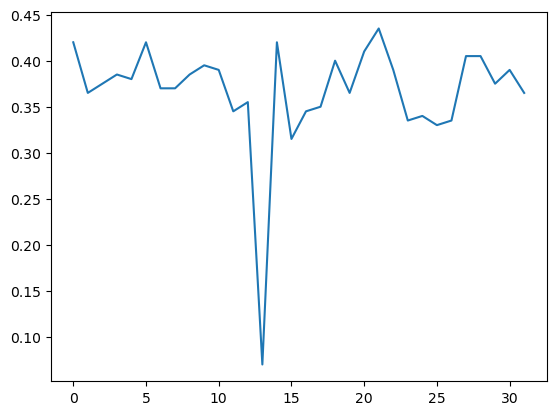

In [46]:
plt.plot(sampler.acceptance_fraction)

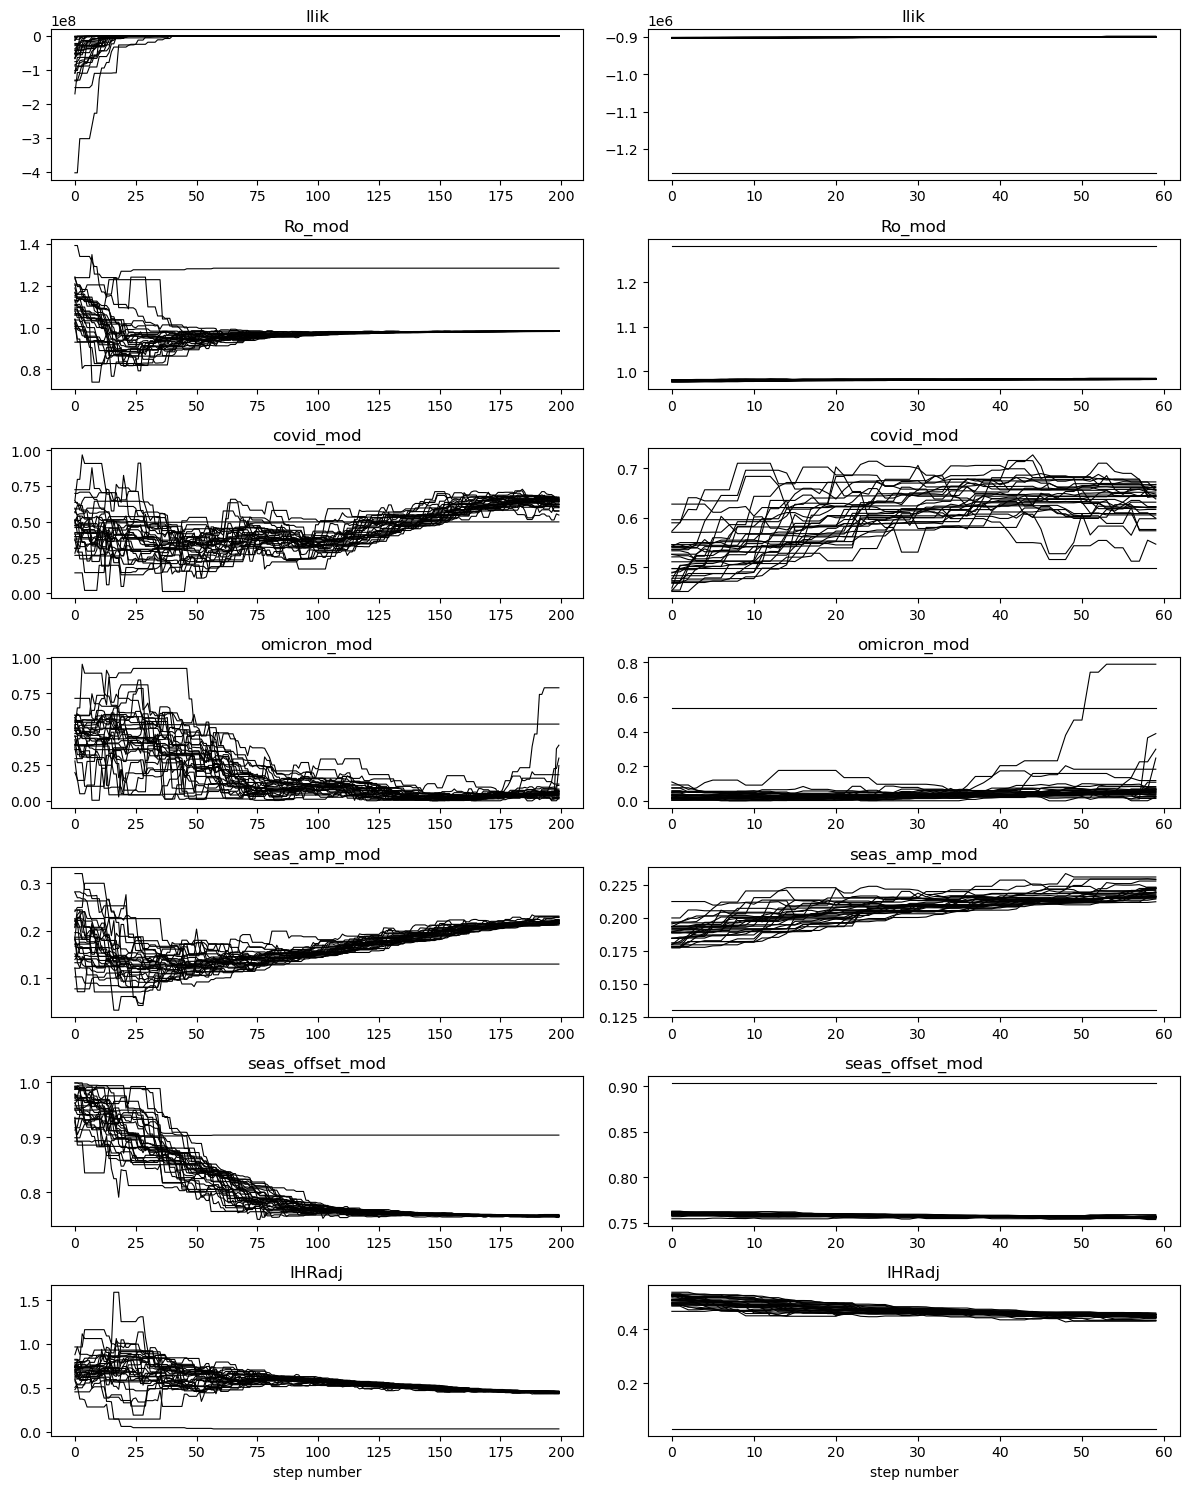

In [54]:
fig, axes = plt.subplots(ndim+1,2, figsize=(12, 15))
samples = sampler.get_chain()
labels = fitted_params["pname"]


def plot_chain(frompt,axes):
    ax = axes[0]
    ax.plot(sampler.get_log_prob()[frompt:], "k", alpha=1, lw=.8)
    ax.set_title("llik")
    #ax.set_xlim(0, len(samples))

    for i in range(ndim):
        ax = axes[i+1]
        ax.plot(samples[frompt:, :, i], "black", alpha=1, lw=.8,)
        #ax.set_xlim(0, len(samples))
        ax.set_title(labels[i])
        #ax.yaxis.set_label_coords(-0.1, 0.5)

    axes[-1].set_xlabel("step number");

plot_chain(0,axes[:,0])
plot_chain(140,axes[:,1])
fig.tight_layout()

(-1500000.0, -890000.0)

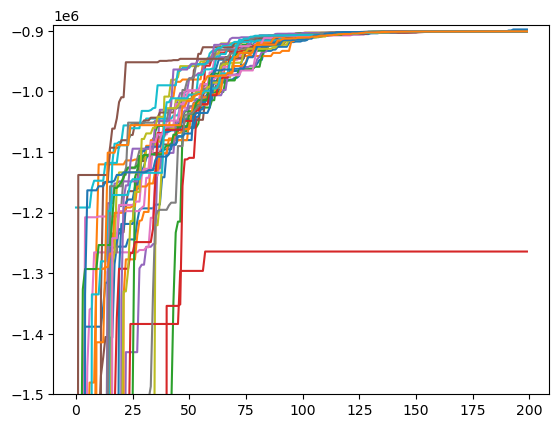

In [59]:
plt.plot(sampler.get_log_prob());
plt.ylim(-0.15e7,-.089e7)

In [ ]:
samples.shape

In [ ]:
def input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim):
    snpi_df_mod = snpi_df_ref.copy(deep=True)
    hnpi_df_mod = hnpi_df_ref.copy(deep=True)

    for i in range(ndim):
        if fitted_params["ptype"][i] == "snpi":
            snpi_df_mod.loc[snpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]
        elif fitted_params["ptype"][i] == "hnpi":
            hnpi_df_mod.loc[hnpi_df_mod["npi_name"] == fitted_params["pname"][i],"reduction"] = proposal[i]

    return snpi_df_mod, hnpi_df_mod


In [ ]:
samples.shape

In [19]:
#import concurrent.futures
#
def evaluate(proposals, k):
    proposal = proposals[k]
    snpi_df_mod, hnpi_df_mod = input_proposal(proposal, snpi_df_ref, hnpi_df_ref, fitted_params, ndim)

    outcomes_df = run_simulation(snpi_df_mod, 
                                hnpi_df_mod,
                                modinf, p_draw, unique_strings, transition_array, proportion_array, proportion_info, initial_conditions, seeding_data, seeding_amounts,outcomes_parameters)
    return outcomes_df
#
#with concurrent.futures.ThreadPoolExecutor(max_workers=nwalkers) as executor:
#    # Map the function to the list of k values in parallel
#    results = list(executor.map(lambda k_val: evaluate(samples[-1,:,:], k_val), np.arange(nwalkers)))
#

results = []
for k in range(nwalkers):
    results.append(evaluate(samples[-1,:,:], k))

INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.15 s
INFO:root:Integrating with method rk4.jit
13819it [00:22, 623.43it/s]
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.02it/s]
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
13819it [00:20, 667.04it/s]
INFO:root:[SEIR.NPI] completed in 0.24 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.44it/s]
INFO:root:[SEIR.NPI] completed in 0.06 s
INFO:root:[Outcomes.Modifiers] completed in 0.18 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 651.88it/s]
INFO:root:[SEIR.NPI] completed in 0.25 s
INFO:root:[Outcomes.Modifiers] completed in 0.02 s
INFO:root:Integrating with method rk4.jit
13819it [00:21, 647.86it/s]
INFO:root:[SEIR.NPI] complet

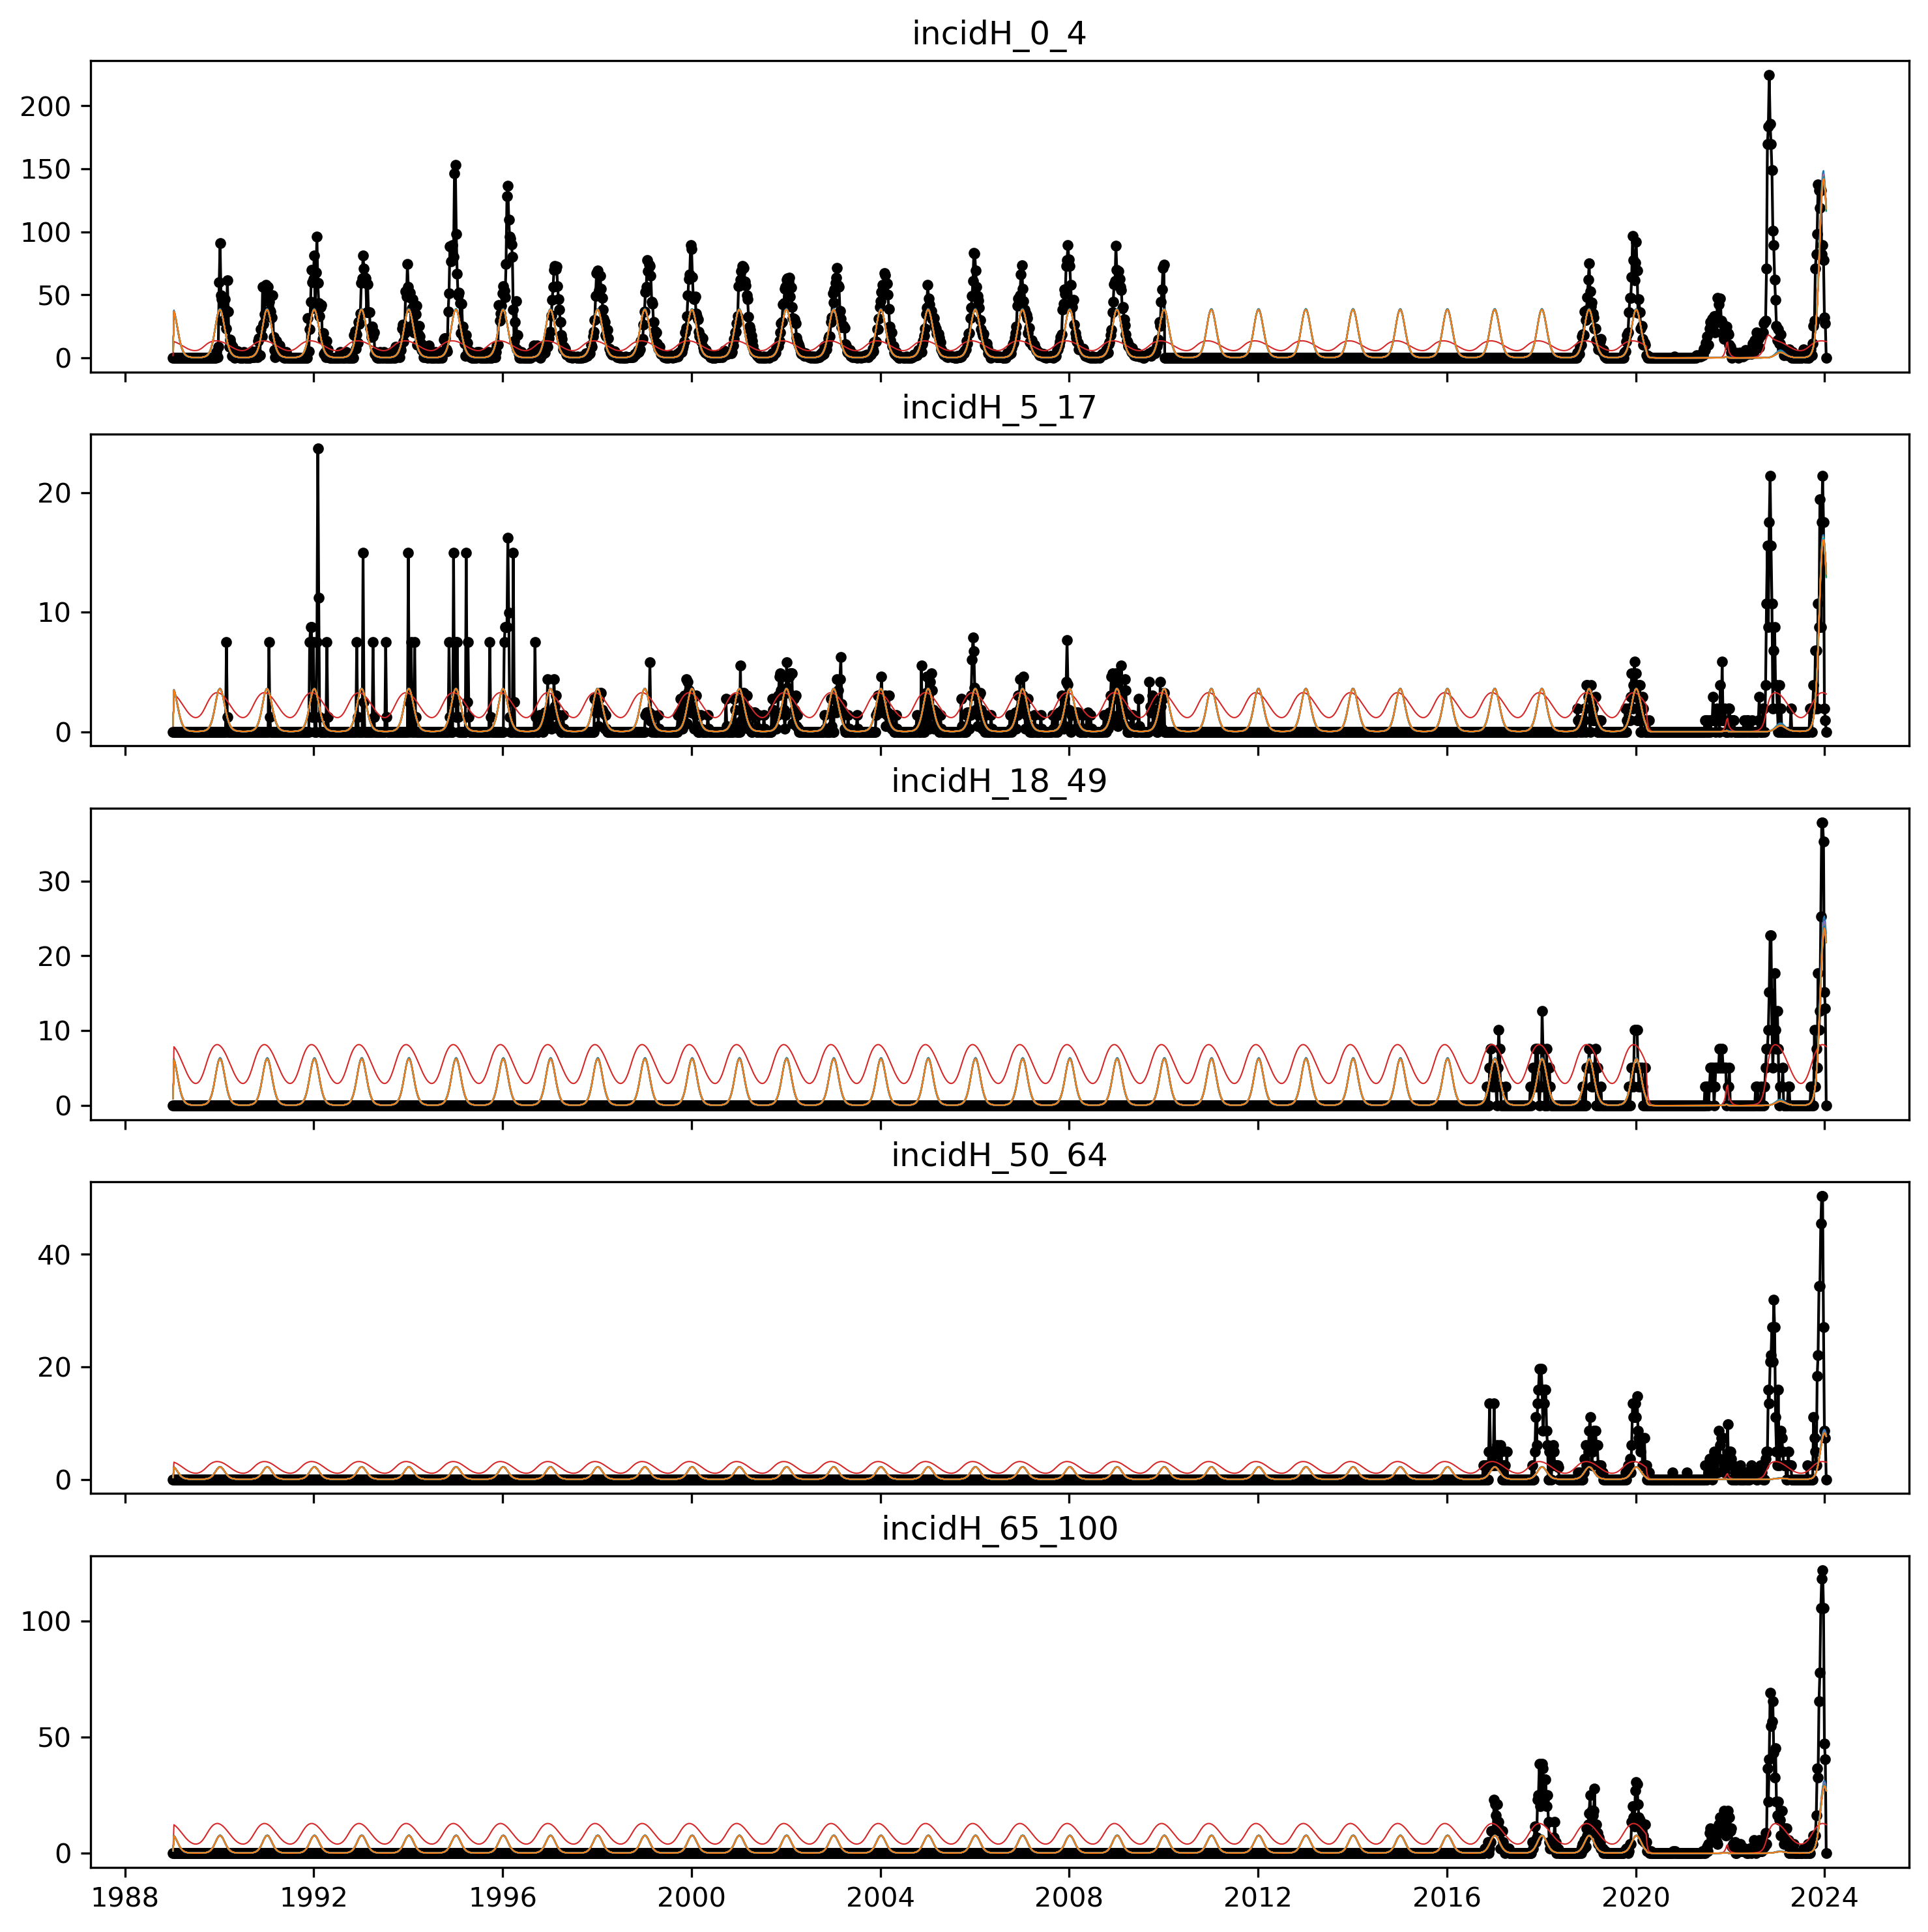

In [23]:
fig, axes = plt.subplots(len(statistics), figsize=(12, 12), sharex=True, dpi=300)
for subpop in modinf.subpop_struct.subpop_names:
        gt_s = gt[gt["subpop"]==subpop].loc[modinf.ti:modinf.tf].drop(["subpop"],axis=1).resample("W-SAT").sum()
        
        for i, (key, value) in enumerate(statistics.items()):
                ax = axes.flat[i]
                ax.plot(gt_s[value], color='k', marker='.', lw=1)
                for model_df in results:
                        model_df_s = model_df[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                        ax.plot(model_df_s[key],  lw=.5)
                #if True:
                #        init_df_s = outcomes_df_ref[model_df["subpop"]==subpop].drop(["subpop","time"],axis=1).loc[min(gt_s.index):max(gt_s.index)].resample("W-SAT").sum() # todo sub subpop here
                ax.set_title(value)

In [41]:
import corner

(1600, 6)


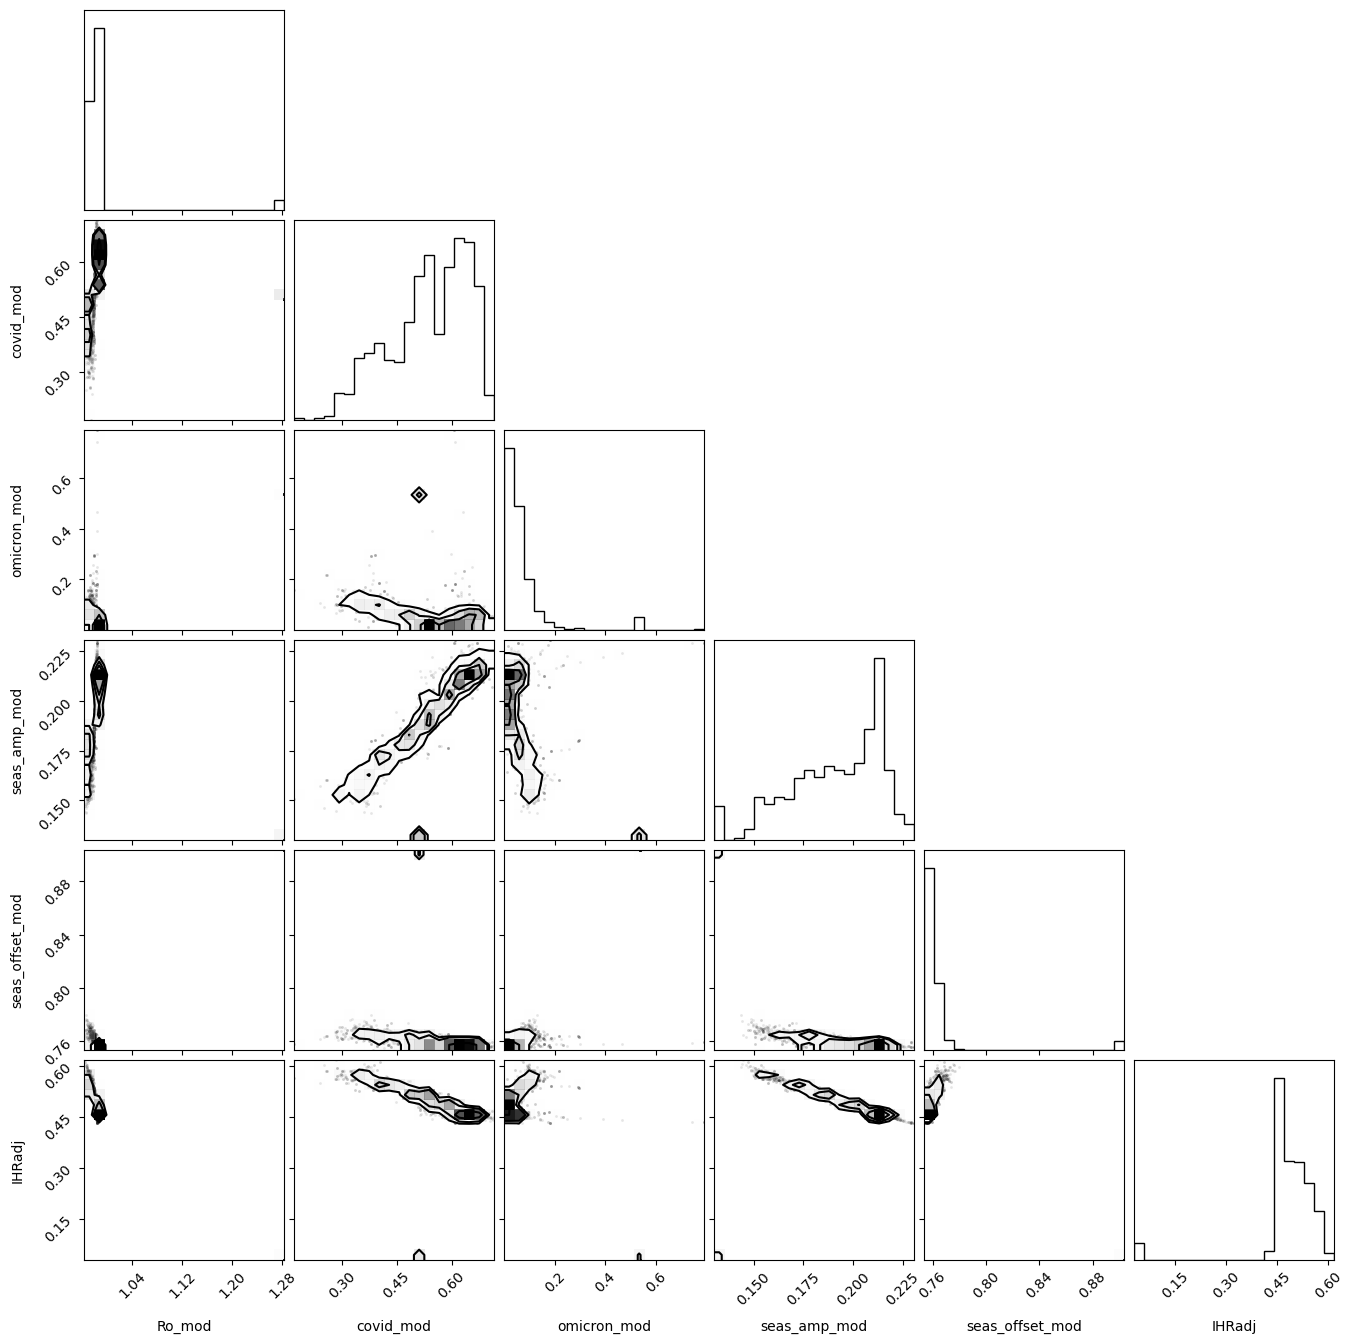

In [42]:
#tau = sampler.get_autocorr_time()
#print(tau)

flat_samples = sampler.get_chain(discard=100, thin=2,flat=True) #discard=100, thin=15, 
print(flat_samples.shape)

import corner

fig = corner.corner(
    flat_samples, labels=labels, #truths=[m_true, b_true, np.log(f_true)]
);